In [7]:
# import CSS stylesheet
from IPython.display import HTML, display
display(HTML(f"<style>{open('style.css').read()}</style>"))

<a id="summary"></a>

<p class="summary">Summary</p>

<ol class="sub">
    <li class="sub"><a href="#packages">Packages</a>
    <li class="sub"><a href="#global-variables-and-functions">Global variables and functions</a></li>
    <li class="sub"><a href="#fixing-north-america-data">Fixing North America Data (names)</a></li>
    <li class="sub"><a href="#data">Data</a></li>
    <li class="sub"><a href="#range-correlation">Range correlation</a>
        <ol class="sub">
            <li class="sub"><a href="#finding-the-sister-species">Finding the sister species</a></li>
            <li class="sub"><a href="#range-correlation-figure">Range correlation figure</a></li>
            <li class="sub"><a href="#range-correlation-figure-border">Range correlation figure (border grids)</a></li>
        </ol>
    </li>
    <li class="sub"><a href="#occurrences-within-grids">Occurrences within grids (adjacency matrix)</a>
        <ol class="sub">
            <li class="sub"><a href="#europe-adj">Europe</a>
                <ol class="sub">
                    <li class="sub"><a href="#europe-adj-50">50 km²</a></li>
                    <li class="sub"><a href="#europe-adj-100">100 km²</a></li>
                    <li class="sub"><a href="#europe-adj-200">200 km²</a></li>
                </ol>
            </li>
            <li class="sub"><a href="#north-america-adj">North America</a>
                <ol class="sub">
                    <li class="sub"><a href="#north-america-adj-50">50 km²</a></li>
                    <li class="sub"><a href="#north-america-adj-100">100 km²</a></li>
                    <li class="sub"><a href="#north-america-adj-200">200 km²</a></li>
                </ol>
            </li>
        </ol>
    </li>
    <li class="sub"><a href="#adj-matrix-for-polygons">Adjacency matrix for polygons cut within the continents</a>
        <ol class="sub">
            <li class="sub"><a href="#europe-adj-cut">Europe</a>
                <ol class="sub">
                    <li class="sub"><a href="#europe-adj-50-cut">50 km²</a></li>
                    <li class="sub"><a href="#europe-adj-100-cut">100 km²</a></li>
                    <li class="sub"><a href="#europe-adj-200-cut">200 km²</a></li>
                </ol>
            </li>
            <li class="sub"><a href="#north-america-adj">North America</a>
                <ol class="sub">
                    <li class="sub"><a href="#north-america-adj-50-cut">50 km²</a></li>
                    <li class="sub"><a href="#north-america-adj-100-cut">100 km²</a></li>
                    <li class="sub"><a href="#north-america-adj-200-cut">200 km²</a></li>
                </ol>
            </li>
        </ol>
    </li>
    <li class="sub"><a href="#adjacency-matrix-common-species">Adjacency matrix common species</a></li>
</ol>

# Packages
<a id="packages"></a>
<a href="#summary">Summary</a>

In [8]:
# directories, dictionaries, and strings
import glob
from collections import OrderedDict
from itertools import combinations
import string

# data structures
import geopandas as gpd
from shapely.geometry import Point, Polygon
import gpd_lite_toolbox as glt

# system
import sys
from multiprocessing import Pool

from pyhvr import *

loadstd()

# Global variables and functions
<a id="global-variables-and-functions"></a>
<a href="#summary">Summary</a>

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[(world['continent'] == 'Europe') & (world['name'] != 'Russia')]
north_america = world[world['continent'] == 'North America']


nad83_proj_dict = {'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0}

wgs84_proj_dict = {'init': 'epsg:4326'}

weck4_proj_dict = "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

In [10]:
def fishnet(polygon, width, height, save_path=False):

    xmin, ymin, xmax, ymax =  polygon.total_bounds

    rows = int(np.ceil((ymax - ymin) /  height))
    cols = int(np.ceil((xmax - xmin) / width))

    XleftOrigin = xmin
    XrightOrigin = xmin + width

    YtopOrigin = ymax
    YbottomOrigin = ymax - height

    polygons = []

    gridHeight, gridWidth = height, width

    for i in range(cols):

        Ytop    = YtopOrigin
        Ybottom = YbottomOrigin

        for j in range(rows):

            polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)]))

            Ytop    = Ytop - gridHeight
            Ybottom = Ybottom - gridHeight

        XleftOrigin  = XleftOrigin + gridWidth
        XrightOrigin = XrightOrigin + gridWidth
    
    if not save_path:
        return gpd.GeoDataFrame({'geometry': polygons})
    else:
        gpd.GeoDataFrame({'geometry': polygons}).to_file(save_path)

In [11]:
def separete_axis():
    for loc, spine in ax.spines.items():
        if loc in ['left', 'bottom']:
            spine.set_position(('outward', 20)) # outward by 20 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)
    
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [12]:
def polygon_border_coords(polygon, xlim=False, ylim=False):
    
    def gdf(polygon):
        # pick the coordinates
        x, y = polygon.exterior.coords.xy
        
        if type(xlim) == list:
            df = pd.DataFrame(OrderedDict({'x': x, 'y': y}))
            df = df[(df['x'] > xlim[0]) & (df['x'] < xlim[1])]
            x, y = np.array(df['x']), np.array(df['y'])
        
        if type(ylim) == list:
            df = pd.DataFrame(OrderedDict({'x': x, 'y': y}))
            df = df[(df['y'] > ylim[0]) & (df['y'] < ylim[1])]
            x, y = np.array(df['x']), np.array(df['y'])
            
        # create the pd.DataFrame
        df = pd.DataFrame({'geometry': list(zip(x, y))})
        # transform all the coordinates into shapely.geometry.Point
        df['geometry'] = df['geometry'].apply(Point)

        # create the gpd.GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry='geometry')
        
        return gdf
    
    if str(type(polygon)) == "<class 'shapely.geometry.polygon.Polygon'>":
        return gdf(polygon)
    
    else:
        return pd.concat([gdf(plg) for plg in polygon])

# Fixing North America Data (names)
<a id="fixing-north-america-data"></a>
<a href="#summary">Summary</a>

In [432]:
north_america_5050_sp = gpd.read_file('../results/north_america/nad83/sp_polygon_5050_nad83/occurrences_within_5050_grid_north_america_nad83.shp')

In [436]:
north_america_sp = pd.DataFrame([[sp.split('_')[0], sp.split('_')[1]] for sp in north_america_5050_sp.columns[:-2]], columns=['code', 'abbreviation'])

In [438]:
sp_abbrev_nort_america = pd.read_table('results/sp_abbrev_north_america_old.dat')

In [441]:
sp_abbrev_nort_america = pd.concat([north_america_sp, sp_abbrev_nort_america], axis=1)

In [443]:
sp_abbrev_nort_america.columns = ['code', 'abbreviation_1', 'name', 'abbreviation_2', 'has']

In [454]:
shp_files = glob.glob("../raw_data/north_america/Shapefilet/*/*shp")
len(shp_files)

folders = [file.split("/")[-2] for file in shp_files]
files   = [file.split("/")[-1] for file in shp_files]

path_details_df = pd.DataFrame(
    OrderedDict(
    {'folders': folders,
     'files': files,
     'paths': shp_files}
    )
)

species_geometries = pd.concat([gpd.read_file(path_details_df['paths'].iloc[i]).dissolve('Id') for i in range(path_details_df.shape[0])])['geometry']

path_details_df['geometry'] = gpd.GeoDataFrame(species_geometries).reset_index(drop=True)
path_details_gdf = gpd.GeoDataFrame(path_details_df, geometry='geometry')

path_details_gdf['area'] = path_details_gdf['geometry'].apply(lambda x: x.area)

In [458]:
north_america_sp_full = path_details_gdf[path_details_gdf['area'] != 0][['folders', 'geometry']]

In [462]:
north_america_sp_full.columns = ['abbreviation', 'geometry']
north_america_sp_full = north_america_sp_full.reset_index(drop=True)

In [467]:
sp_abbrev_nort_america.set_index('abbreviation_2').to_dict()['name']

{'AlisGram': 'Alisma gramineum',
 'AlisLanc': 'Alisma lanceolatum',
 'AlisSubc': 'Alisma subcordatum',
 'AlisTriv': 'Alisma triviale',
 'AzolCaro_g': 'Azolla caroliniana',
 'AzolFili_g': 'Azolla filiculoides',
 'AzolMexi_g': 'Azolla mexicana',
 'BlyxAube': 'Blyxa aubertii',
 'BrasSchr_g': 'Brasenia schreberi',
 'ButoUmbe': 'Butomus umbellatus',
 'CaboCaro_g': 'CaboCaro',
 'CallPalu': nan,
 'CaltLept_g': nan,
 'CaltNata_g': 'Caltha natans',
 'CaltPalu_g': nan,
 'CannFlac': 'Canna flaccida',
 'CannGlau': 'Canna glauca',
 'CeraDeme_g': 'Ceratophyllum demersum',
 'CeraEchi_g': 'Ceratophyllum echinatum',
 'ColoEscu': 'Colocasia esculenta',
 'CommComm': nan,
 'CommVirg': nan,
 'CrinAmer_var_amer': 'Crinum americanum',
 'DamaCali': 'Damasonium californicum',
 'EchiBert': nan,
 'EchiCord_subsp_cord': 'Echinodorus cordifolius',
 'EchiTene': nan,
 'EgerDens': 'Egeria densa',
 'EichCras': 'Eichhornia crassipes',
 'ElodBifo': 'Elodea bifoliata',
 'ElodCana': 'Elodea canadensis',
 'ElodNutt': 'Elod

In [469]:
north_america_sp_full['specie'] = north_america_sp_full['abbreviation'].map(sp_abbrev_nort_america.set_index('abbreviation_2').to_dict()['name'])

In [478]:
north_america_sp_full['has'] = north_america_sp_full['abbreviation'].map(sp_abbrev_nort_america.set_index('abbreviation_2').to_dict()['has'])

In [482]:
north_america_sp_full.crs = nad83_proj_dict

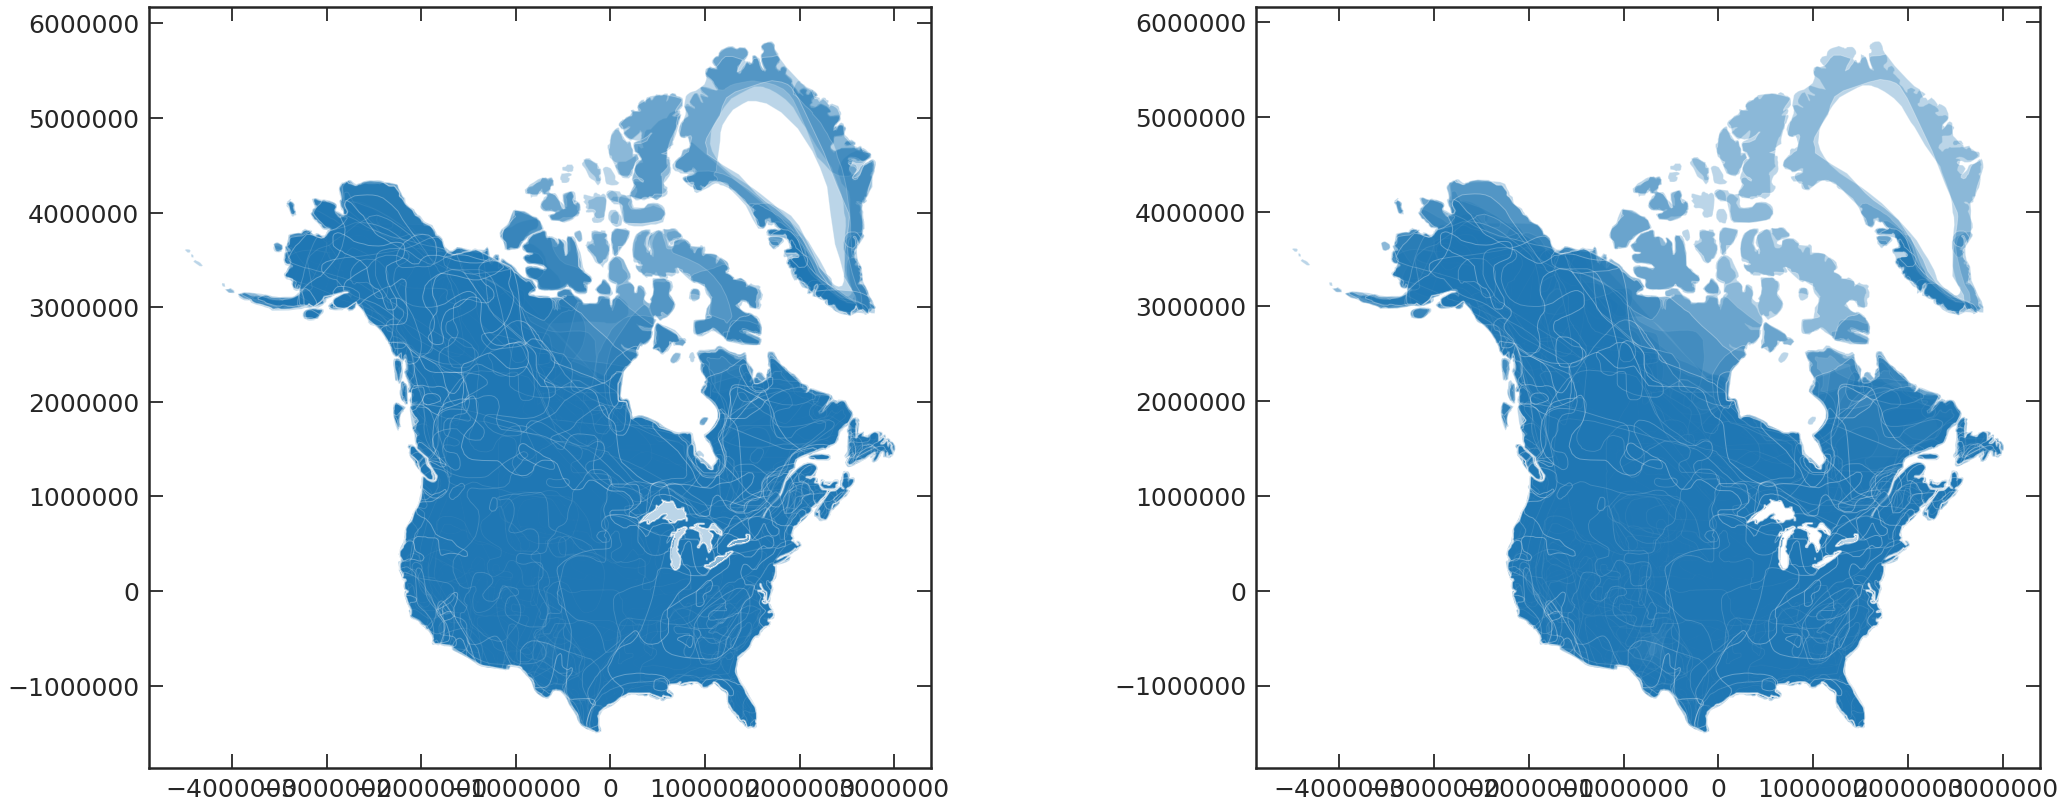

In [485]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(ny=1, nx=2, scale=2))

north_america_sp_full.plot(ax=ax[0], alpha=0.3)
north_america_sp_full[north_america_sp_full['has'] == 'y'].plot(ax=ax[1], alpha=0.3)

In [487]:
north_america_sp_full.to_file('../results/north_america/complete_data/complete_sp_data_abbrev_name_north_america.shp')

# Data
<a id="data"></a>
<a href="#summary">Summary</a>

First we are going to load the file that have the names of the species and their abbreviations. We need both of them to map the names of the species for the Europe and North America species polygons.

In [13]:
species_names_df = pd.read_excel('../data/all_spp_names.xlsx')

From this file we pick the names and their abbreviations and put into a **pd.DataFrame**.

In [14]:
species_names_df = pd.DataFrame(species_names_df[species_names_df.columns[1:-1]].iloc[2]).reset_index()
species_names_df.columns = ['name', 'abbreviation']

In [15]:
species_names_df.head()

name abbreviation
0           Alisma gramineum     AlisGram
1         Alisma lanceolatum     AlisLanc
2  Alisma plantago-aquatica     AlisPlana
3         Alisma subcordatum     AlisSubc
4            Alisma triviale     AlisTriv

Several species are Unnamed_n (n $\in$ I).

In [16]:
species_names_df[species_names_df['name'].str.contains('Unnamed')]

name abbreviation
13    Unnamed: 14     CallPalu
14    Unnamed: 15   CaltLept_G
16    Unnamed: 17     CaltPalu
22    Unnamed: 23     CommComm
23    Unnamed: 24     CommVirg
..            ...          ...
326  Unnamed: 327     ThalTest
327  Unnamed: 328     TrigGasp
328  Unnamed: 329     TrigMari
329  Unnamed: 330     TrigPalu
330  Unnamed: 331     TrigStri

[110 rows x 2 columns]

In [17]:
species_names_df_ok = species_names_df[~species_names_df['name'].str.contains('Unnamed')]

We load the **.shp** files that contain the name of the specie and the polygon with the land that they occupy.

In [ ]:
europe_df        = gpd.read_file('../results/europe/sp_polygon_old/europe_sp_polygon.shp')
north_america_df = gpd.read_file('../results/north_america_again/sp_polygon_old/north_america_again_sp_polygon.shp')

We are going to use the old dataset for North America, since the new one seems to have some problems.

In [ ]:
north_america_old = gpd.read_file('../results/north_america/nad83/sp_polygon_5050_nad83/occurrences_within_5050_grid_north_america_nad83.shp')

In [35]:
north_america_sp_code_dict_old = {int(specie.split('_')[0]): specie.split('_')[1] for specie in north_america_old.columns[:-2]}

In [37]:
shp_files = glob.glob("../raw_data/north_america/Shapefilet/*/*shp")

folders = [file.split("/")[-2] for file in shp_files]
files   = [file.split("/")[-1] for file in shp_files]

path_details_df = pd.DataFrame(
    OrderedDict(
    {'folders': folders,
     'files': files,
     'paths': shp_files}
    )
)

species_geometries = pd.concat([gpd.read_file(path_details_df['paths'].iloc[i]).dissolve('Id') for i in range(path_details_df.shape[0])])['geometry']

path_details_df['geometry'] = gpd.GeoDataFrame(species_geometries).reset_index(drop=True)
path_details_gdf = gpd.GeoDataFrame(path_details_df, geometry='geometry')

path_details_gdf = path_details_gdf.sort_values('folders')
path_details_gdf['area'] = path_details_gdf.area

species = path_details_gdf[path_details_gdf['area'] != 0].reset_index(drop=True)['folders']

north_america_sp_code_dict = {sp: n for n, sp in enumerate(species)}

In [38]:
north_america_sp_wf_df = pd.DataFrame([[north_america_sp_code_dict_old[north_america_sp_code_dict[sp]], sp] for sp, n in north_america_sp_code_dict.items()], columns=['wrong', 'fixed'])

In [39]:
tmp_l = []

# abbreviation of the specie with code
specie = north_america_old.columns[:-2][0]
for specie in north_america_old.columns[:-2]:
    # just the abbreviation (wrong)
    abbrev_wrong = specie.split('_')[1]
    # dissolved geometry of the current specie
    tmp_df = north_america_old[north_america_old[specie] != 0][[specie, 'geometry']].dissolve(specie).reset_index(drop=True)
    # get the correct abbreviation from the folders, since the shp modify the name of the columns
    abbrev_fixed = north_america_sp_wf_df[north_america_sp_wf_df['wrong'] == abbrev_wrong]['fixed'].iloc[0]

    tmp_df['abbreviation'] = abbrev_fixed

    tmp_l.append(tmp_df)

In [40]:
tmp_df = pd.concat(tmp_l).reset_index(drop=True)

tmp_df['fixed'] = north_america_sp_wf_df['fixed']

tmp_df['abbreviation'] = tmp_df['fixed']

del tmp_df['fixed']

Set the projections, since the exported file did not have the **.prj** file with it.

In [ ]:
europe_df.crs        = nad83_proj_dict
north_america_df.crs = nad83_proj_dict
north_america_old_df = gpd.GeoDataFrame(tmp_df, geometry='geometry', crs=nad83_proj_dict)

In [42]:
north_america_df['abbreviation']

KeyError: 'abbreviation'

In [44]:
north_america_old_df['abbreviation']

0            AlisGram
1            AlisLanc
2            AlisSubc
3            AlisTriv
4          AzolCaro_g
            ...      
305          WolfGlob
306    WolffiellaGlad
307    WolffiellaLing
308    WolffiellaOblo
309          ZannPalu
Name: abbreviation, Length: 310, dtype: object

We can see that the data for Europe has the full names of the species, while for North America their names are abbreviated.

In [45]:
europe_df['specie'].head()

0              Acorus calamus
1       Aldrovanda vesiculosa
2            Alisma gramineum
3          Alisma lanceolatum
4    Alisma plantago-aquatica
Name: specie, dtype: object

In [46]:
north_america_df['specie'].head()

0     AlisGram
1     AlisLanc
2    AlisPlana
3     AlisSubc
4     AlisTriv
Name: specie, dtype: object

We are going to export the files with the names we want (**species_names_df_ok**), the names of species in North America (**north_america_old_df[['name', 'abbreviation']]**) so we can select the corret species and the same for the species in (**europe_df[['specie', 'abbreviation']]**).

In [389]:
# species_names_df_ok.to_csv('../results/sp_abbrev_file.dat', sep='\t', index=False)

In [390]:
# north_america_old_df[['name', 'abbreviation']].to_csv('../results/sp_abbrev_north_america_old.dat', sep='\t', index=False)

In [388]:
# europe_df[['specie', 'abbreviation']].to_csv('../results/sp_abbrev_europe.dat', sep='\t', index=False)

Actually, we just needed to do this for the North America since the data for Europe were already correct.

After selecting the correct names for each continent, we filter our dataframes:

In [48]:
checked_names_north_america = pd.read_table('../results/sp_abbrev_north_america_old.dat')
north_america_old_df['specie'] = north_america_old_df['abbreviation'].map(checked_names_north_america[checked_names_north_america['has'] == 'y'][['abbreviation','name']].set_index('abbreviation').to_dict()['name']).dropna()

In [49]:
north_america_old_df = north_america_old_df[['specie', 'geometry', 'abbreviation']].dropna()

We create a column for the names abbreviated for Europe.

In [ ]:
europe_df['abbreviation'] = europe_df['specie'].map(species_names_df_ok.set_index('name').to_dict()['abbreviation'])

In [ ]:
europe_df['genus']            = europe_df['specie'].apply(lambda name: name.replace('_', ' ').split()[0])
north_america_old_df['genus'] = north_america_old_df['specie'].apply(lambda name: name.replace('_', ' ').split()[0])

In [52]:
north_america_old_df[['specie']].to_csv('tmp_na.dat', sep='\t', index=False)
europe_df[['specie']].to_csv('tmp_eu.dat', sep='\t', index=False)

In [ ]:
common_species = list(pd.read_table('../results/common_sp_na_eu.dat', names=['common'])['common'])

In [55]:
north_america_old_df = gpd.GeoDataFrame(tmp_l, columns=['geometry', 'abbreviation'], geometry='geometry', crs=nad83_proj_dict)

ValueError: Shape of passed values is (1, 310), indices imply (2, 310)

In [ ]:
europe_common        = europe_df[europe_df['specie'].isin(common_species)]
north_america_common = north_america_old_df[north_america_old_df['specie'].isin(common_species)]

In [456]:
# europe_df.to_file('../results/europe/sp_polygon/sp_polygon_europe.shp')
# north_america_old_df.to_file('../results/north_america/sp_polygon/sp_polygon_north_america.shp')

# europe_common.to_file('../results/europe/sp_polygon_common/sp_polygon_europe_common.shp')
# north_america_common.to_file('../results/north_america/sp_polygon_common/sp_polygon_north_america_common.shp')

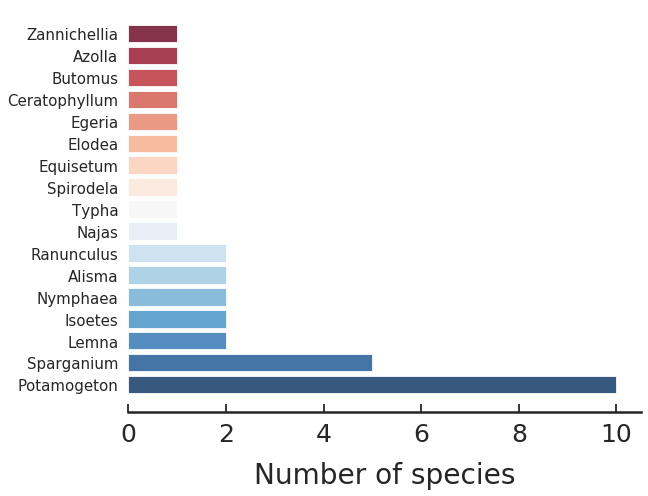

In [448]:
fig, ax = plt.subplots(figsize=stdfigsize())

df = europe_common.groupby('genus').count()['specie'].sort_values(ascending=False)

y_teses        = np.arange(0, df.shape[0])

ax.barh(y_teses, df, color=[palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap(i) for i in np.linspace(0,1,df.shape[0])], alpha=0.8)

ax.set_yticks(y_teses)
ax.set_yticklabels(df.index, fontdict={'fontsize':15})
ax.set_xlabel('Number of species')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

        # Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis=u'y', which=u'both',length=0)
ax.tick_params(axis=u'x', which=u'both',length=8)

# ax.annotate(string.ascii_lowercase[c], xy=(-0.1, 1.01), xycoords='axes fraction', fontsize=40, weight='bold')

fig.tight_layout()
# fig.savefig('../figures/common_species_genus.pdf', bbox_inches='tight')
# fig.savefig('../figures/common_species_genus.png', bbox_inches='tight')

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


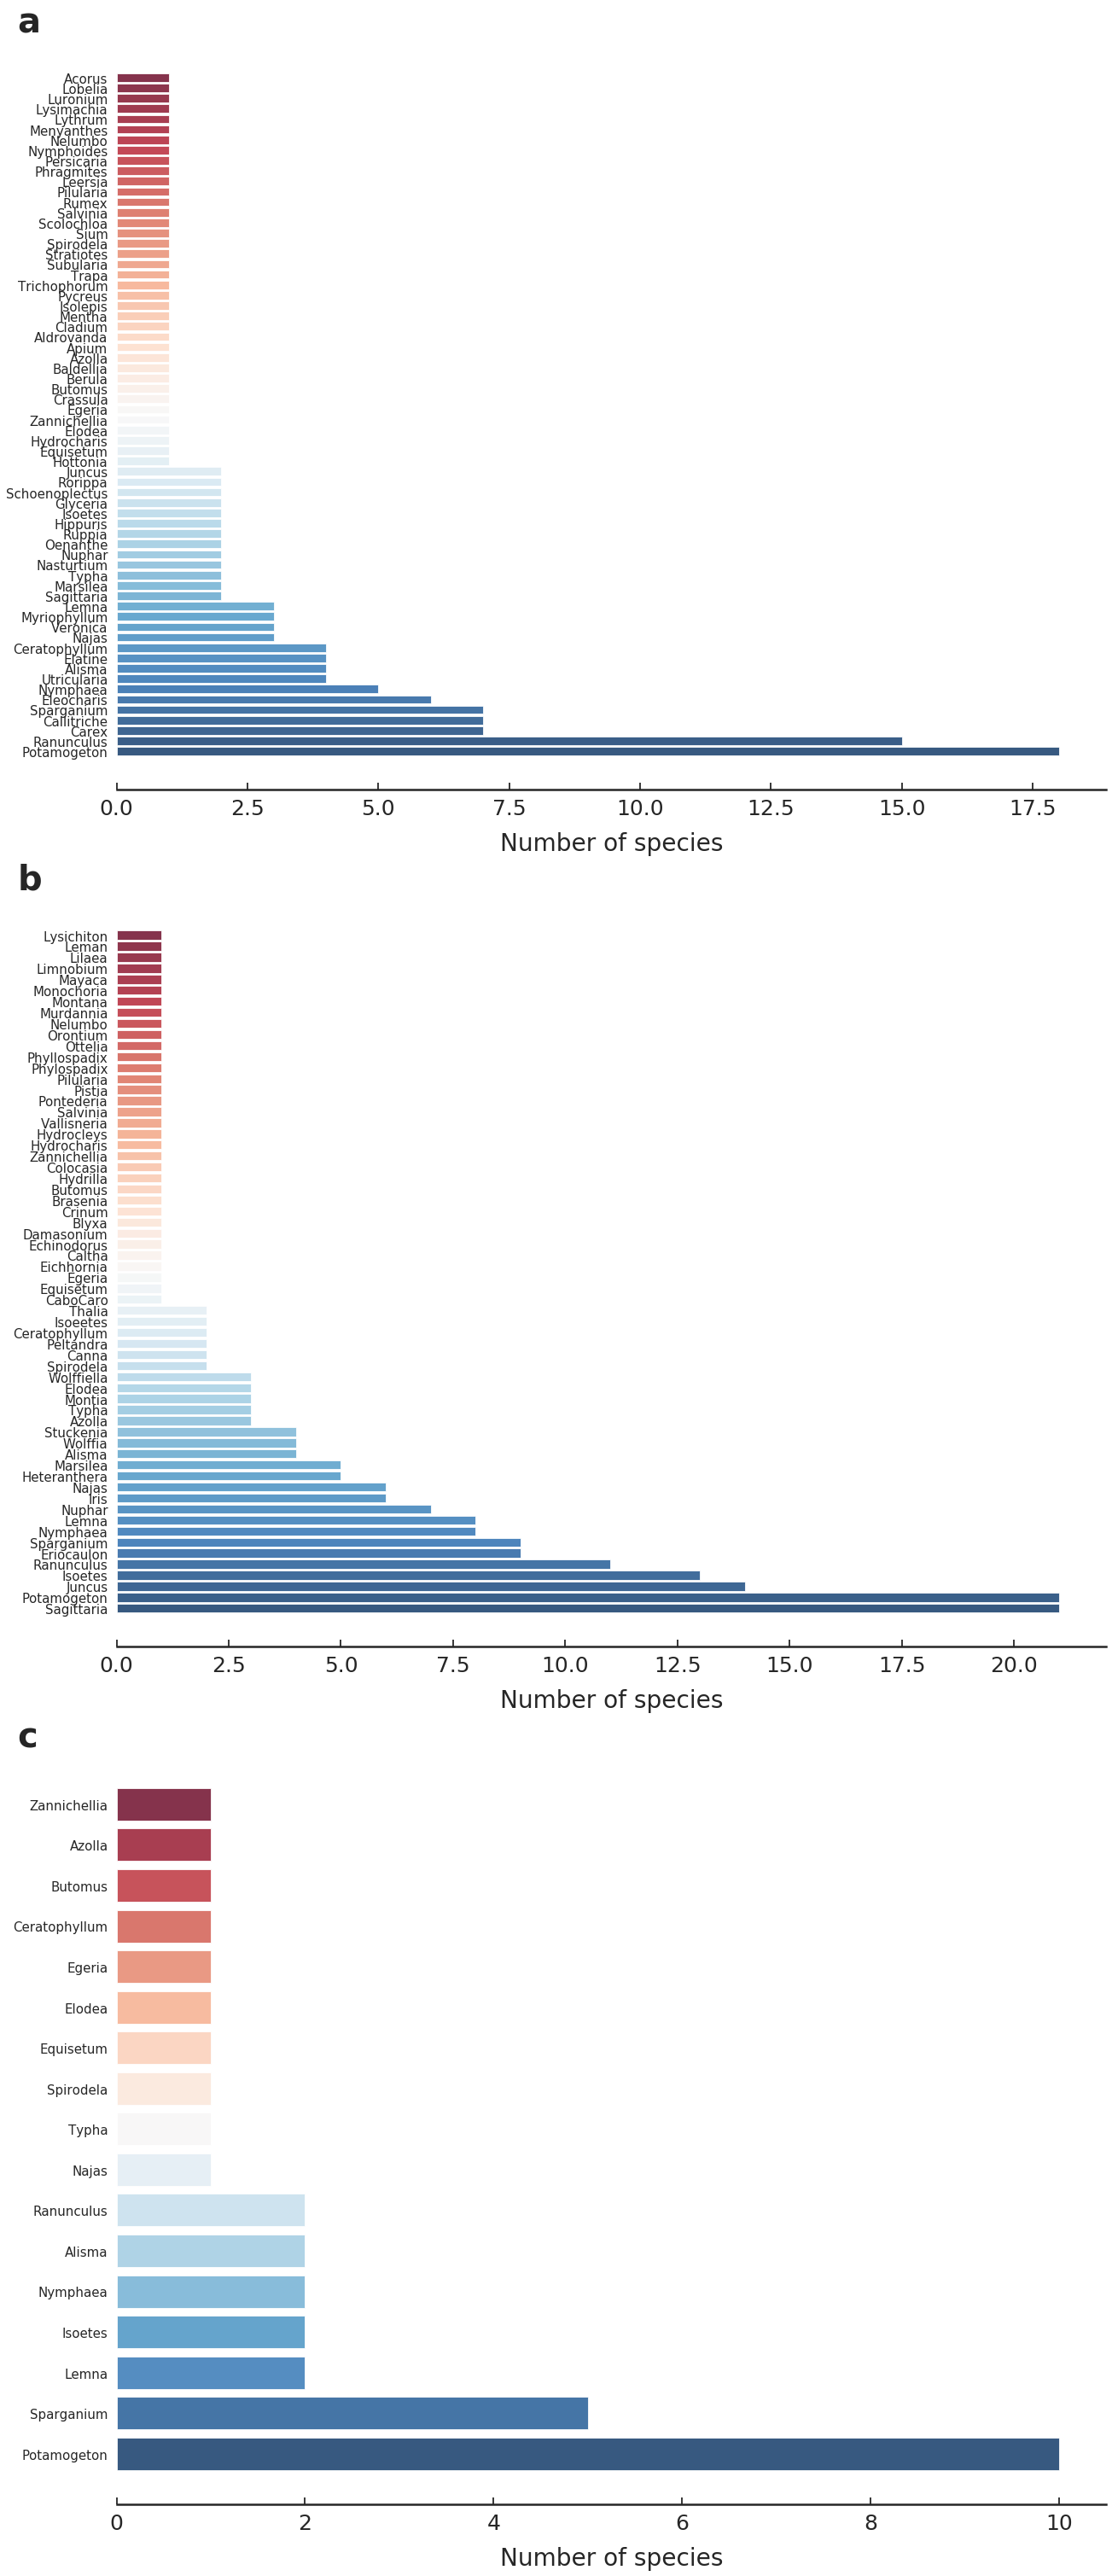

In [451]:
fig, ax = plt.subplots(3, 1, figsize=stdfigsize(scale=2, ny=3, nx=1))

dfs = [europe_df.groupby('genus').count()['specie'].sort_values(ascending=False),
       north_america_old_df.groupby('genus').count()['specie'].sort_values(ascending=False),
       europe_common.groupby('genus').count()['specie'].sort_values(ascending=False)
      ]

c = 0
for ax in ax:
    
    df = dfs[c]
    y = np.arange(0, df.shape[0])

    ax.barh(y, df, color=[palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap(i) for i in np.linspace(0,1,df.shape[0])], alpha=0.8)

    ax.set_yticks(y)
    ax.set_yticklabels(df.index, fontdict={'fontsize':15})
    ax.set_xlabel('Number of species')

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

            # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis=u'y', which=u'both',length=0)
    ax.tick_params(axis=u'x', which=u'both',length=8)

    ax.annotate(string.ascii_lowercase[c], xy=(-0.1, 1.01), xycoords='axes fraction', fontsize=40, weight='bold')
    
    c += 1
    
fig.tight_layout()
# fig.savefig('figures/common_species_genus.pdf', bbox_inches='tight')
# fig.savefig('figures/common_species_genus.png', bbox_inches='tight')

# Range correlation
<a id="range-correlation"></a>
<a href="#summary">Summary</a>

## Finding the sister species
<a id="finding-the-sister-species"></a>
<a href="#summary">Summary</a>

First we load the files we have been working on in the last section.

These are the aquatic species for:
 * Europe
 * North America
 * Common species between Europe and North America
  * Europe common species
  * North America common species

In [36]:
# Species in Europe
europe_sp = gpd.read_file('../results/europe/sp_polygon/sp_polygon_europe.shp')
# Species in North America
north_america_sp = gpd.read_file('../results/north_america/sp_polygon/sp_polygon_north_america.shp')
# Common species in Europe
europe_common_sp = gpd.read_file('../results/europe/sp_polygon_common/sp_polygon_europe_common.shp')
# Common species in North America
north_america_common_sp = gpd.read_file('../results/north_america/sp_polygon_common/sp_polygon_north_america_common.shp')

In [198]:
europe_sp['area'] = europe_sp.area
north_america_sp['area'] = north_america_sp.area
europe_common_sp['area'] = europe_common_sp.area
north_america_common_sp['area'] = north_america_common_sp.area

We are going to write a function to see how many pairs of species sisters we have.

In [210]:
# function to count all the combinantions in a list and return those with size 2
def subs(l):
    res = []
    for i in range(1, len(l) + 1):
        for combo in combinations(l, i):
            if len(list(combo)) == 2:
                res.append(list(combo))
    return res

In [16]:
def species_overlay(df):
# df = europe_common_sp
    # calculate the genus pairs if their is more than one specie on the genus
    genus_with_pairs = df.groupby('genus').count()['specie'][df.groupby('genus').count()['specie'] != 1].index

# genus = genus_with_pairs[6]
    # loop through the genus
    genus_df = []
    for genus in genus_with_pairs:
        # create the list of pairs in the current genus
#         pair_list = subs(list(df[df['genus'] == genus]['specie']))
        pair_list = [list(pair) for pair in combinations(list(df[df['genus'] == genus]['specie']), 2)]
        # this list will append the tmp_df with the pair
        # species, their geometry and their area
        pair_df = []
        # loop through the pairs of species
        for pair in pair_list:
            # create a tmp pd.DataFrame
            tmp_df = pd.DataFrame()
            # pick the species of the current pair
            sp1 = pair[0]
            sp2 = pair[1]
            # give the row with the specie, polygon geometry, and area for the species    
            df_1 = df[df['specie'] == sp1][['specie', 'geometry', 'area']].reset_index(drop=True)
            df_2 = df[df['specie'] == sp2][['specie', 'geometry', 'area']].reset_index(drop=True)

            # calculate the overlap between the species area
            df_overlay = gpd.overlay(df_1, df_2, how='intersection')

            # create a pd.DataFrame with one row and append to the final pd.DataFrame
            pair_df.append(df_overlay)

        # group the pair_df
        pair_df = pd.concat(pair_df).reset_index(drop=True)
        # calculate the overlap area for each pair of sister species
        pair_df['overlap_area'] = pair_df.area
        
        # create a column for the genus
        pair_df['genus'] = [genus for _ in range(pair_df.shape[0])]
        # append the pair_df to the genus_df
        genus_df.append(pair_df)
    
    # group the genus_df
    genus_df = pd.concat(genus_df).reset_index(drop=True).dropna(axis=1)
    
    # calculating the sympatry
    genus_df['sympatry'] = genus_df['overlap_area'] / (genus_df[['area_1', 'area_2']].min(axis=1))
    
    # return the final df
    return genus_df

In [201]:
europe_overlay = species_overlay(europe_sp)
europe_common_overlay = species_overlay(europe_common_sp)

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [202]:
north_america_overlay = species_overlay(north_america_sp)
north_america_common_overlay = species_overlay(north_america_common_sp)

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [636]:
# europe_overlay.to_file('../results/europe/overlay/europe_overlay.shp')
# europe_common_overlay.to_file('../results/europe/common_overlay/europe_common_overlay.shp')

# north_america_overlay.to_file('../results/north_america/overlay/north_america_overlay.shp')
# north_america_common_overlay.to_file('../results/north_america/common_overlay/north_america_common_overlay.shp')

In [26]:
gpd.read_file('../results/europe/overlay/europe_overlay.shp')

area_1        area_2        genus    overlap_ar  \
0    1.416207e+12  1.196481e+12       Alisma  9.216884e+11   
1    1.416207e+12  3.212528e+12       Alisma  1.372833e+12   
2    1.196481e+12  3.212528e+12       Alisma  1.147855e+12   
3    3.212528e+12  4.692696e+09       Alisma  4.692696e+09   
4    6.850892e+11  2.291678e+12  Callitriche  1.488822e+11   
..            ...           ...          ...           ...   
366  1.674270e+12  3.420885e+12  Utricularia  1.548251e+12   
367  2.829480e+12  3.420885e+12  Utricularia  2.624707e+12   
368  2.720493e+12  2.824603e+12     Veronica  2.655850e+12   
369  2.720493e+12  2.619410e+11     Veronica  2.577109e+11   
370  2.824603e+12  2.619410e+11     Veronica  2.480359e+11   

                        specie_1                  specie_2  sympatry  \
0               Alisma gramineum        Alisma lanceolatum  0.770333   
1               Alisma gramineum  Alisma plantago-aquatica  0.969373   
2             Alisma lanceolatum  Alisma plantago-aquatica  0.959359   
3       Alisma plantago-aquatica       Alisma wahlenbergii  1.000000   
4             Callitriche brutia    Callitriche cophocarpa  0.217318   
..                           ...                       ...       ...   
366       Utricularia intermedia      Utricularia vulgaris  0.924732   
367            Utricularia minor      Utricularia vulgaris  0.927629   
368  Veronica anagallis-aquatica       Veronica beccabunga  0.976239   
369  Veronica anagallis-aquatica         Veronica catenata  0.983851   
370          Veronica beccabunga         Veronica catenata  0.946915   

                                              geometry  
0    (POLYGON ((5299529.006264892 5166825.433647369...  
1    (POLYGON ((5395229.318563743 5886444.193651658...  
2    (POLYGON ((6173250.260333871 5100256.527616069...  
3    (POLYGON ((4755559.383759195 5733206.054631383...  
4    (POLYGON ((5296517.290955049 4531182.710366918...  
..                                                 ...  
366  (POLYGON ((6528745.650981084 5521499.725806586...  
367  (POLYGON ((6662723.543400461 5681834.519690237...  
368  (POLYGON ((5276410.187629584 4487888.384617988...  
369  (POLYGON ((6707439.678436729 5958817.39226424,...  
370  (POLYGON ((6631082.074656261 5780756.358653402...  

[371 rows x 8 columns]

## Range correlation figure
<a id="range-correlation-figure"></a>
<a href="#summary">Summary</a>

In [15]:
occurrences_within_5050_grid_europe   = gpd.read_file('../results/europe/adj_matrix_5050/occurrences_within_5050_grid_europe.shp')
occurrences_within_100100_grid_europe = gpd.read_file('../results/europe/adj_matrix_100100/occurrences_within_100100_grid_europe.shp')
occurrences_within_200200_grid_europe = gpd.read_file('../results/europe/adj_matrix_200200/occurrences_within_200200_grid_europe.shp')

In [16]:
occurrences_within_5050_grid_north_america   = gpd.read_file('../results/north_america/adj_matrix_5050/occurrences_within_5050_grid_north_america.shp')
occurrences_within_100100_grid_north_america = gpd.read_file('../results/north_america/adj_matrix_100100/occurrences_within_100100_grid_north_america.shp')
occurrences_within_200200_grid_north_america = gpd.read_file('../results/north_america/adj_matrix_200200/occurrences_within_200200_grid_north_america.shp')

In [17]:
def sp_polygon_from_grids(df):

    l = []
    df = df.to_crs(nad83_proj_dict)
    for sp in df.columns[:-9]:
    # sp = species[0]
        gdf_tmp = df[df[sp] == 1].dissolve(sp)[['geometry']].reset_index(drop=True)
        gdf_tmp['area'] = gdf_tmp.area
        gdf_tmp['specie'] = sp
        gdf_tmp['genus']   = sp.split()[0]
        l.append(gdf_tmp)

    return pd.concat(l).reset_index(drop=True)

In [18]:
europe_sp_5050   = sp_polygon_from_grids(occurrences_within_5050_grid_europe)
europe_sp_100100 = sp_polygon_from_grids(occurrences_within_100100_grid_europe)
europe_sp_200200 = sp_polygon_from_grids(occurrences_within_200200_grid_europe)

In [19]:
north_america_sp_5050   = sp_polygon_from_grids(occurrences_within_5050_grid_north_america)
north_america_sp_100100 = sp_polygon_from_grids(occurrences_within_100100_grid_north_america)
north_america_sp_200200 = sp_polygon_from_grids(occurrences_within_200200_grid_north_america)

In [20]:
common_sp_na_eu = pd.read_table('../results/common_sp_na_eu.dat', names=['specie'])

In [22]:
europe_sp_5050_common   = europe_sp_5050[europe_sp_5050['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)
europe_sp_100100_common = europe_sp_100100[europe_sp_100100['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)
europe_sp_200200_common = europe_sp_200200[europe_sp_200200['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)

In [23]:
north_america_sp_5050_common   = north_america_sp_5050[north_america_sp_5050['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)
north_america_sp_100100_common = north_america_sp_100100[north_america_sp_100100['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)
north_america_sp_200200_common = north_america_sp_200200[north_america_sp_200200['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)

In [24]:
europe_overlay_5050   = species_overlay(europe_sp_5050)
europe_overlay_100100 = species_overlay(europe_sp_100100)
europe_overlay_200200 = species_overlay(europe_sp_200200)

europe_overlay_5050_common   = species_overlay(europe_sp_5050_common)
europe_overlay_100100_common = species_overlay(europe_sp_100100_common)
europe_overlay_200200_common = species_overlay(europe_sp_200200_common)

NameError: name 'species_overlay' is not defined

In [248]:
north_america_overlay_5050   = species_overlay(north_america_sp_5050)
north_america_overlay_100100 = species_overlay(north_america_sp_100100)
north_america_overlay_200200 = species_overlay(north_america_sp_200200)

north_america_overlay_5050_common   = species_overlay(north_america_sp_5050_common)
north_america_overlay_100100_common = species_overlay(north_america_sp_100100_common)
north_america_overlay_200200_common = species_overlay(north_america_sp_200200_common)

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


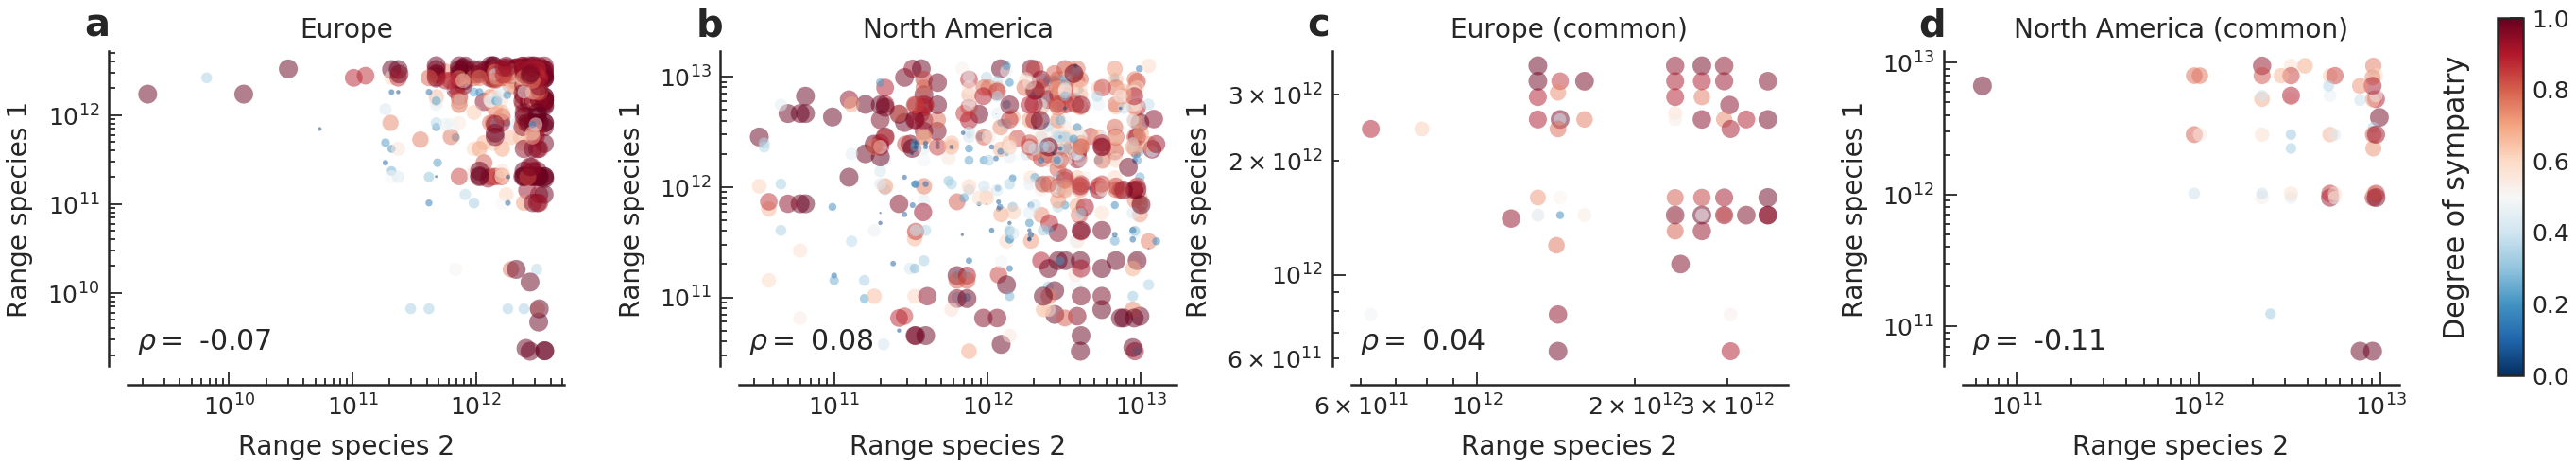

In [704]:
fig, ax = plt.subplots(1, 4, figsize=stdfigsize(ny=1, nx=4))

df_l = [europe_overlay, north_america_overlay, europe_common_overlay, north_america_common_overlay]

kwargs = dict(lw=0, marker='o', alpha=0.5, legend=False)

c = 0
for ax in ax.flat:
#     im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap)
    colors=[palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap(i) for i in df_l[c]['sympatry']]
    
    df_l[c][['area_1', 'area_2']].plot.scatter('area_1', 'area_2', ax=ax, **kwargs, s=df_l[c]['sympatry']*400, c=colors)
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_ylabel('Range species 1')
    ax.set_xlabel('Range species 2')
    
    ax.set_title(['Europe', 'North America', 'Europe (common)', 'North America (common)'][c])
    
    ax.annotate('$\\rho=$ {:.2f}'.format(df_l[c][['area_1', 'area_2']].apply(np.log).corr().loc['area_1', 'area_2'].round(3)),
               xy=(0.02,0.05), xycoords='axes fraction', fontsize=30)
    
    ax.annotate(string.ascii_lowercase[c], xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=40, weight='bold')
    
    for loc, spine in ax.spines.items():
        if loc in ['left', 'bottom']:
            spine.set_position(('outward', 20)) # outward by 20 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)
    
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    c += 1
    
ax.annotate('Degree of sympatry', xy=(1.1, 0.92), xycoords='axes fraction', rotation=90, fontsize=30)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0.20, 0.01, 0.75])
fig.colorbar(im, cax=cbar_ax)
    
fig.tight_layout()
# fig.savefig('../figures/range_correlation.pdf', bbox_inches='tight')
# fig.savefig('../figures/range_correlation.png', bbox_inches='tight')

In [669]:
europe_overlay_5050[europe_overlay_5050['']]

area_1        area_2        genus  \
0    1.933287e+12  1.776160e+12       Alisma   
1    1.933287e+12  3.832137e+12       Alisma   
2    1.776160e+12  3.832137e+12       Alisma   
3    3.832137e+12  2.010534e+10       Alisma   
4    9.399973e+11  2.828285e+12  Callitriche   
..            ...           ...          ...   
371  2.067543e+12  3.977778e+12  Utricularia   
372  3.297636e+12  3.977778e+12  Utricularia   
373  3.306990e+12  3.445427e+12     Veronica   
374  3.306990e+12  4.151922e+11     Veronica   
375  3.445427e+12  4.151922e+11     Veronica   

                                              geometry  overlap_area  \
0    (POLYGON ((475971.2740134131 5434166.158095203...  1.397348e+12   
1    (POLYGON ((475971.2740134131 5434166.158095203...  1.900439e+12   
2    (POLYGON ((625971.2740134131 5434166.158095203...  1.741137e+12   
3    (POLYGON ((1525971.274013413 7243439.495892109...  2.010534e+10   
4    (POLYGON ((1825971.274013413 5034166.158095203...  2.930905e+11   
..                                                 ...           ...   
371  (POLYGON ((1218994.788171441 6684166.158095203...  1.985107e+12   
372  (POLYGON ((2375971.274013413 5534166.158095203...  3.182687e+12   
373  (POLYGON ((-124028.7259865869 5234166.15809520...  3.250070e+12   
374  (POLYGON ((2325971.274013413 5584166.158095203...  4.149131e+11   
375  (POLYGON ((2325971.274013413 5584166.158095203...  4.139949e+11   

                        specie_1                  specie_2  sympatry  
0               Alisma gramineum        Alisma lanceolatum  0.786724  
1               Alisma gramineum  Alisma plantago-aquatica  0.983009  
2             Alisma lanceolatum  Alisma plantago-aquatica  0.980282  
3       Alisma plantago-aquatica       Alisma wahlenbergii  1.000000  
4             Callitriche brutia    Callitriche cophocarpa  0.311799  
..                           ...                       ...       ...  
371       Utricularia intermedia      Utricularia vulgaris  0.960129  
372            Utricularia minor      Utricularia vulgaris  0.965142  
373  Veronica anagallis-aquatica       Veronica beccabunga  0.982788  
374  Veronica anagallis-aquatica         Veronica catenata  0.999328  
375          Veronica beccabunga         Veronica catenata  0.997116  

[376 rows x 8 columns]

**Figure: (color online) Range correlation between sister species.** Panels **a** and **b** show the range correlation for Europe and North America, respectively, considering the aquatic species within the continents. Panels **c** and **d**  show the range correlation for Europe and North America, respectively, considering the common species between these continents. We can observe that in any of these cases there are signs of any correlation between the species ranges, as can be seen by the Pearson coefficient, calculated considering the log of the areas, which are all close to zero. The size of the points reflect the values of the degree sympatry, as well as their colors, as indicated in the color bar. 

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


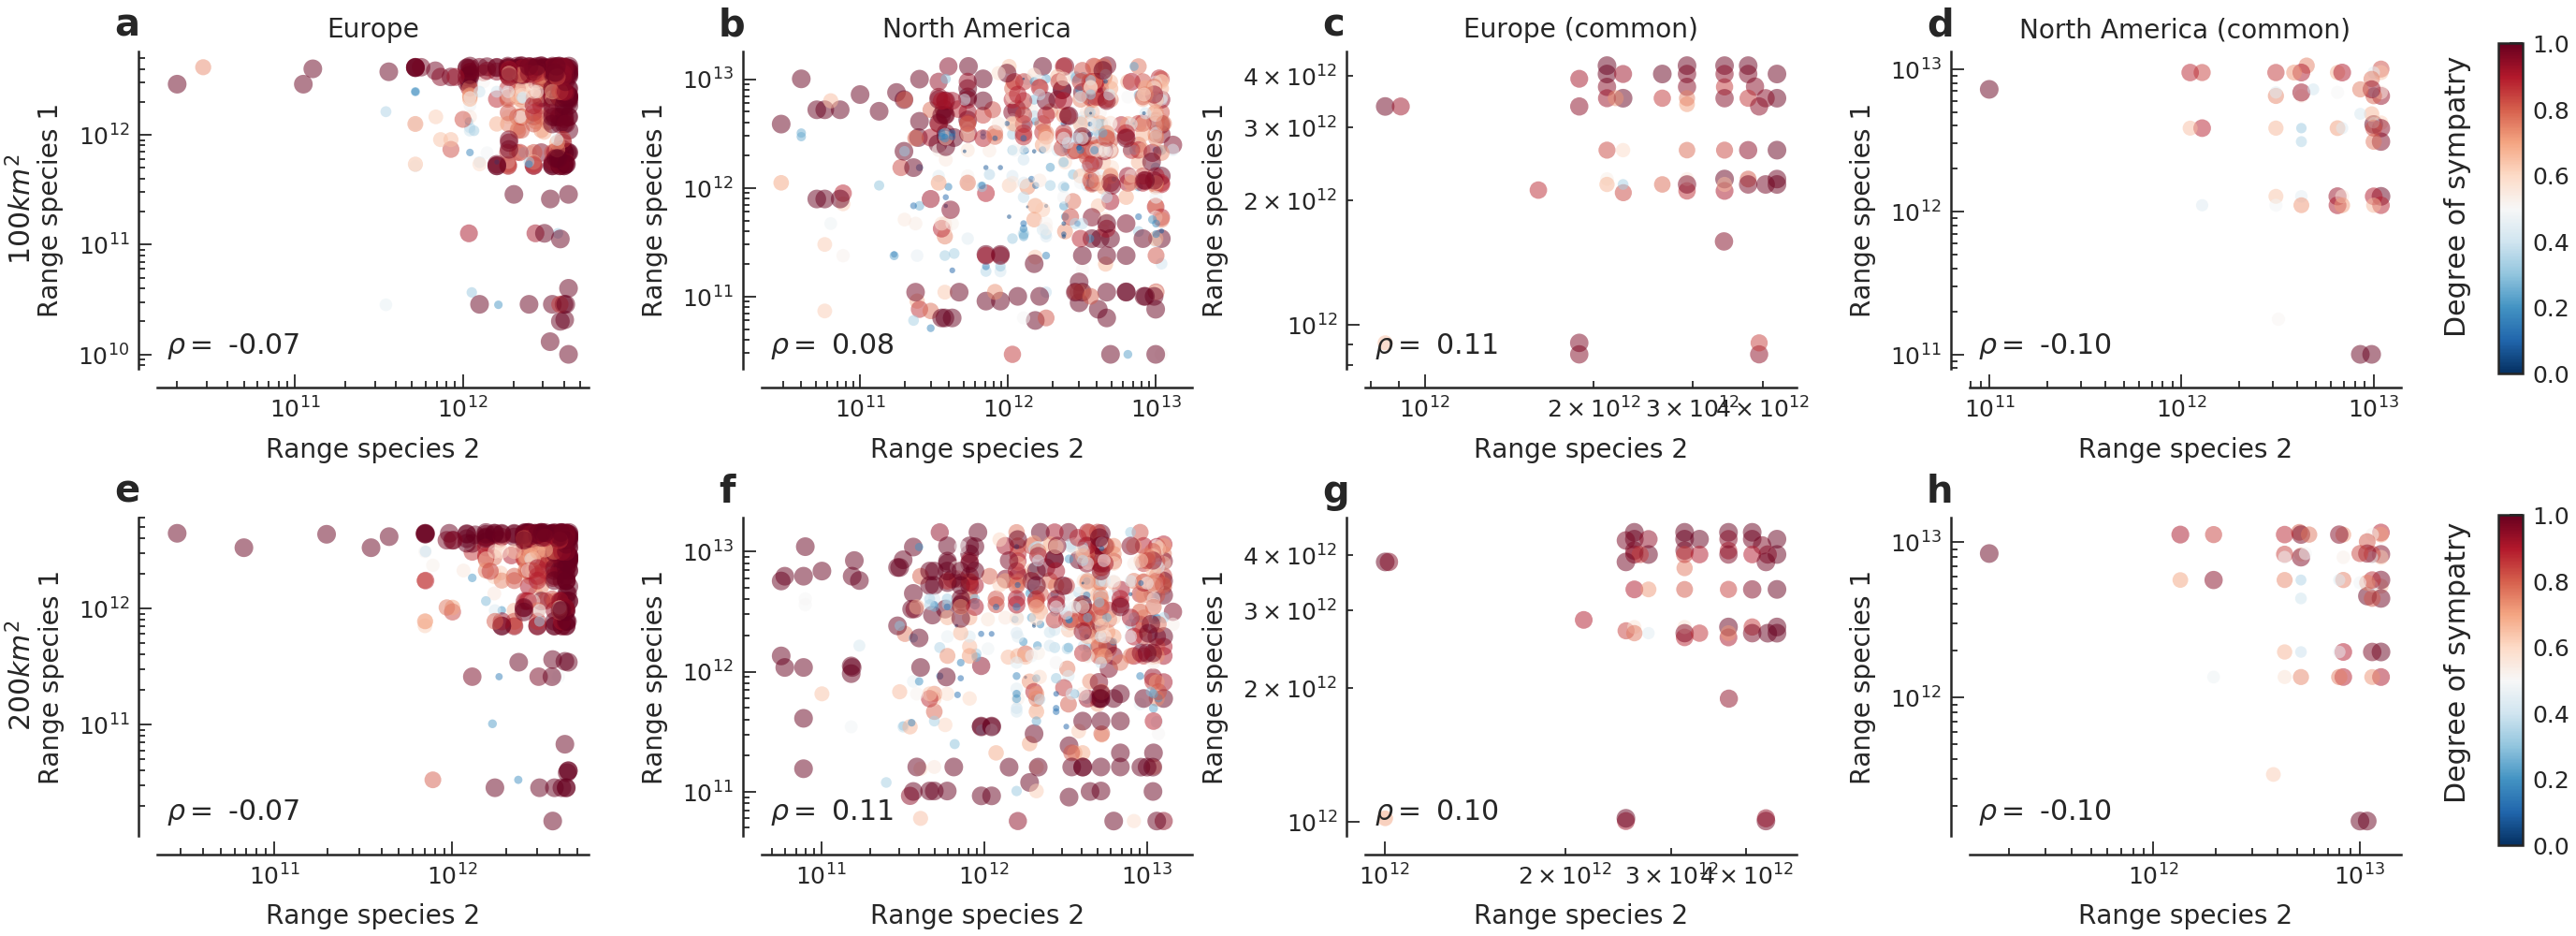

In [878]:
fig, axarr = plt.subplots(2, 4, figsize=stdfigsize(ny=2, nx=4))

df_l = [europe_overlay_100100, north_america_overlay_100100, europe_overlay_100100_common, north_america_overlay_100100_common,
        europe_overlay_200200, north_america_overlay_200200, europe_overlay_200200_common, north_america_overlay_200200_common]

kwargs = dict(lw=0, marker='o', alpha=0.5, legend=False)

c = 0
for ax in axarr.flat:
#     im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap)
    colors=[palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap(i) for i in df_l[c]['sympatry']]
    
    df_l[c][['area_1', 'area_2']].plot.scatter('area_1', 'area_2', ax=ax, **kwargs, s=df_l[c]['sympatry']*400, c=colors)
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_ylabel('Range species 1')
    ax.set_xlabel('Range species 2')
    
        
    ax.annotate('$\\rho=$ {:.2f}'.format(df_l[c][['area_1', 'area_2']].apply(np.log).corr().loc['area_1', 'area_2'].round(3)),
               xy=(0.02,0.05), xycoords='axes fraction', fontsize=30)
    
    ax.annotate(string.ascii_lowercase[c], xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=40, weight='bold')
    
    if c < 4:
        ax.set_title(['Europe', 'North America', 'Europe (common)', 'North America (common)'][c])
    
    separete_axis()
    
    c += 1
    
[axarr[i,0].annotate(['$100km^2$', '$200km^2$'][i], xy=(-0.35, 0.6), xycoords='axes fraction', rotation=90, fontsize=30, weight='bold') for i in range(2)]
[axarr[i,3].annotate('Degree of sympatry', xy=(1.1, 0.92), xycoords='axes fraction', rotation=90, fontsize=30) for i in range(2)]

# im_1 = [axarr[0,i].imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap) for i in range(4)][3]
# im_2 = [axarr[1,i].imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap) for i in range(4)][3]

fig.subplots_adjust(right=0.8)
cbar_ax_1 = fig.add_axes([1.01, 0.6, 0.01, 0.35])
cbar_ax_2 = fig.add_axes([1.01, 0.1, 0.01, 0.35])
fig.colorbar(im_1, cax=cbar_ax_1)
fig.colorbar(im_2, cax=cbar_ax_2)
    
fig.tight_layout()
# fig.savefig('../figures/range_correlation_supl_mat.pdf', bbox_inches='tight')
# fig.savefig('../figures/range_correlation_supl_mat.png', bbox_inches='tight')

## Range correlation figure (border grids)
<a id="range-correlation-figure-border"></a>
<a href="#summary">Summary</a>

In [3]:
common_species = pd.read_table('../results/common_sp_na_eu.dat', names=['species'])
common_species = np.asarray(common_species['species'])

In [4]:
europe_code_sp = pd.read_table('../results/europe/adj_matrix_5050_border_weck4/europe_code_sp.dat')
north_america_code_sp = pd.read_table('../results/north_america/adj_matrix_5050_border_weck4/north_america_code_sp.dat')

In [5]:
occurrences_5050_europe_weck4 = gpd.read_file('../results/europe/adj_matrix_5050_border_weck4/occurrences_within_5050_grid_europe_border_weck4.shp')

occurrences_100100_europe_weck4 = gpd.read_file('../results/europe/adj_matrix_100100_border_weck4/occurrences_within_100100_grid_europe_border_weck4.shp')

occurrences_200200_europe_weck4 = gpd.read_file('../results/europe/adj_matrix_200200_border_weck4/occurrences_within_200200_grid_europe_border_weck4.shp')

In [6]:
occurrences_5050_north_america_weck4 = gpd.read_file('../results/north_america/adj_matrix_5050_border_weck4/occurrences_within_5050_grid_north_america_border_weck4.shp')

occurrences_100100_north_america_weck4 = gpd.read_file('../results/north_america/adj_matrix_100100_border_weck4/occurrences_within_100100_grid_north_america_border_weck4.shp')

occurrences_200200_north_america_weck4 = gpd.read_file('../results/north_america/adj_matrix_200200_border_weck4/occurrences_within_200200_grid_north_america_border_weck4.shp')

In [7]:
(list(europe_code_sp['codes']) == [int(specie.split('_')[0]) for specie in occurrences_5050_europe_weck4.columns[:-3]], 
 list(europe_code_sp['codes']) == [int(specie.split('_')[0]) for specie in occurrences_100100_europe_weck4.columns[:-3]], 
 list(europe_code_sp['codes']) == [int(specie.split('_')[0]) for specie in occurrences_200200_europe_weck4.columns[:-3]],
 list(north_america_code_sp['codes']) == [int(specie.split('_')[0]) for specie in occurrences_5050_north_america_weck4.columns[:-3]],
 list(north_america_code_sp['codes']) == [int(specie.split('_')[0]) for specie in occurrences_100100_north_america_weck4.columns[:-3]],
 list(north_america_code_sp['codes']) == [int(specie.split('_')[0]) for specie in occurrences_200200_north_america_weck4.columns[:-3]]
)

(True, True, True, True, True, True)

In [8]:
occurrences_5050_europe_weck4.columns = ["{}_{}".format(europe_code_sp.loc[row, 'codes'], europe_code_sp.loc[row, 'specie']) for row, column in europe_code_sp.iterrows()] + ['Total', 'grid_code', 'geometry']

occurrences_100100_europe_weck4.columns = ["{}_{}".format(europe_code_sp.loc[row, 'codes'], europe_code_sp.loc[row, 'specie']) for row, column in europe_code_sp.iterrows()] + ['Total', 'grid_code', 'geometry']

occurrences_200200_europe_weck4.columns = ["{}_{}".format(europe_code_sp.loc[row, 'codes'], europe_code_sp.loc[row, 'specie']) for row, column in europe_code_sp.iterrows()] + ['Total', 'grid_code', 'geometry']

occurrences_5050_north_america_weck4.columns = ["{}_{}".format(north_america_code_sp.loc[row, 'codes'], north_america_code_sp.loc[row, 'specie']) for row, column in north_america_code_sp.iterrows()] + ['Total', 'grid_code', 'geometry']

occurrences_100100_north_america_weck4.columns = ["{}_{}".format(north_america_code_sp.loc[row, 'codes'], north_america_code_sp.loc[row, 'specie']) for row, column in north_america_code_sp.iterrows()] + ['Total', 'grid_code', 'geometry']

occurrences_200200_north_america_weck4.columns = ["{}_{}".format(north_america_code_sp.loc[row, 'codes'], north_america_code_sp.loc[row, 'specie']) for row, column in north_america_code_sp.iterrows()] + ['Total', 'grid_code', 'geometry']

In [9]:
def sp_polygon_from_grids(df):

    l = []
    for sp in df.columns[df.columns.str.contains('^[0-9]')]:
        gdf_tmp = df[df[sp] == 1].dissolve(sp)[['geometry']].reset_index(drop=True)
        gdf_tmp['area']   = gdf_tmp.area
        gdf_tmp['specie'] = sp.split('_')[1]
        gdf_tmp['genus']  = sp.split('_')[1].split()[0]
        l.append(gdf_tmp)
    return pd.concat(l).reset_index(drop=True)

In [10]:
europe_sp_5050   = sp_polygon_from_grids(occurrences_5050_europe_weck4)
europe_sp_100100 = sp_polygon_from_grids(occurrences_100100_europe_weck4)
europe_sp_200200 = sp_polygon_from_grids(occurrences_200200_europe_weck4)

In [11]:
north_america_sp_5050   = sp_polygon_from_grids(occurrences_5050_north_america_weck4)
north_america_sp_100100 = sp_polygon_from_grids(occurrences_100100_north_america_weck4)
north_america_sp_200200 = sp_polygon_from_grids(occurrences_200200_north_america_weck4)

In [12]:
common_sp_na_eu = pd.read_table('../results/common_sp_na_eu.dat', names=['specie'])

In [13]:
europe_sp_5050_common   = europe_sp_5050[europe_sp_5050['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)
europe_sp_100100_common = europe_sp_100100[europe_sp_100100['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)
europe_sp_200200_common = europe_sp_200200[europe_sp_200200['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)

In [14]:
north_america_sp_5050_common   = north_america_sp_5050[north_america_sp_5050['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)
north_america_sp_100100_common = north_america_sp_100100[north_america_sp_100100['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)
north_america_sp_200200_common = north_america_sp_200200[north_america_sp_200200['specie'].isin(common_sp_na_eu['specie'])].reset_index(drop=True)

In [17]:
europe_overlay_5050   = species_overlay(europe_sp_5050)
europe_overlay_100100 = species_overlay(europe_sp_100100)
europe_overlay_200200 = species_overlay(europe_sp_200200)

europe_overlay_5050_common   = species_overlay(europe_sp_5050_common)
europe_overlay_100100_common = species_overlay(europe_sp_100100_common)
europe_overlay_200200_common = species_overlay(europe_sp_200200_common)

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [18]:
north_america_overlay_5050   = species_overlay(north_america_sp_5050)
north_america_overlay_100100 = species_overlay(north_america_sp_100100)
north_america_overlay_200200 = species_overlay(north_america_sp_200200)

north_america_overlay_5050_common   = species_overlay(north_america_sp_5050_common)
north_america_overlay_100100_common = species_overlay(north_america_sp_100100_common)
north_america_overlay_200200_common = species_overlay(north_america_sp_200200_common)

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



We are going to do the bootstrap for each value of sympatry.

In [594]:
# europe_overlay_5050.to_file('../results/europe/overlay/5050_weck4/erope_overlay_5050.shp')
# europe_overlay_100100.to_file('../results/europe/overlay/100100_weck4/erope_overlay_100100.shp')
# europe_overlay_200200.to_file('../results/europe/overlay/200200_weck4/erope_overlay_200200.shp')

# europe_overlay_5050_common.to_file('../results/europe/overlay/5050_common_weck4/erope_overlay_5050_common.shp')
# europe_overlay_100100_common.to_file('../results/europe/overlay/100100_common_weck4/erope_overlay_100100_common.shp')
# europe_overlay_200200_common.to_file('../results/europe/overlay/200200_common_weck4/erope_overlay_200200_common.shp')

In [595]:
# north_america_overlay_5050.to_file('../results/north_america/overlay/5050_weck4/erope_overlay_5050.shp')
# north_america_overlay_100100.to_file('../results/north_america/overlay/100100_weck4/erope_overlay_100100.shp')
# north_america_overlay_200200.to_file('../results/north_america/overlay/200200_weck4/erope_overlay_200200.shp')

# north_america_overlay_5050_common.to_file('../results/north_america/overlay/5050_common_weck4/erope_overlay_5050_common.shp')
# north_america_overlay_100100_common.to_file('../results/north_america/overlay/100100_common_weck4/erope_overlay_100100_common.shp')
# north_america_overlay_200200_common.to_file('../results/north_america/overlay/200200_common_weck4/erope_overlay_200200_common.shp')

In [575]:
# Pearson coefficient for the original data
# pearson_data = df_data[cols].apply(np.log).corr().loc[cols[0], cols[1]]

# function params
df_data = europe_overlay_5050
order = 'greater'

# range correlation bootstrap sympatry
def rcbs(df_data, order):
    # columns to use
    cols = ['area_1', 'area_2']

    pearson_boot_dict = {}
    # loop through the sympatry values
    for s in np.arange(0, 1.1, 0.1):
        if order == 'greater':
            # filtering the data considering the sympatry value
            df_tmp = df_data[df_data['sympatry'] >= s]

        elif order == 'less':
            df_tmp = df_data[df_data['sympatry'] <= s]
            
        else:
            raise ValueError('unknown order value: {}'.format(order)) 

        # list to append the pearson coefficient 
        # that comes from the bootstrap sample
        pearson_boot_l = []
        # bootstrap: 1000 realisations
        for _ in range(1000):

            # new distribution
            df_boot = pd.DataFrame(bootstrap_resample(np.asarray(df_tmp[cols].apply(np.log))), columns=cols)
            # Pearson coefficient for the new distribution
            pearson_boot_l.append(df_boot.corr().loc[cols[0], cols[1]])

        # create an entry in the dictionary
        pearson_boot_dict[s] = pearson_boot_l
    
    df_final = pd.DataFrame(pearson_boot_dict)
    df_final.columns = np.arange(0,110,10)/100
    return df_final

In [729]:
def pearson(data):
    """
    Calculates the Pearson correlation coefficient.
    Parameters
    ----------
    data: two-columns numpy array
    ----------
    Returns Pearson.
    """
    data=data.transpose()
    pea=scipy.stats.pearsonr(data[0],data[1])
    return(pea)

def spearman(data):
    """
    Calculates the Pearson correlation coefficient.
    Parameters
    ----------
    data: two-columns numpy array
    ----------
    Returns Pearson.
    """
    data=data.transpose()
    pea=scipy.stats.spearmanr(data[0],data[1])
    return(pea)

def rcbs(df, order, f=pearson):
    if order == 'greater':
        df = pd.DataFrame([bootstrap_function(np.asarray(df[df['sympatry'] >= s][cols].apply(np.log)), f) for s in np.arange(0, 1.1, 0.1)], columns=['{}'.format(f), 'inf', 'sup'], index=np.arange(0,110,10))
    elif order == 'less':
        df = pd.DataFrame([bootstrap_function(np.asarray(df[df['sympatry'] <= s][cols].apply(np.log)), f) for s in np.arange(0, 1.1, 0.1)], columns=['{}'.format(f), 'inf', 'sup'], index=np.arange(0,110,10))
    else:
        raise ValueError('unknown order value: {}'.format(order))
    
    return df

In [721]:
europe_overlay_5050_spearman   = bootstrap_function(np.asarray(europe_overlay_5050[cols].apply(np.log)), spearman)
europe_overlay_100100_spearman = bootstrap_function(np.asarray(europe_overlay_100100[cols].apply(np.log)), spearman)
europe_overlay_200200_spearman = bootstrap_function(np.asarray(europe_overlay_200200[cols].apply(np.log)), spearman)

europe_overlay_5050_common_spearman   = bootstrap_function(np.asarray(europe_overlay_5050_common[cols].apply(np.log)), spearman)
europe_overlay_100100_common_spearman = bootstrap_function(np.asarray(europe_overlay_100100_common[cols].apply(np.log)), spearman)
europe_overlay_200200_common_spearman = bootstrap_function(np.asarray(europe_overlay_200200_common[cols].apply(np.log)), spearman)

In [722]:
north_america_overlay_5050_spearman   = bootstrap_function(np.asarray(north_america_overlay_5050[cols].apply(np.log)), spearman)
north_america_overlay_100100_spearman = bootstrap_function(np.asarray(north_america_overlay_100100[cols].apply(np.log)), spearman)
north_america_overlay_200200_spearman = bootstrap_function(np.asarray(north_america_overlay_200200[cols].apply(np.log)), spearman)

north_america_overlay_5050_common_spearman   = bootstrap_function(np.asarray(north_america_overlay_5050_common[cols].apply(np.log)), spearman)
north_america_overlay_100100_common_spearman = bootstrap_function(np.asarray(north_america_overlay_100100_common[cols].apply(np.log)), spearman)
north_america_overlay_200200_common_spearman = bootstrap_function(np.asarray(north_america_overlay_200200_common[cols].apply(np.log)), spearman)

In [617]:
boot_inc_sympatry_greater_europe_5050   = rcbs(europe_overlay_5050,   order='greater')
boot_inc_sympatry_greater_europe_100100 = rcbs(europe_overlay_100100, order='greater')
boot_inc_sympatry_greater_europe_200200 = rcbs(europe_overlay_200200, order='greater')

boot_inc_sympatry_greater_europe_5050_common   = rcbs(europe_overlay_5050_common,   order='greater')
boot_inc_sympatry_greater_europe_100100_common = rcbs(europe_overlay_100100_common, order='greater')
boot_inc_sympatry_greater_europe_200200_common = rcbs(europe_overlay_200200_common, order='greater')

boot_inc_sympatry_less_europe_5050   = rcbs(europe_overlay_5050,   order='less')
boot_inc_sympatry_less_europe_100100 = rcbs(europe_overlay_100100, order='less')
boot_inc_sympatry_less_europe_200200 = rcbs(europe_overlay_200200, order='less')

boot_inc_sympatry_less_europe_5050_common   = rcbs(europe_overlay_5050_common,   order='less')
boot_inc_sympatry_less_europe_100100_common = rcbs(europe_overlay_100100_common, order='less')
boot_inc_sympatry_less_europe_200200_common = rcbs(europe_overlay_200200_common, order='less')

/home/dsvieira/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/dsvieira/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/dsvieira/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/dsvieira/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dsvieira/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()


In [618]:
boot_inc_sympatry_greater_north_america_5050   = rcbs(north_america_overlay_5050,   order='greater')
boot_inc_sympatry_greater_north_america_100100 = rcbs(north_america_overlay_100100, order='greater')
boot_inc_sympatry_greater_north_america_200200 = rcbs(north_america_overlay_200200, order='greater')

boot_inc_sympatry_greater_north_america_5050_common   = rcbs(north_america_overlay_5050_common,   order='greater')
boot_inc_sympatry_greater_north_america_100100_common = rcbs(north_america_overlay_100100_common, order='greater')
boot_inc_sympatry_greater_north_america_200200_common = rcbs(north_america_overlay_200200_common, order='greater')

boot_inc_sympatry_less_north_america_5050   = rcbs(north_america_overlay_5050,   order='less')
boot_inc_sympatry_less_north_america_100100 = rcbs(north_america_overlay_100100, order='less')
boot_inc_sympatry_less_north_america_200200 = rcbs(north_america_overlay_200200, order='less')

boot_inc_sympatry_less_north_america_5050_common   = rcbs(north_america_overlay_5050_common,   order='less')
boot_inc_sympatry_less_north_america_100100_common = rcbs(north_america_overlay_100100_common, order='less')
boot_inc_sympatry_less_north_america_200200_common = rcbs(north_america_overlay_200200_common, order='less')

In [23]:
# df = north_america_overlay_5050
def spearman_sympatry(df, order, perc_filter=0.3):
    # columns to use
    cols = ['area_1', 'area_2']
    if order == 'greater':
        df_size = pd.DataFrame([df[df['sympatry'] >= 1-s].shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['size'])
        df_perc = pd.DataFrame([df[df['sympatry'] >= 1-s].shape[0]/df.shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['perc'])
        df_spea = pd.DataFrame([np.asarray(spearman(np.asarray(df[df['sympatry'] >= 1-s][cols].apply(np.log)))) for s in np.arange(0, 1.1, 0.1)], columns=['spearman', 'pvalue'], index=np.arange(0,110,10)/100).reset_index()
        df = pd.concat([df_spea, df_size, df_perc], axis=1).dropna()
        df = df[df['perc'] >= perc_filter]
    elif order == 'less':
        df_size = pd.DataFrame([df[df['sympatry'] <= s].shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['size'])
        df_perc = pd.DataFrame([df[df['sympatry'] <= s].shape[0]/df.shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['perc'])
        df_spea = pd.DataFrame([np.asarray(spearman(np.asarray(df[df['sympatry'] <= s][cols].apply(np.log)))) for s in np.arange(0, 1.1, 0.1)], columns=['spearman', 'pvalue'], index=np.arange(0,110,10)/100).reset_index()
        df = pd.concat([df_spea, df_size, df_perc], axis=1).dropna()
        df = df[df['perc'] >= perc_filter]
    else:
        raise ValueError('unknown order value: {}'.format(order))
        
    return df

In [24]:
europe_overlay_5050_greater_sympatry_spearman   = spearman_sympatry(europe_overlay_5050, order='greater')
europe_overlay_100100_greater_sympatry_spearman = spearman_sympatry(europe_overlay_100100, order='greater')
europe_overlay_200200_greater_sympatry_spearman = spearman_sympatry(europe_overlay_200200, order='greater')

europe_overlay_5050_less_sympatry_spearman   = spearman_sympatry(europe_overlay_5050, order='less')
europe_overlay_100100_less_sympatry_spearman = spearman_sympatry(europe_overlay_100100, order='less')
europe_overlay_200200_less_sympatry_spearman = spearman_sympatry(europe_overlay_200200, order='less')

europe_overlay_5050_common_greater_sympatry_spearman   = spearman_sympatry(europe_overlay_5050_common, order='greater')
europe_overlay_100100_common_greater_sympatry_spearman = spearman_sympatry(europe_overlay_100100_common, order='greater')
europe_overlay_200200_common_greater_sympatry_spearman = spearman_sympatry(europe_overlay_200200_common, order='greater')

europe_overlay_5050_common_less_sympatry_spearman   = spearman_sympatry(europe_overlay_5050_common, order='less')
europe_overlay_100100_common_less_sympatry_spearman = spearman_sympatry(europe_overlay_100100_common, order='less')
europe_overlay_200200_common_less_sympatry_spearman = spearman_sympatry(europe_overlay_200200_common, order='less')

In [26]:
north_america_overlay_5050_greater_sympatry_spearman   = spearman_sympatry(north_america_overlay_5050, order='greater')
north_america_overlay_100100_greater_sympatry_spearman = spearman_sympatry(north_america_overlay_100100, order='greater')
north_america_overlay_200200_greater_sympatry_spearman = spearman_sympatry(north_america_overlay_200200, order='greater')

north_america_overlay_5050_less_sympatry_spearman   = spearman_sympatry(north_america_overlay_5050, order='less')
north_america_overlay_100100_less_sympatry_spearman = spearman_sympatry(north_america_overlay_100100, order='less')
north_america_overlay_200200_less_sympatry_spearman = spearman_sympatry(north_america_overlay_200200, order='less')

north_america_overlay_5050_common_greater_sympatry_spearman   = spearman_sympatry(north_america_overlay_5050_common, order='greater')
north_america_overlay_100100_common_greater_sympatry_spearman = spearman_sympatry(north_america_overlay_100100_common, order='greater')
north_america_overlay_200200_common_greater_sympatry_spearman = spearman_sympatry(north_america_overlay_200200_common, order='greater')

north_america_overlay_5050_common_less_sympatry_spearman   = spearman_sympatry(north_america_overlay_5050_common, order='less')
north_america_overlay_100100_common_less_sympatry_spearman = spearman_sympatry(north_america_overlay_100100_common, order='less')
north_america_overlay_200200_common_less_sympatry_spearman = spearman_sympatry(north_america_overlay_200200_common, order='less')

/home/dsvieira/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/dsvieira/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/dsvieira/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/dsvieira/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/dsvieira/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [30]:
europe_overlay_5050_greater_sympatry_spearman

index  spearman        pvalue  size      perc
1     0.1 -0.402409  1.847870e-09   207  0.550532
2     0.2 -0.308526  6.172965e-07   251  0.667553
3     0.3 -0.234926  6.024589e-05   286  0.760638
4     0.4 -0.193254  5.745951e-04   314  0.835106
5     0.5 -0.174779  1.341508e-03   334  0.888298
6     0.6 -0.148900  5.798530e-03   342  0.909574
7     0.7 -0.125814  1.739219e-02   357  0.949468
8     0.8 -0.093268  7.433428e-02   367  0.976064
9     0.9 -0.080650  1.194660e-01   374  0.994681
10    1.0 -0.072235  1.621573e-01   376  1.000000

In [31]:
europe_overlay_5050_less_sympatry_spearman

index  spearman    pvalue  size      perc
8     0.8  0.158533  0.077424   125  0.332447
9     0.9  0.158097  0.040078   169  0.449468
10    1.0 -0.051829  0.320763   369  0.981383

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


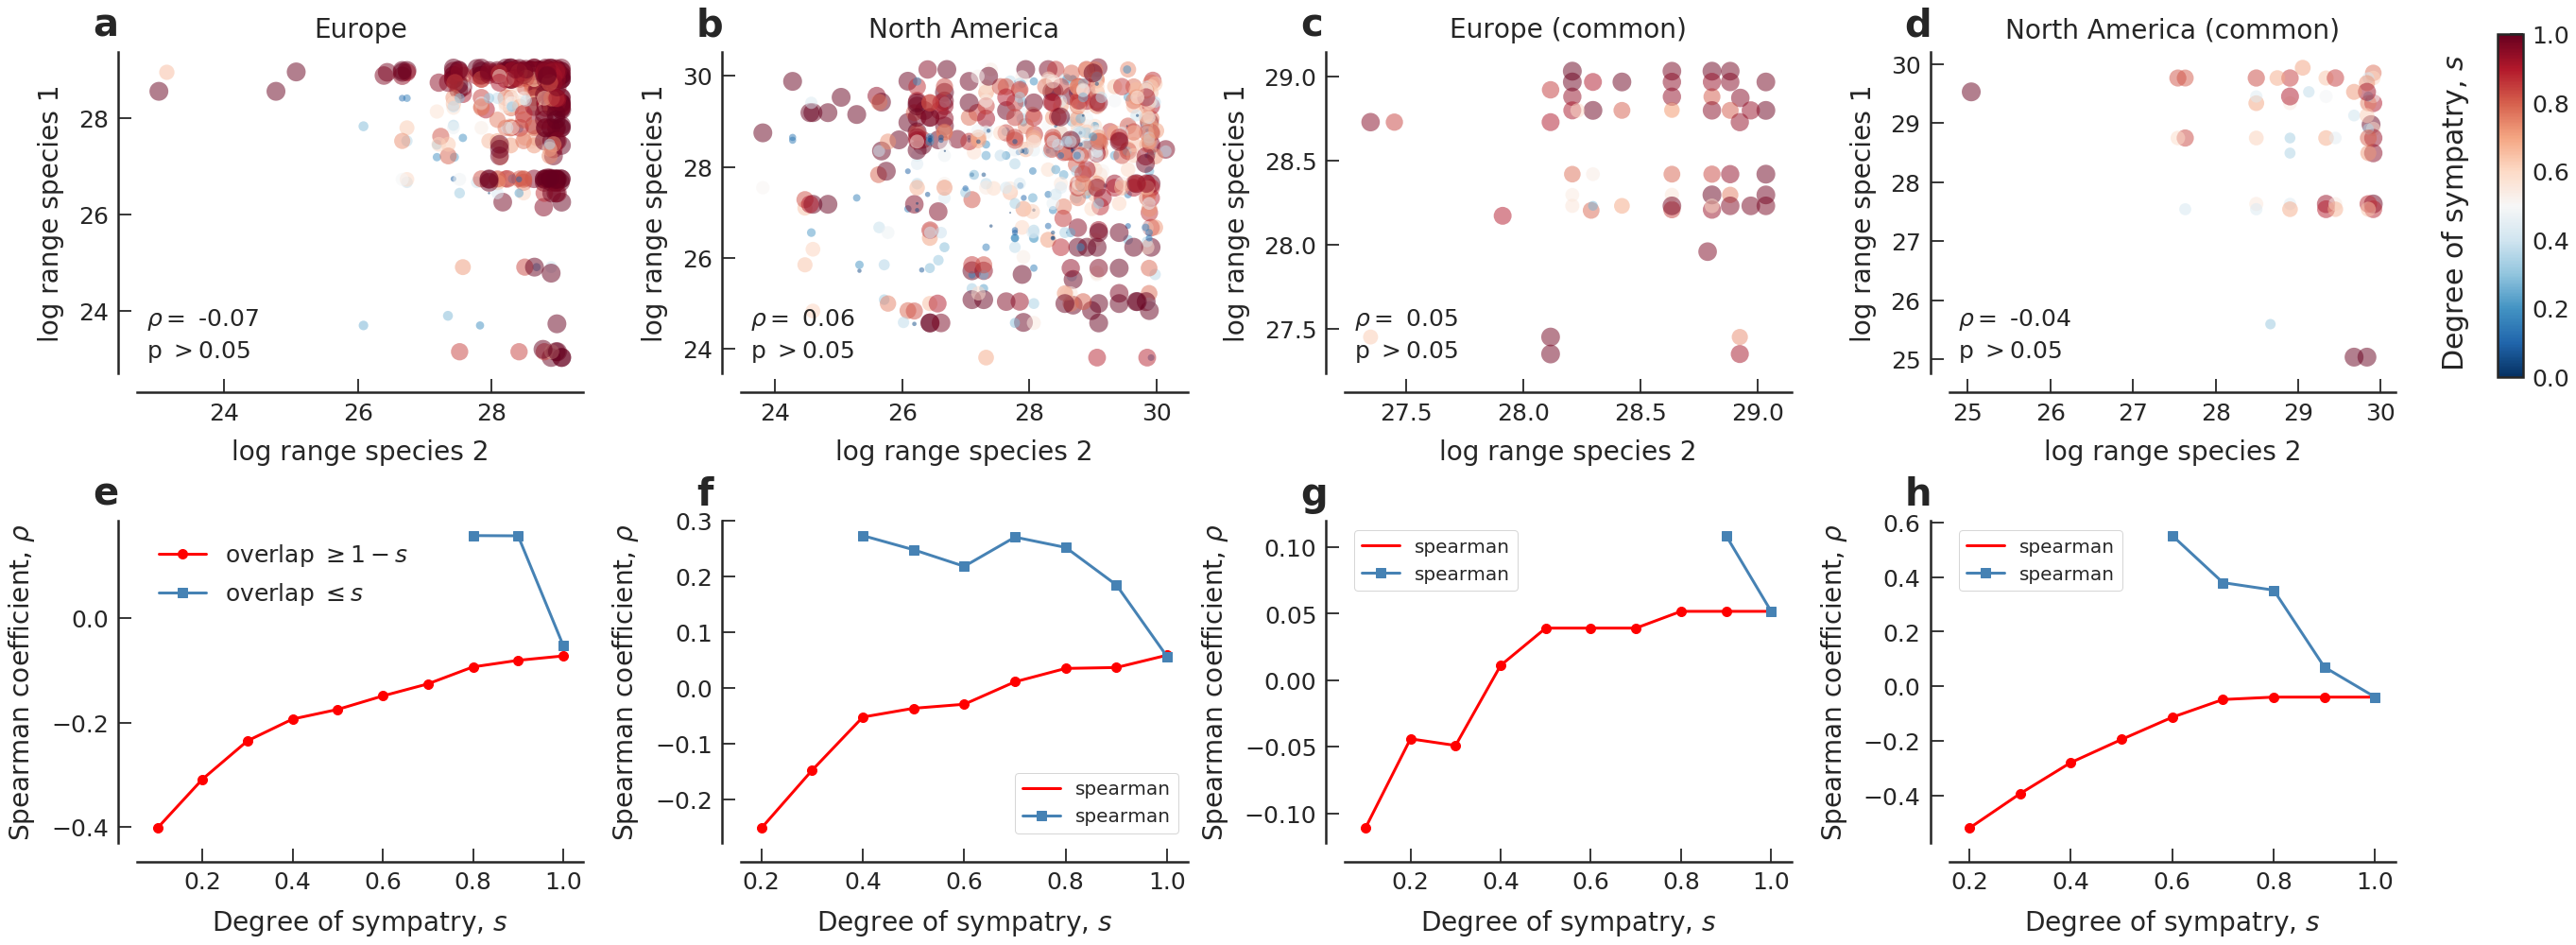

In [29]:
fig, ax = plt.subplots(2, 4, figsize=stdfigsize(ny=2, nx=4))

df_l  = [europe_overlay_5050, north_america_overlay_5050, europe_overlay_5050_common, north_america_overlay_5050_common]

df_sg = [europe_overlay_5050_greater_sympatry_spearman, north_america_overlay_5050_greater_sympatry_spearman, europe_overlay_5050_common_greater_sympatry_spearman, north_america_overlay_5050_common_greater_sympatry_spearman]

df_sl = [europe_overlay_5050_less_sympatry_spearman, north_america_overlay_5050_less_sympatry_spearman, europe_overlay_5050_common_less_sympatry_spearman, north_america_overlay_5050_common_less_sympatry_spearman]

kwargs = dict(lw=0, marker='o', alpha=0.5, legend=False)

color_s = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors
kwargs_sg = dict(lw=3, marker='o', markersize=10, color='red')#color_s[2], legend=False)
kwargs_sl = dict(lw=3, marker='s', markersize=10, color='steelblue')#color_s[-2], legend=False)


c = 0
for ax in ax.flat:
    if c < 4:
#         im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap)
        colors=[palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap(i) for i in df_l[c]['sympatry']]
    
    
        df_l[c][['area_1', 'area_2']].apply(np.log).plot.scatter('area_1', 'area_2', ax=ax, **kwargs, s=df_l[c]['sympatry']*400, c=colors)
#         ax.set_yscale('log')
#         ax.set_xscale('log')

        ax.set_ylabel('log range species 1')
        ax.set_xlabel('log range species 2')
    
        ax.set_title(['Europe', 'North America', 'Europe (common)', 'North America (common)'][c])
        
        boot_spearman = bootstrap_function(np.asarray(df_l[c][['area_1', 'area_2']].apply(np.log)), spearman)
        ax.annotate('$\\rho=$ {:.2f}'.format(boot_spearman[0][0]), xy=(0.02,0.15), xycoords='axes fraction', fontsize=25)
#         ax.annotate('CI 95%: {:.2f}-{:.2f}'.format(boot_spearman[1], boot_spearman[2]), xy=(0.02,0.10), xycoords='axes fraction', fontsize=20)
        ax.annotate('p $> 0.05$', xy=(0.02,0.05), xycoords='axes fraction', fontsize=25)
#         ax.annotate('$\\rho=$ {:.2f}'.format(df_l[c][['area_1', 'area_2']].apply(np.log).corr().loc['area_1', 'area_2'].round(3)),
#                    xy=(0.02,0.05), xycoords='axes fraction', fontsize=30)
        
        if c == 3:
            ax.annotate('Degree of sympatry, $s$', xy=(1.1, 0.92), xycoords='axes fraction', rotation=90, fontsize=30)
    
    else:
        df_sg[c-4].plot('index', 'spearman', ax=ax, **kwargs_sg)
        df_sl[c-4].plot('index', 'spearman', ax=ax, **kwargs_sl)
        
        ax.set_xlabel('Degree of sympatry, $s$')
        ax.set_ylabel('Spearman coefficient, $\\rho$')
        
        if c == 4:
            ax.legend(['overlap $\\geq 1-s$', 'overlap $\\leq s$'], fontsize=25, frameon=False)
    
    ax.annotate(string.ascii_lowercase[c], xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=40, weight='bold')
    
    for loc, spine in ax.spines.items():
        if loc in ['left', 'bottom']:
            spine.set_position(('outward', 20)) # outward by 20 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)
    
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    c += 1
    


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0.60, 0.01, 0.36])
fig.colorbar(im, cax=cbar_ax)
    
fig.tight_layout()
# fig.savefig('../figures/range_correlation_spearman.pdf', bbox_inches='tight')
# fig.savefig('../figures/range_correlation_spearman.png', bbox_inches='tight')

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


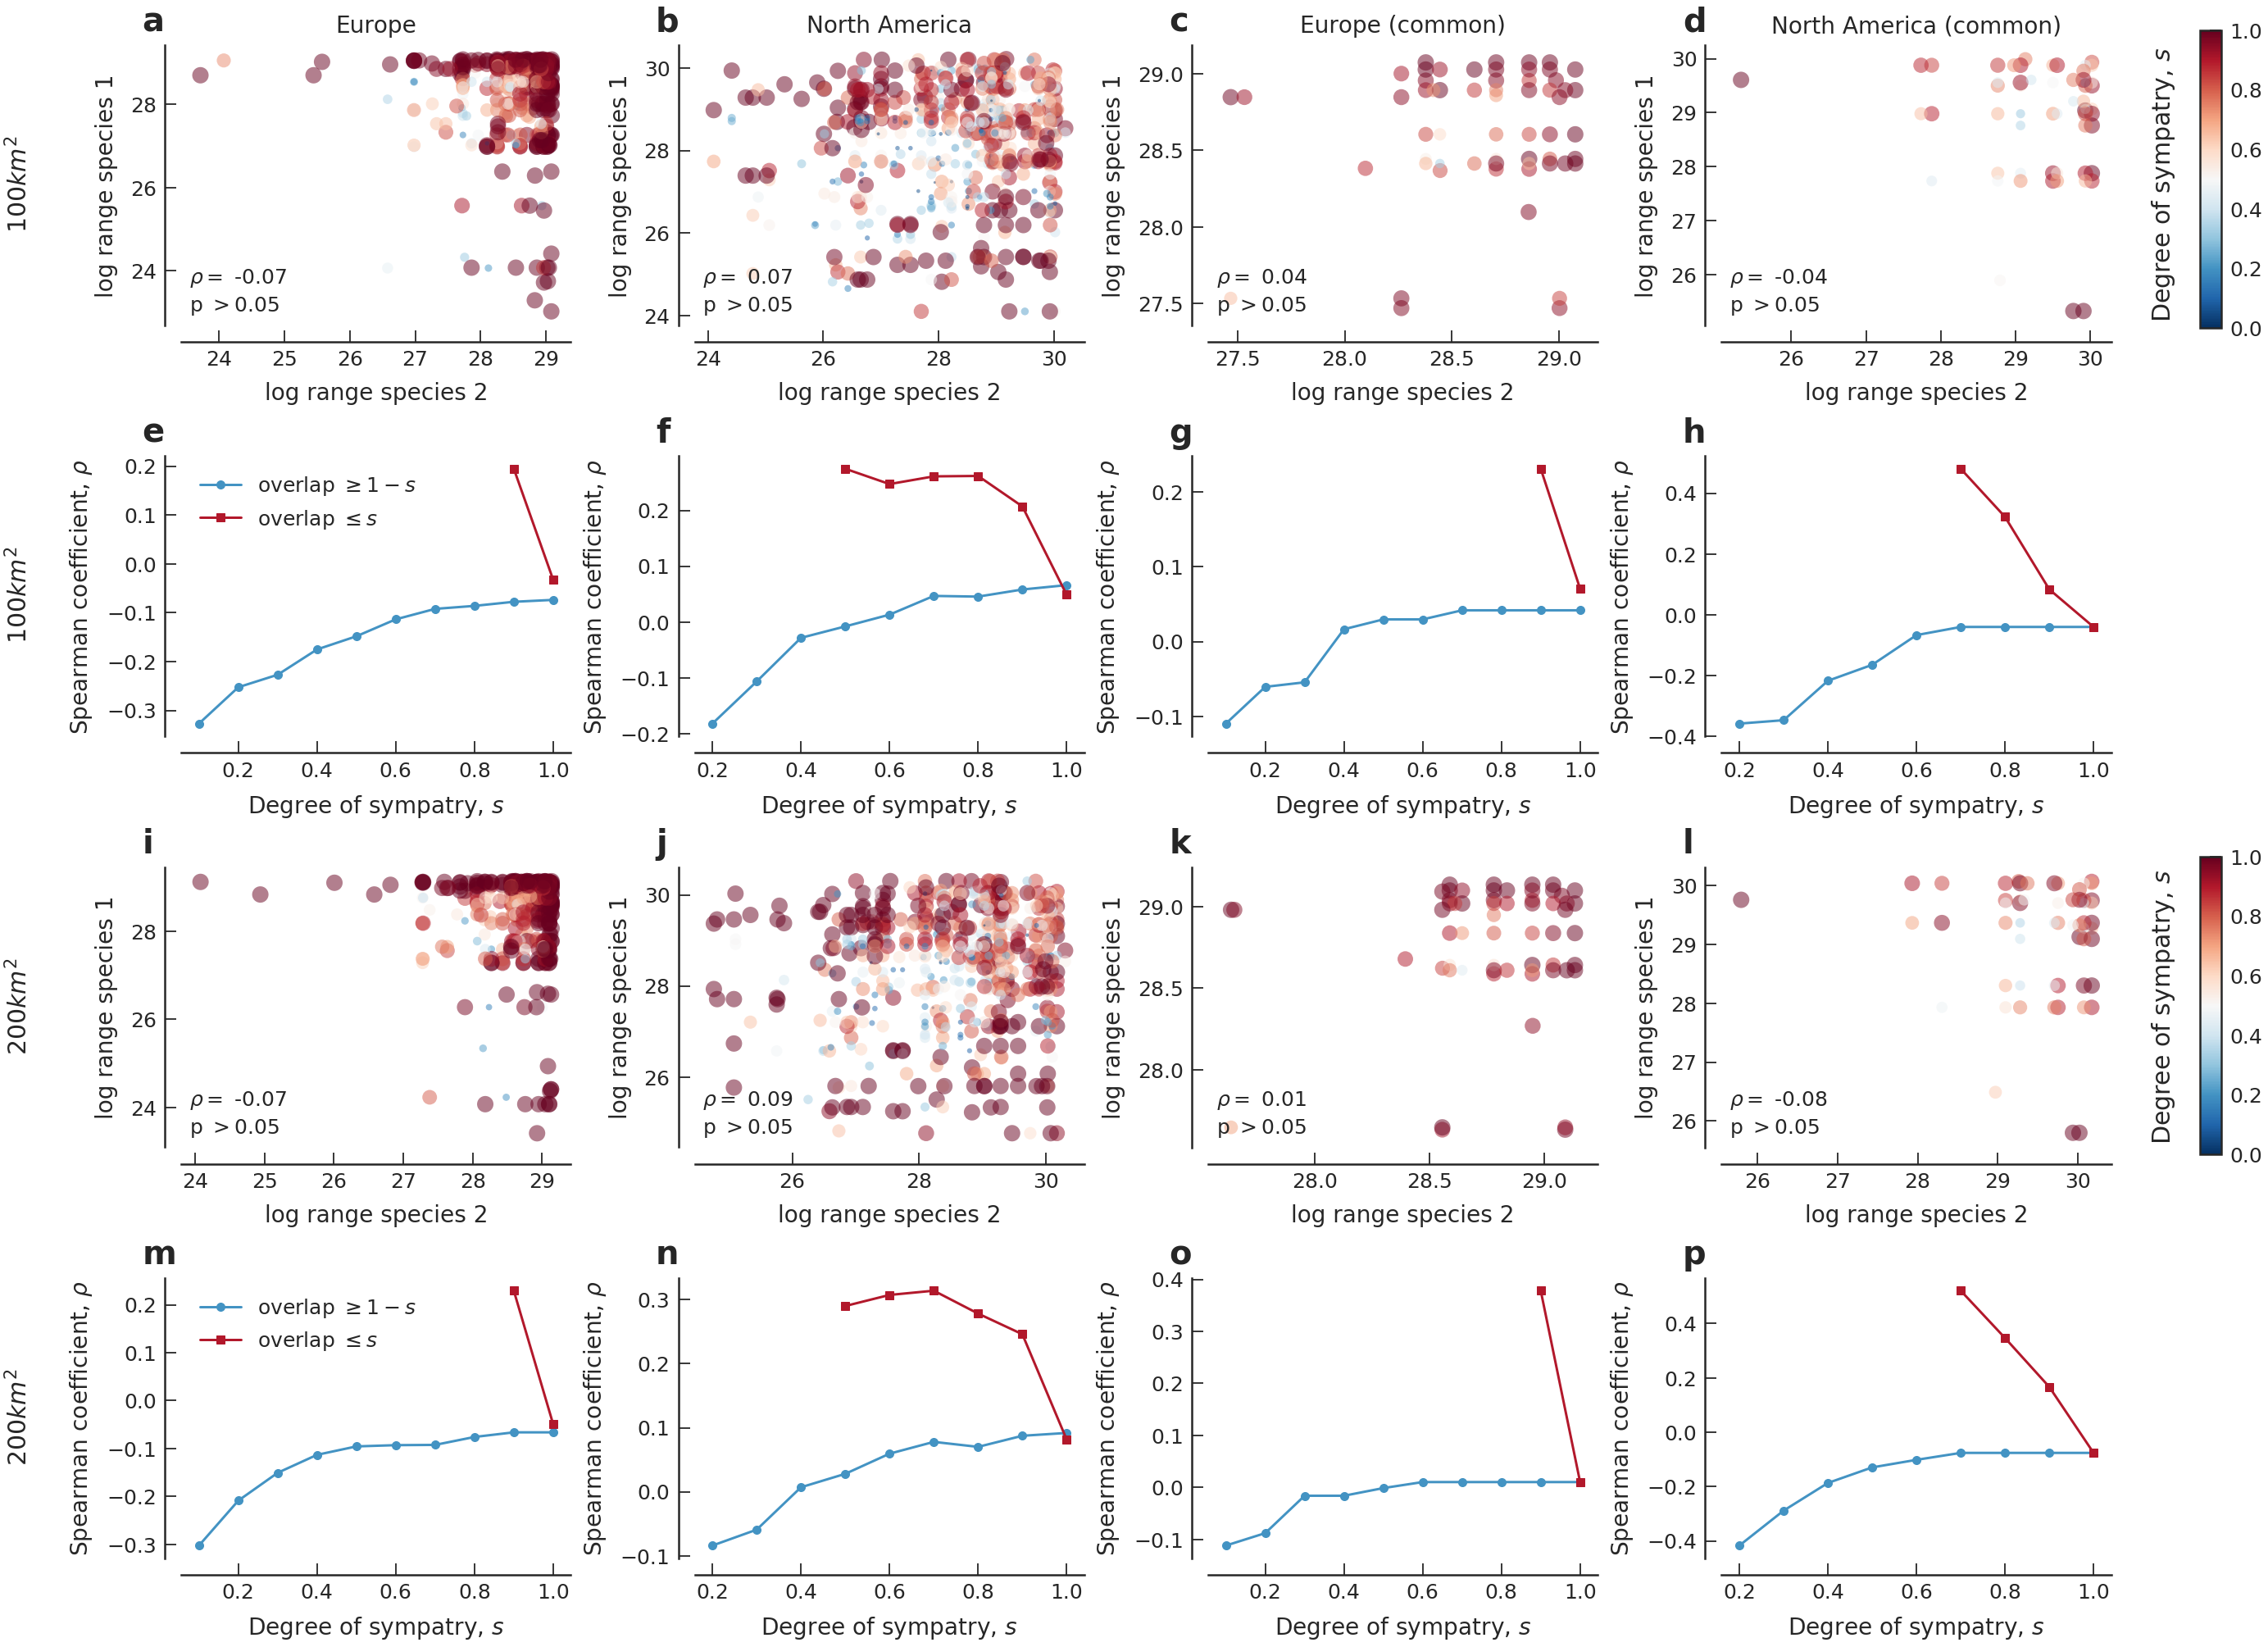

In [963]:
fig, axarr = plt.subplots(4, 4, figsize=stdfigsize(ny=4, nx=4))

df_l = [europe_overlay_100100, north_america_overlay_100100, europe_overlay_100100_common, north_america_overlay_100100_common,
        europe_overlay_200200, north_america_overlay_200200, europe_overlay_200200_common, north_america_overlay_200200_common]

df_sg = [
    europe_overlay_100100_greater_sympatry_spearman, north_america_overlay_100100_greater_sympatry_spearman,
    europe_overlay_100100_common_greater_sympatry_spearman, north_america_overlay_100100_common_greater_sympatry_spearman,
    europe_overlay_200200_greater_sympatry_spearman, north_america_overlay_200200_greater_sympatry_spearman,
    europe_overlay_200200_common_greater_sympatry_spearman, north_america_overlay_200200_common_greater_sympatry_spearman
        ]

df_sl = [
    europe_overlay_100100_less_sympatry_spearman, north_america_overlay_100100_less_sympatry_spearman,
    europe_overlay_100100_common_less_sympatry_spearman, north_america_overlay_100100_common_less_sympatry_spearman,
    europe_overlay_200200_less_sympatry_spearman, north_america_overlay_200200_less_sympatry_spearman,
    europe_overlay_200200_common_less_sympatry_spearman, north_america_overlay_200200_common_less_sympatry_spearman
        ]


kwargs = dict(lw=0, marker='o', alpha=0.5, legend=False)

color_s = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors
kwargs_sg = dict(lw=3, marker='o', markersize=10, color=color_s[2], legend=False)
kwargs_sl = dict(lw=3, marker='s', markersize=10, color=color_s[-2], legend=False)

c = 0
for ax in axarr.flat:
    if c < 4:
    #     im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap)
        colors=[palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap(i) for i in df_l[c]['sympatry']]

        df_l[c][['area_1', 'area_2']].apply(np.log).plot.scatter('area_1', 'area_2', ax=ax, **kwargs, s=df_l[c]['sympatry']*400, c=colors)
#         ax.set_yscale('log')
#         ax.set_xscale('log')

        ax.set_ylabel('log range species 1')
        ax.set_xlabel('log range species 2')

        boot_spearman = bootstrap_function(np.asarray(df_l[c][['area_1', 'area_2']].apply(np.log)), spearman)
        ax.annotate('$\\rho=$ {:.2f}'.format(boot_spearman[0][0]), xy=(0.02,0.15), xycoords='axes fraction', fontsize=25)
#         ax.annotate('CI 95%: {:.2f}-{:.2f}'.format(boot_spearman[1], boot_spearman[2]), xy=(0.02,0.10), xycoords='axes fraction', fontsize=20)
        ax.annotate('p $> 0.05$', xy=(0.02,0.05), xycoords='axes fraction', fontsize=25)
#         ax.annotate('$\\rho=$ {:.2f}'.format(df_l[c][['area_1', 'area_2']].apply(np.log).corr().loc['area_1', 'area_2'].round(3)),
#                    xy=(0.02,0.05), xycoords='axes fraction', fontsize=30)
    
    elif c > 3 and c < 8:
        df_sg[c-4].plot('index', 'spearman', ax=ax, **kwargs_sg)
        df_sl[c-4].plot('index', 'spearman', ax=ax, **kwargs_sl)
        
        ax.set_xlabel('Degree of sympatry, $s$')
        ax.set_ylabel('Spearman coefficient, $\\rho$')
        
        if c == 4:
            ax.legend(['overlap $\\geq 1-s$', 'overlap $\\leq s$'], fontsize=25, frameon=False)
    
    elif c > 7 and c < 12:
    #     im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap)
        colors=[palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap(i) for i in df_l[c-4]['sympatry']]

        df_l[c-4][['area_1', 'area_2']].apply(np.log).plot.scatter('area_1', 'area_2', ax=ax, **kwargs, s=df_l[c-4]['sympatry']*400, c=colors)
#         ax.set_yscale('log')
#         ax.set_xscale('log')

        ax.set_ylabel('log range species 1')
        ax.set_xlabel('log range species 2')

        boot_spearman = bootstrap_function(np.asarray(df_l[c-4][['area_1', 'area_2']].apply(np.log)), spearman)
        ax.annotate('$\\rho=$ {:.2f}'.format(boot_spearman[0][0]), xy=(0.02,0.15), xycoords='axes fraction', fontsize=25)
#         ax.annotate('CI 95%: {:.2f}-{:.2f}'.format(boot_spearman[1], boot_spearman[2]), xy=(0.02,0.10), xycoords='axes fraction', fontsize=20)
        ax.annotate('p $> 0.05$', xy=(0.02,0.05), xycoords='axes fraction', fontsize=25)
#         ax.annotate('$\\rho=$ {:.2f}'.format(df_l[c-4][['area_1', 'area_2']].apply(np.log).corr().loc['area_1', 'area_2'].round(3)),
#                    xy=(0.02,0.05), xycoords='axes fraction', fontsize=30)
    
    elif c > 11 and c < 16:
        df_sg[c-8].plot('index', 'spearman', ax=ax, **kwargs_sg)
        df_sl[c-8].plot('index', 'spearman', ax=ax, **kwargs_sl)
        
        ax.set_xlabel('Degree of sympatry, $s$')
        ax.set_ylabel('Spearman coefficient, $\\rho$')
        
        if c == 12:
            ax.legend(['overlap $\\geq 1-s$', 'overlap $\\leq s$'], fontsize=25, frameon=False)
        
    ax.annotate(string.ascii_lowercase[c], xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=40, weight='bold')
    
    if c < 4:
        ax.set_title(['Europe', 'North America', 'Europe (common)', 'North America (common)'][c])
    
    separete_axis()
    
    c += 1
    
[axarr[i,0].annotate(['$100km^2$', '$100km^2$', '$200km^2$',  '$200km^2$'][i], xy=(-0.45, 0.6), xycoords='axes fraction', rotation=90, fontsize=30, weight='bold') for i in range(4)]
[axarr[i,3].annotate('Degree of sympatry, $s$', xy=(1.1, 0.92), xycoords='axes fraction', rotation=90, fontsize=30) for i in [0,2]]

# im_1 = [axarr[0,i].imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap) for i in range(4)][3]
# im_2 = [axarr[2,i].imshow(np.random.random((10,10)), vmin=0, vmax=1, cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap) for i in range(4)][3]

fig.subplots_adjust(right=0.8)
cbar_ax_1 = fig.add_axes([1.01, 0.8, 0.01, 0.18])
cbar_ax_2 = fig.add_axes([1.01, 0.3, 0.01, 0.18])
fig.colorbar(im_1, cax=cbar_ax_1)
fig.colorbar(im_2, cax=cbar_ax_2)
    
fig.tight_layout()
# fig.savefig('../figures/range_correlation_spearman_supl_mat.pdf', bbox_inches='tight')
# fig.savefig('../figures/range_correlation_spearman_supl_mat.png', bbox_inches='tight')

# Occurrences within grids (adjacency matrix)
<a id="occurrences-within-grids"></a>
<a href="#summary">Summary</a>

We are going to construct different networks an compare them. For instance, we are going to construct networks considering each species as a node but the connections are going to be made only if sister species have overlapping areas. We are going to construct a network for Europe and North America with all species these continents have and other two only considering the species that them have in common. The strength of each edge is going to be attributed to the sympatry value.

We have the gpd.GeoDataFrames with the species names and their polygon specifying their ranges. We have to find the grids that find the species within them. Also, we have to create a code for each grid. The grids used will be of $50km^2$.

## Europe
<a id="europe-adj"></a>
<a href="#summary">Summary</a>

### $50km^2$
<a id="europe-adj-50-km"></a>
<a href="#summary">Summary</a>

First we have to create the grids for Europe.

In [796]:
grids_europe_5050 = fishnet(europe_df, width=50000, height=50000)

In [814]:
europe_df

specie  \
0              Acorus calamus   
1       Aldrovanda vesiculosa   
2            Alisma gramineum   
3          Alisma lanceolatum   
4    Alisma plantago-aquatica   
..                        ...   
152       Veronica beccabunga   
153         Veronica catenata   
154    Zannichellia palustris   
155       Elatine alsinastrum   
156          Elatine triandra   

                                              geometry abbreviation  \
0    (POLYGON ((4731286.624026645 4273781.341570556...          NaN   
1    (POLYGON ((5863981.224978034 3866643.593770091...          NaN   
2    (POLYGON ((6019790.840914152 4402193.16500022,...     AlisGram   
3    (POLYGON ((5156305.189681849 4149829.026699035...     AlisLanc   
4    (POLYGON ((4776224.774256211 3799236.288008466...          NaN   
..                                                 ...          ...   
152  (POLYGON ((4776224.774256211 3799236.288008466...          NaN   
153  (POLYGON ((4761779.980028734 3865451.486826334...          NaN   
154  (POLYGON ((4776224.774256211 3799236.288008466...     ZannPalu   
155  (POLYGON ((4691412.650519905 5901717.563895606...          NaN   
156  (POLYGON ((5534256.716909717 4049130.0751385, ...          NaN   

            genus  
0          Acorus  
1      Aldrovanda  
2          Alisma  
3          Alisma  
4          Alisma  
..            ...  
152      Veronica  
153      Veronica  
154  Zannichellia  
155       Elatine  
156       Elatine  

[157 rows x 4 columns]

In [819]:
europe_sp_code_dict = {s:n for n, s in enumerate(europe_df['specie'])}

In [820]:
polys1 = europe_df[europe_df.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_europe_5050['geometry']

species = europe_df[europe_df.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in europe_sp_code_dict.items()],
    'code': [n for sp, n in europe_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [821]:
intersection_grids_species_gpd_europe = gpd.overlay(df1, df2, how='intersection')

In [822]:
df1.head(2)

geometry  df1  \
0  (POLYGON ((4731286.624026645 4273781.341570556...    1   
1  (POLYGON ((5863981.224978034 3866643.593770091...    2   

                 species  code  
0         Acorus calamus     0  
1  Aldrovanda vesiculosa     1

In [829]:
df2.head(2)

geometry  df2
0  POLYGON ((3483112.472912834 6485379.222420639,...    1
1  POLYGON ((3483112.472912834 6435379.222420639,...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [824]:
intersection_grids_species_gpd_europe

df1                   species  code   df2  \
2         1            Acorus calamus     0  3364   
3441      3          Alisma gramineum     2  3364   
5037      4        Alisma lanceolatum     3  3364   
7090      5  Alisma plantago-aquatica     4  3364   
15091    10             Berula erecta     9  3364   
...     ...                       ...   ...   ...   
321871  140         Sparganium natans   139   504   
330619  143        Subularia aquatica   142   504   
334388  145      Trichophorum alpinum   144   504   
345904  149    Utricularia intermedia   148   504   
349252  150         Utricularia minor   149   504   

                                                 geometry  
2       POLYGON ((6623614.038331674 5734375.635907611,...  
3441    POLYGON ((6583112.472912833 5735379.222420639,...  
5037    POLYGON ((6583112.472912833 5735379.222420639,...  
7090    POLYGON ((6623775.631771588 5735379.222420639,...  
15091   POLYGON ((6583112.472912833 5735379.222420639,...  
...                                                   ...  
321871  POLYGON ((3983112.472912834 5621149.237569521,...  
330619  POLYGON ((3983112.472912834 5621149.237569521,...  
334388  POLYGON ((3983112.472912834 5621149.237569521,...  
345904  POLYGON ((3983112.472912834 5621149.237569521,...  
349252  POLYGON ((3983112.472912834 5621149.237569521,...  

[144936 rows x 5 columns]

For instance, on the first five rows of the **intersection_grids_species_gpd_europe** displayed above, we have that the species on the labels 1, 3, 4, 5, and 10 intersect the grid of label 3364.

What we have to do now, is to group the labels of the grids and count how many species were found within them.

In [826]:
intersection_grids_species_gpd_europe.groupby('df2').count()

df1  species  code  geometry
df2                               
1      13       13    13        13
2      13       13    13        13
3      16       16    16        16
4      16       16    16        16
5      17       17    17        17
...   ...      ...   ...       ...
3584   30       30    30        30
3585   34       34    34        34
3586   37       37    37        37
3587   35       35    35        35
3636   18       18    18        18

[1862 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 1 (first one on the pd.DataFrame) has 13 occurrences while the grid 3636 (last one on the pd.DataFrame) has 18 occurrences.

In [831]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_europe.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

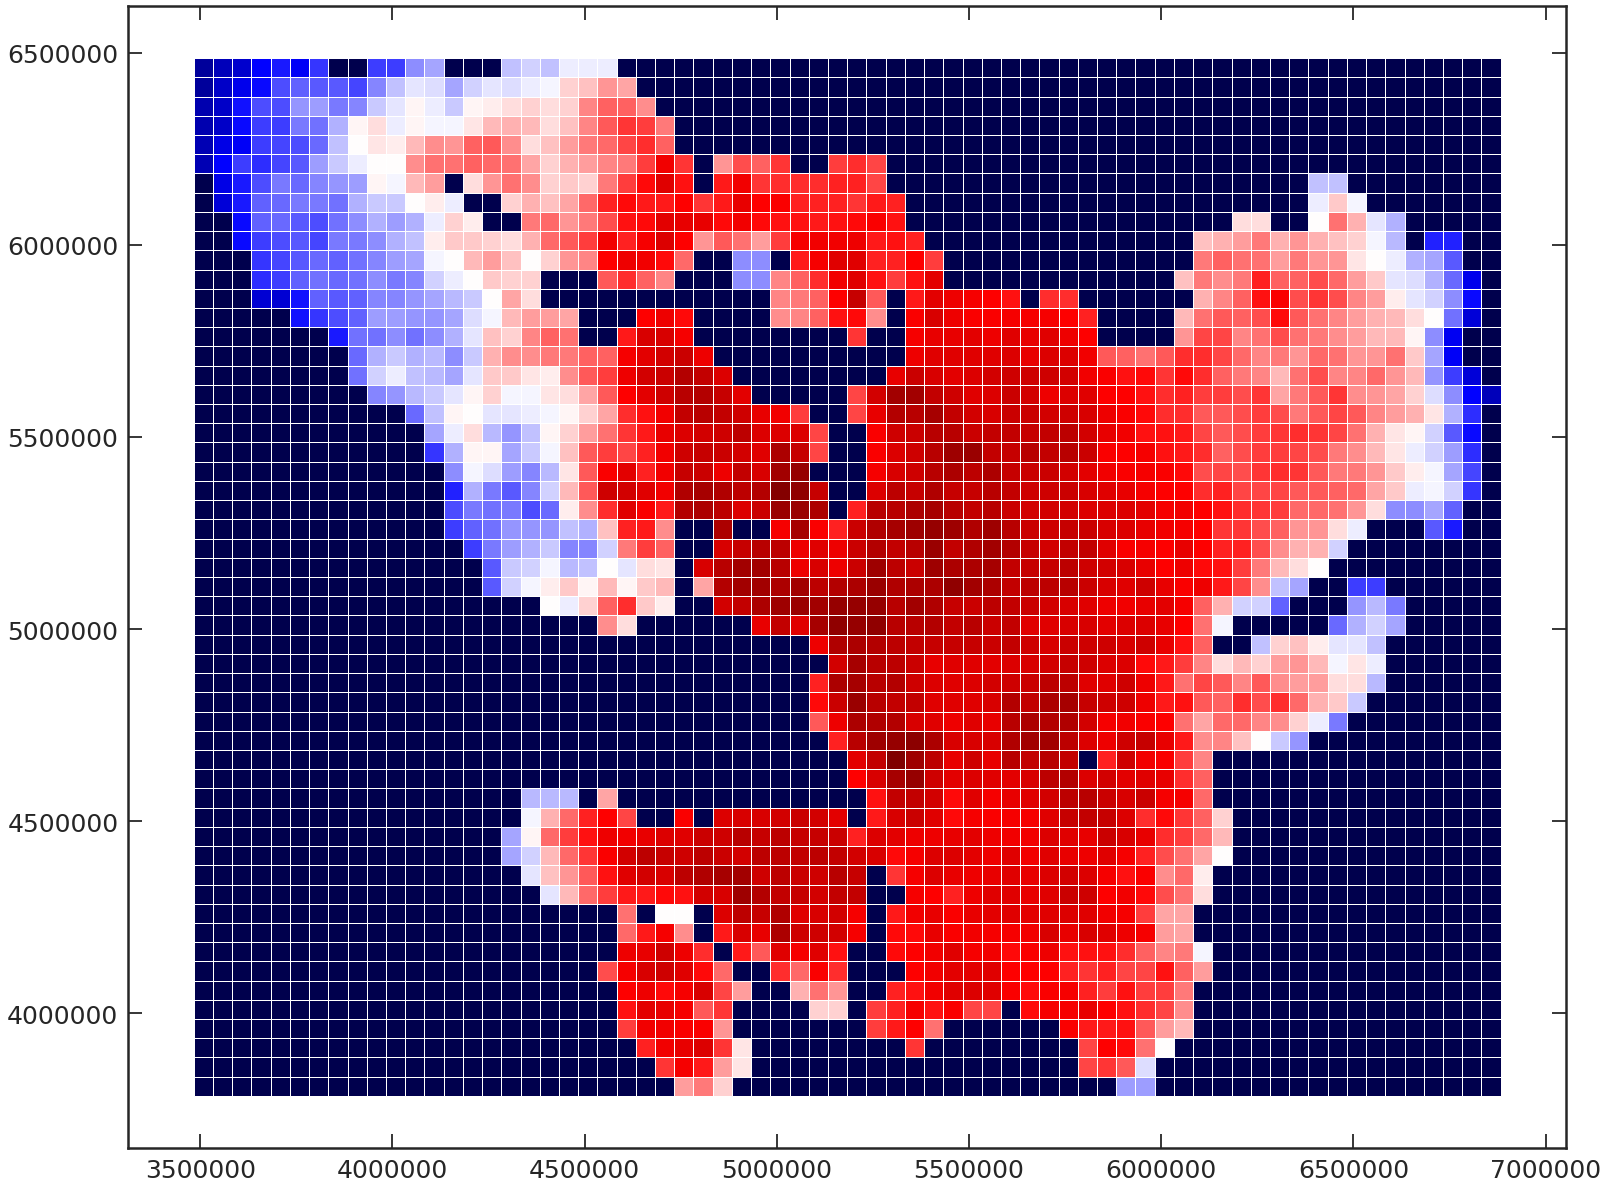

In [832]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [833]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_europe[intersection_grids_species_gpd_europe['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(europe_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [834]:
df.head(3)

geometry  0_Acorus calamus  \
0  POLYGON ((3483112.472912834 6485379.222420639,...               0.0   
1  POLYGON ((3483112.472912834 6435379.222420639,...               0.0   
2  POLYGON ((3483112.472912834 6385379.222420639,...               0.0   

   1_Aldrovanda vesiculosa  2_Alisma gramineum  3_Alisma lanceolatum  \
0                      0.0                 0.0                   0.0   
1                      0.0                 0.0                   0.0   
2                      0.0                 0.0                   0.0   

   4_Alisma plantago-aquatica  5_Alisma wahlenbergii  6_Apium inundatum  \
0                         0.0                    0.0                0.0   
1                         0.0                    0.0                0.0   
2                         0.0                    0.0                0.0   

   7_Azolla filiculoides  8_Baldellia ranunculoides          ...           \
0                    0.0                        0.0          ...            
1                    0.0                        0.0          ...            
2                    0.0                        0.0          ...            

   147_Utricularia australis  148_Utricularia intermedia  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   

   149_Utricularia minor  150_Utricularia vulgaris  \
0                    0.0                       0.0   
1                    0.0                       0.0   
2                    0.0                       0.0   

   151_Veronica anagallis-aquatica  152_Veronica beccabunga  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   

   153_Veronica catenata  154_Zannichellia palustris  155_Elatine alsinastrum  \
0                    0.0                         0.0                      0.0   
1                    0.0                         0.0                      0.0   
2                    0.0                         0.0                      0.0   

   156_Elatine triandra  
0                   0.0  
1                   0.0  
2                   0.0  

[3 rows x 158 columns]

We add a column with the total species that occurred within that grid.

In [835]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [836]:
occurrences_within_5050_grid_europe = gpd.GeoDataFrame(df, geometry='geometry')

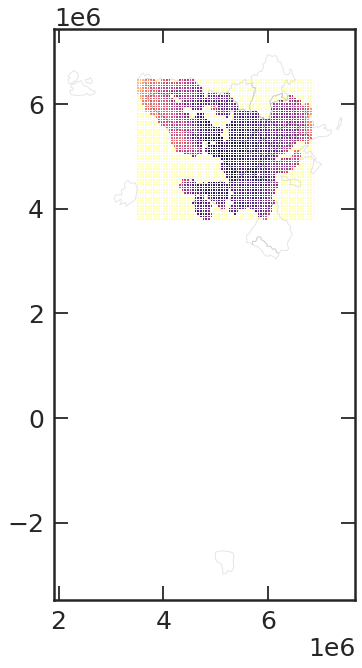

In [844]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_5050_grid_europe[['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
europe.to_crs(nad83_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [849]:
occurrences_within_5050_grid_europe = occurrences_within_5050_grid_europe[occurrences_within_5050_grid_europe['Total'] != 0]

In [852]:
occurrences_within_5050_grid_europe['grid_code'] = np.arange(occurrences_within_5050_grid_europe.shape[0])

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We are going to create a file with the code relative to the species so we can track it afterwards.

In [857]:
europe_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_5050_grid_europe.columns[1:-2]], columns=['codes', 'specie'])

In [858]:
europe_code_sp

codes                    specie
0       0            Acorus calamus
1       1     Aldrovanda vesiculosa
2       2          Alisma gramineum
3       3        Alisma lanceolatum
4       4  Alisma plantago-aquatica
..    ...                       ...
152   152       Veronica beccabunga
153   153         Veronica catenata
154   154    Zannichellia palustris
155   155       Elatine alsinastrum
156   156          Elatine triandra

[157 rows x 2 columns]

In [862]:
occurrences_within_5050_grid_europe.crs = nad83_proj_dict

In [868]:
# occurrences_within_5050_grid_europe.to_crs(wgs84_proj_dict).to_file('../results/europe/adj_matrix_5050/occurrences_within_5050_grid_europe.shp')

In [869]:
# europe_code_sp.to_csv('../results/europe/adj_matrix_5050/europe_code_sp.dat', sep='\t', index=False)

### $100km^2$
<a id="europe-adj-100-km"></a>
<a href="#summary">Summary</a>

First we have to create the grids for Europe.

In [10]:
grids_europe_100100 = fishnet(europe_df, width=100000, height=100000)

In [12]:
europe_df

specie  \
0              Acorus calamus   
1       Aldrovanda vesiculosa   
2            Alisma gramineum   
3          Alisma lanceolatum   
4    Alisma plantago-aquatica   
..                        ...   
152       Veronica beccabunga   
153         Veronica catenata   
154    Zannichellia palustris   
155       Elatine alsinastrum   
156          Elatine triandra   

                                              geometry  
0    (POLYGON ((4731286.624026645 4273781.341570556...  
1    (POLYGON ((5863981.224978034 3866643.593770091...  
2    (POLYGON ((6019790.840914152 4402193.16500022,...  
3    (POLYGON ((5156305.189681849 4149829.026699035...  
4    (POLYGON ((4776224.774256211 3799236.288008466...  
..                                                 ...  
152  (POLYGON ((4776224.774256211 3799236.288008466...  
153  (POLYGON ((4761779.980028734 3865451.486826334...  
154  (POLYGON ((4776224.774256211 3799236.288008466...  
155  (POLYGON ((4691412.650519905 5901717.563895606...  
156  (POLYGON ((5534256.716909717 4049130.0751385, ...  

[157 rows x 2 columns]

In [13]:
europe_sp_code_dict = {s:n for n, s in enumerate(europe_df['specie'])}

In [15]:
polys1 = europe_df[europe_df.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_europe_100100['geometry']

species = europe_df[europe_df.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in europe_sp_code_dict.items()],
    'code': [n for sp, n in europe_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [16]:
intersection_grids_species_gpd_europe = gpd.overlay(df1, df2, how='intersection')

In [17]:
df1.head(2)

geometry  df1  \
0  (POLYGON ((4731286.624026645 4273781.341570556...    1   
1  (POLYGON ((5863981.224978034 3866643.593770091...    2   

                 species  code  
0         Acorus calamus     0  
1  Aldrovanda vesiculosa     1

In [18]:
df2.head(2)

geometry  df2
0  POLYGON ((3483112.472912834 6485379.222420639,...    1
1  POLYGON ((3483112.472912834 6385379.222420639,...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [19]:
intersection_grids_species_gpd_europe

df1                   species  code  df2  \
13       1            Acorus calamus     0  847   
927      3          Alisma gramineum     2  847   
1356     4        Alisma lanceolatum     3  847   
1892     5  Alisma plantago-aquatica     4  847   
3972    10             Berula erecta     9  847   
...    ...                       ...   ...  ...   
70560  117        Ranunculus reptans   116    1   
71658  120  Ranunculus trichophyllus   119    1   
79473  134  Sparganium angustifolium   133    1   
81965  139    Sparganium hyperboreum   138    1   
85070  143        Subularia aquatica   142    1   

                                                geometry  
13     POLYGON ((6583112.472912833 5557065.502811748,...  
927    (POLYGON ((6683112.472912833 5581956.057718567...  
1356   POLYGON ((6583112.472912833 5508808.380932489,...  
1892   POLYGON ((6668453.599433335 5585379.222420639,...  
3972   POLYGON ((6583112.472912833 5508808.380932489,...  
...                                                  ...  
70560  POLYGON ((3551753.421913818 6385379.222420639,...  
71658  POLYGON ((3551753.421913818 6385379.222420639,...  
79473  POLYGON ((3551753.421913818 6385379.222420639,...  
81965  POLYGON ((3551753.421913818 6385379.222420639,...  
85070  POLYGON ((3551753.421913818 6385379.222420639,...  

[44460 rows x 5 columns]

For instance, on the first five rows of the **intersection_grids_species_gpd_europe** displayed above, we have that the species on the labels 1, 3, 4, 5, and 10 intersect the grid of label 3364.

What we have to do now, is to group the labels of the grids and count how many species were found within them.

In [20]:
intersection_grids_species_gpd_europe.groupby('df2').count()

df1  species  code  geometry
df2                              
1     20       20    20        20
2     20       20    20        20
3     29       29    29        29
4     25       25    25        25
28    33       33    33        33
..   ...      ...   ...       ...
898   30       30    30        30
900   29       29    29        29
901   36       36    36        36
902   38       38    38        38
903   35       35    35        35

[531 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 1 (first one on the pd.DataFrame) has 13 occurrences while the grid 3636 (last one on the pd.DataFrame) has 18 occurrences.

In [21]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_europe.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


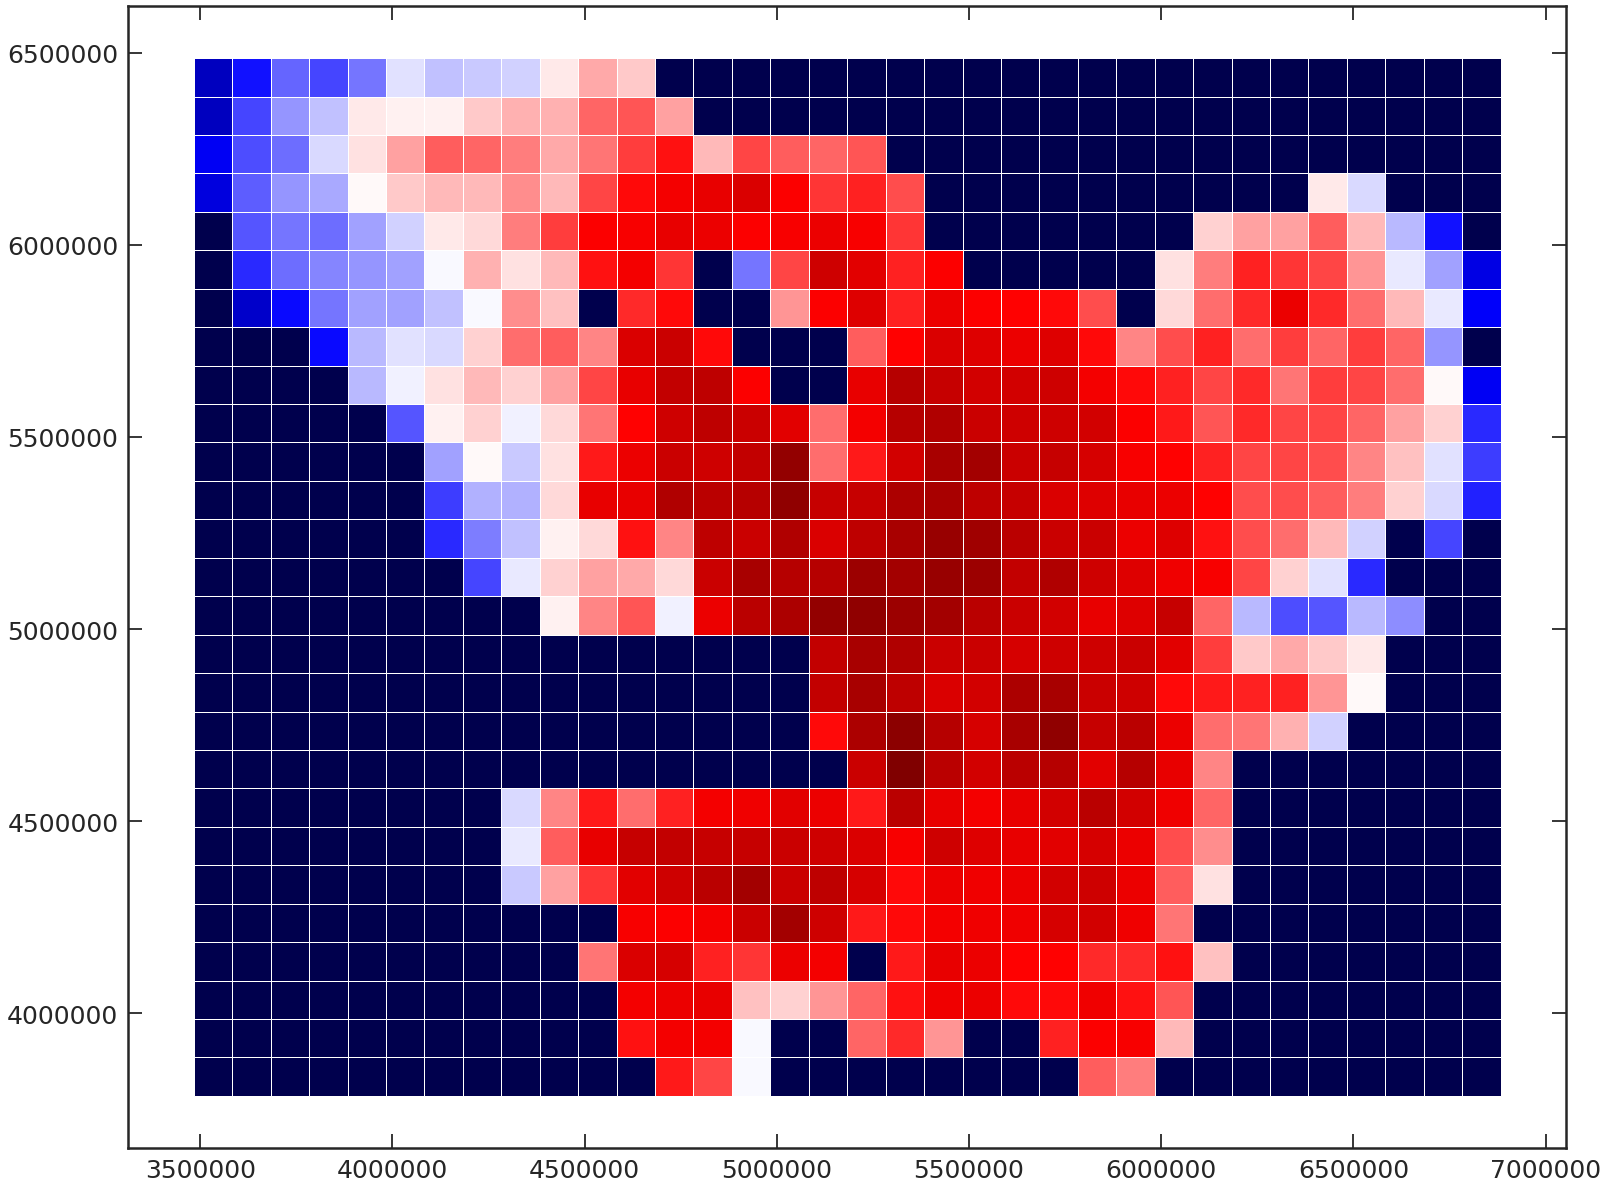

In [22]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [23]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_europe[intersection_grids_species_gpd_europe['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(europe_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [24]:
df.head(3)

geometry  0_Acorus calamus  \
0  POLYGON ((3483112.472912834 6485379.222420639,...               0.0   
1  POLYGON ((3483112.472912834 6385379.222420639,...               0.0   
2  POLYGON ((3483112.472912834 6285379.222420639,...               0.0   

   1_Aldrovanda vesiculosa  2_Alisma gramineum  3_Alisma lanceolatum  \
0                      0.0                 0.0                   0.0   
1                      0.0                 0.0                   0.0   
2                      0.0                 0.0                   0.0   

   4_Alisma plantago-aquatica  5_Alisma wahlenbergii  6_Apium inundatum  \
0                         0.0                    0.0                0.0   
1                         0.0                    0.0                0.0   
2                         0.0                    0.0                0.0   

   7_Azolla filiculoides  8_Baldellia ranunculoides          ...           \
0                    0.0                        0.0          ...            
1                    0.0                        0.0          ...            
2                    0.0                        0.0          ...            

   147_Utricularia australis  148_Utricularia intermedia  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   

   149_Utricularia minor  150_Utricularia vulgaris  \
0                    0.0                       0.0   
1                    0.0                       0.0   
2                    0.0                       0.0   

   151_Veronica anagallis-aquatica  152_Veronica beccabunga  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   

   153_Veronica catenata  154_Zannichellia palustris  155_Elatine alsinastrum  \
0                    0.0                         0.0                      0.0   
1                    0.0                         0.0                      0.0   
2                    0.0                         0.0                      0.0   

   156_Elatine triandra  
0                   0.0  
1                   0.0  
2                   0.0  

[3 rows x 158 columns]

We add a column with the total species that occurred within that grid.

In [25]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [26]:
occurrences_within_100100_grid_europe = gpd.GeoDataFrame(df, geometry='geometry')

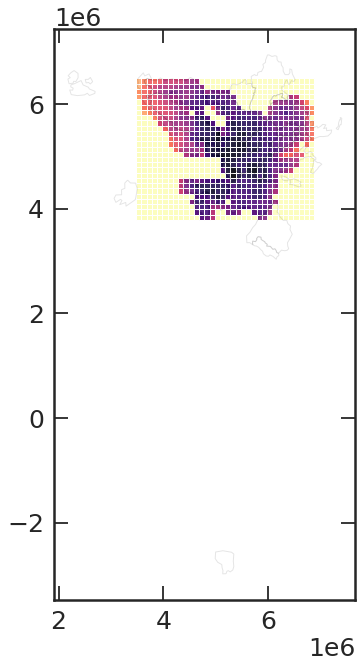

In [27]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_100100_grid_europe[['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
europe.to_crs(nad83_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [28]:
occurrences_within_100100_grid_europe = occurrences_within_100100_grid_europe[occurrences_within_100100_grid_europe['Total'] != 0]

In [29]:
occurrences_within_100100_grid_europe['grid_code'] = np.arange(occurrences_within_100100_grid_europe.shape[0])

We are going to create a file with the code relative to the species so we can track it afterwards.

In [30]:
europe_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_100100_grid_europe.columns[1:-2]], columns=['codes', 'specie'])

In [31]:
europe_code_sp

codes                    specie
0       0            Acorus calamus
1       1     Aldrovanda vesiculosa
2       2          Alisma gramineum
3       3        Alisma lanceolatum
4       4  Alisma plantago-aquatica
..    ...                       ...
152   152       Veronica beccabunga
153   153         Veronica catenata
154   154    Zannichellia palustris
155   155       Elatine alsinastrum
156   156          Elatine triandra

[157 rows x 2 columns]

In [32]:
occurrences_within_100100_grid_europe.crs = nad83_proj_dict

In [33]:
# occurrences_within_100100_grid_europe.to_crs(wgs84_proj_dict).to_file('../results/europe/adj_matrix_100100/occurrences_within_100100_grid_europe.shp')

In [34]:
# europe_code_sp.to_csv('../results/europe/adj_matrix_100100/europe_code_sp.dat', sep='\t', index=False)

### $200km^2$
<a id="europe-adj-200-km"></a>
<a href="#summary">Summary</a>

First we have to create the grids for Europe.

In [319]:
grids_europe_200200 = fishnet(europe_df, width=200000, height=200000)

In [320]:
europe_df

specie  \
0              Acorus calamus   
1       Aldrovanda vesiculosa   
2            Alisma gramineum   
3          Alisma lanceolatum   
4    Alisma plantago-aquatica   
..                        ...   
152       Veronica beccabunga   
153         Veronica catenata   
154    Zannichellia palustris   
155       Elatine alsinastrum   
156          Elatine triandra   

                                              geometry abbreviation  \
0    (POLYGON ((4731286.624026645 4273781.341570556...          NaN   
1    (POLYGON ((5863981.224978034 3866643.593770091...          NaN   
2    (POLYGON ((6019790.840914152 4402193.16500022,...     AlisGram   
3    (POLYGON ((5156305.189681849 4149829.026699035...     AlisLanc   
4    (POLYGON ((4776224.774256211 3799236.288008466...          NaN   
..                                                 ...          ...   
152  (POLYGON ((4776224.774256211 3799236.288008466...          NaN   
153  (POLYGON ((4761779.980028734 3865451.486826334...          NaN   
154  (POLYGON ((4776224.774256211 3799236.288008466...     ZannPalu   
155  (POLYGON ((4691412.650519905 5901717.563895606...          NaN   
156  (POLYGON ((5534256.716909717 4049130.0751385, ...          NaN   

            genus  
0          Acorus  
1      Aldrovanda  
2          Alisma  
3          Alisma  
4          Alisma  
..            ...  
152      Veronica  
153      Veronica  
154  Zannichellia  
155       Elatine  
156       Elatine  

[157 rows x 4 columns]

In [321]:
europe_sp_code_dict = {s:n for n, s in enumerate(europe_df['specie'])}

In [322]:
polys1 = europe_df[europe_df.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_europe_200200['geometry']

species = europe_df[europe_df.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in europe_sp_code_dict.items()],
    'code': [n for sp, n in europe_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [323]:
intersection_grids_species_gpd_europe = gpd.overlay(df1, df2, how='intersection')

In [324]:
df1.head(2)

geometry  df1  \
0  (POLYGON ((4731286.624026645 4273781.341570556...    1   
1  (POLYGON ((5863981.224978034 3866643.593770091...    2   

                 species  code  
0         Acorus calamus     0  
1  Aldrovanda vesiculosa     1

In [325]:
df2.head(2)

geometry  df2
0  POLYGON ((3483112.472912834 6485379.222420639,...    1
1  POLYGON ((3483112.472912834 6285379.222420639,...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [326]:
intersection_grids_species_gpd_europe

df1                   species  code  df2  \
0        1            Acorus calamus     0  200   
144      2     Aldrovanda vesiculosa     1  200   
248      3          Alisma gramineum     2  200   
369      4        Alisma lanceolatum     3  200   
513      5  Alisma plantago-aquatica     4  200   
...    ...                       ...   ...  ...   
21988  139    Sparganium hyperboreum   138    4   
22152  140         Sparganium natans   139    4   
22740  143        Subularia aquatica   142    4   
23036  145      Trichophorum alpinum   144    4   
24052  150         Utricularia minor   149    4   

                                                geometry  
0      (POLYGON ((6445428.004599801 5810595.556137746...  
144    (POLYGON ((6452886.202719962 5857047.525115957...  
248    (POLYGON ((6283112.472912833 5788840.10902321,...  
369    POLYGON ((6283112.472912833 5885379.222420639,...  
513    POLYGON ((6283112.472912833 5885379.222420639,...  
...                                                  ...  
21988  POLYGON ((3683112.472912834 5864874.610488277,...  
22152  POLYGON ((3683112.472912834 5864874.610488277,...  
22740  POLYGON ((3683112.472912834 5864874.610488277,...  
23036  POLYGON ((3683112.472912834 5864874.610488277,...  
24052  POLYGON ((3683112.472912834 5864874.610488277,...  

[14395 rows x 5 columns]

For instance, on the first five rows of the **intersection_grids_species_gpd_europe** displayed above, we have that the species on the labels 1, 3, 4, 5, and 10 intersect the grid of label 3364.

What we have to do now, is to group the labels of the grids and count how many species were found within them.

In [327]:
intersection_grids_species_gpd_europe.groupby('df2').count()

df1  species  code  geometry
df2                              
1     40       40    40        40
2     46       46    46        46
3     43       43    43        43
4     22       22    22        22
15    57       57    57        57
..   ...      ...   ...       ...
227   50       50    50        50
228   62       62    62        62
229   72       72    72        72
230   60       60    60        60
231   39       39    39        39

[155 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 1 (first one on the pd.DataFrame) has 13 occurrences while the grid 3636 (last one on the pd.DataFrame) has 18 occurrences.

In [328]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_europe.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

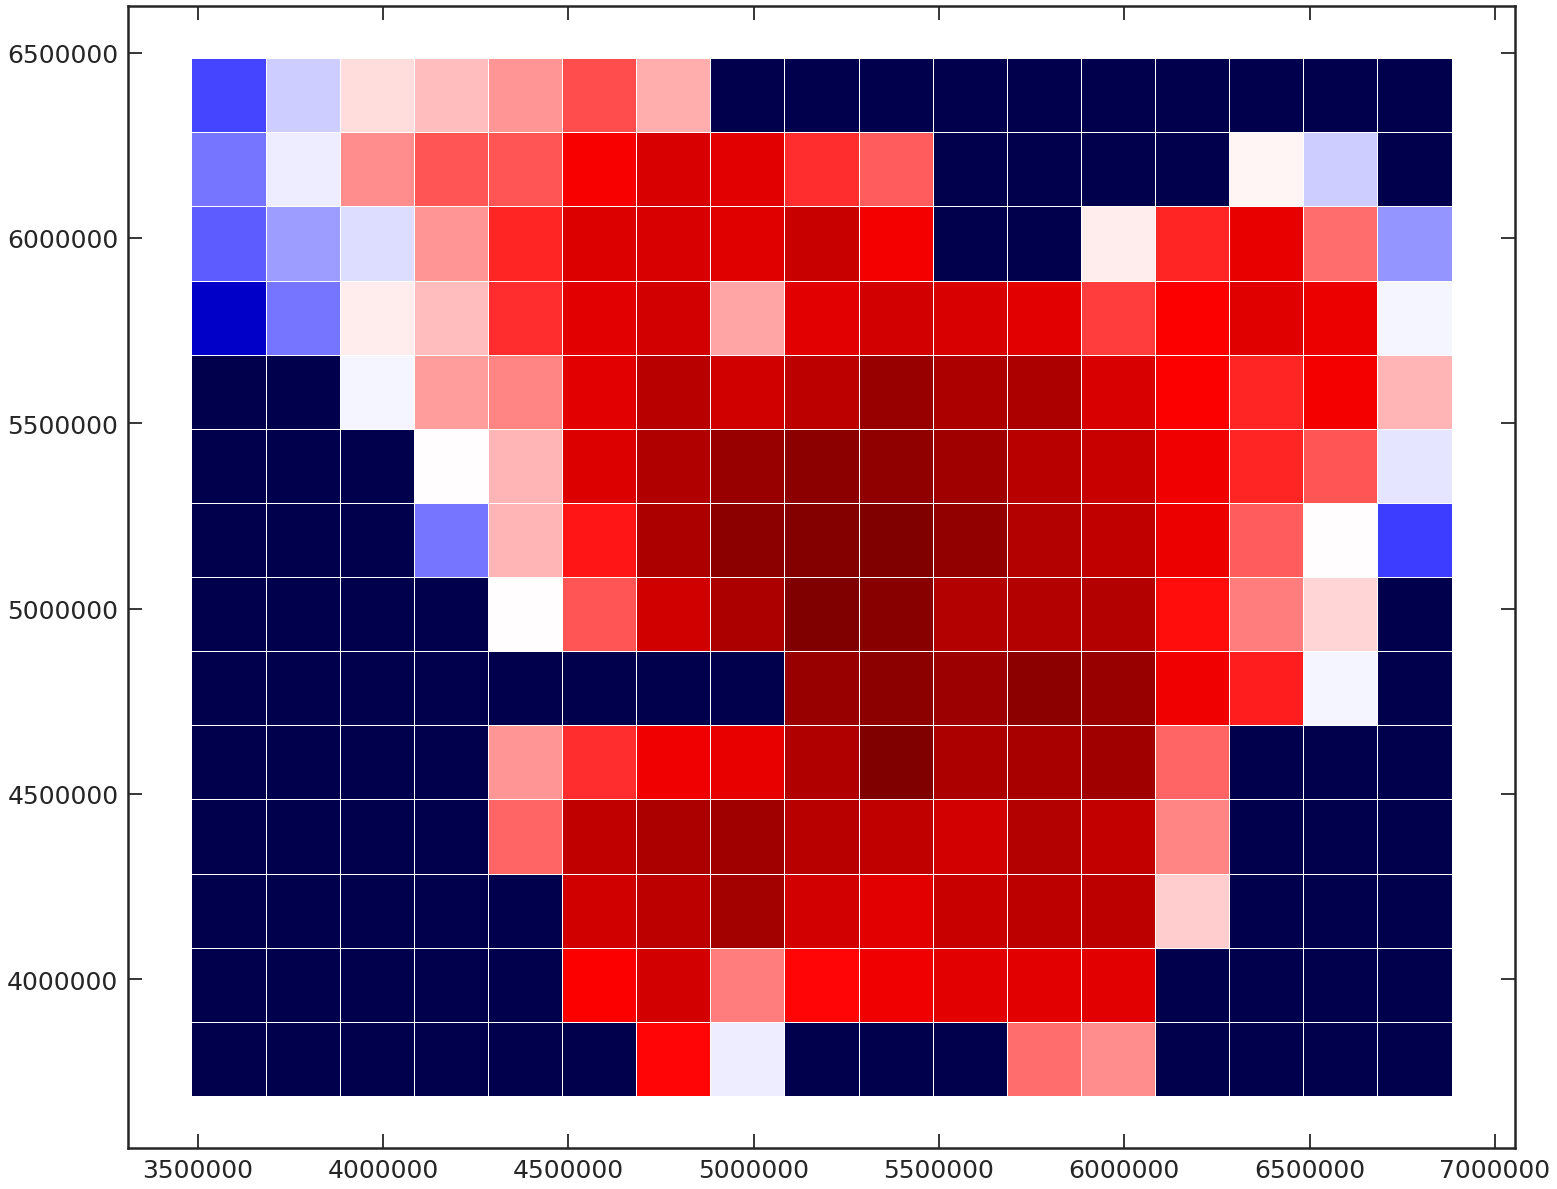

In [329]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [330]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_europe[intersection_grids_species_gpd_europe['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(europe_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [331]:
df.head(3)

geometry  0_Acorus calamus  \
0  POLYGON ((3483112.472912834 6485379.222420639,...               0.0   
1  POLYGON ((3483112.472912834 6285379.222420639,...               0.0   
2  POLYGON ((3483112.472912834 6085379.222420639,...               0.0   

   1_Aldrovanda vesiculosa  2_Alisma gramineum  3_Alisma lanceolatum  \
0                      0.0                 0.0                   0.0   
1                      0.0                 0.0                   0.0   
2                      0.0                 0.0                   0.0   

   4_Alisma plantago-aquatica  5_Alisma wahlenbergii  6_Apium inundatum  \
0                         0.0                    0.0                0.0   
1                         0.0                    0.0                0.0   
2                         0.0                    0.0                0.0   

   7_Azolla filiculoides  8_Baldellia ranunculoides          ...           \
0                    0.0                        0.0          ...            
1                    0.0                        0.0          ...            
2                    0.0                        0.0          ...            

   147_Utricularia australis  148_Utricularia intermedia  \
0                        0.0                         1.0   
1                        0.0                         1.0   
2                        0.0                         1.0   

   149_Utricularia minor  150_Utricularia vulgaris  \
0                    1.0                       0.0   
1                    1.0                       1.0   
2                    1.0                       1.0   

   151_Veronica anagallis-aquatica  152_Veronica beccabunga  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   

   153_Veronica catenata  154_Zannichellia palustris  155_Elatine alsinastrum  \
0                    0.0                         0.0                      0.0   
1                    0.0                         1.0                      0.0   
2                    0.0                         0.0                      0.0   

   156_Elatine triandra  
0                   0.0  
1                   0.0  
2                   0.0  

[3 rows x 158 columns]

We add a column with the total species that occurred within that grid.

In [332]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [333]:
occurrences_within_200200_grid_europe = gpd.GeoDataFrame(df, geometry='geometry')

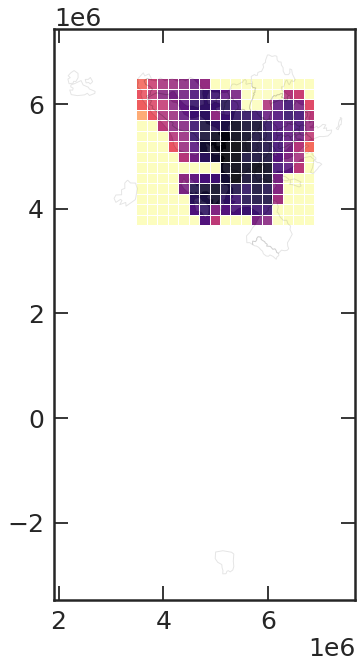

In [334]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_200200_grid_europe[['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
europe.to_crs(nad83_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [335]:
occurrences_within_200200_grid_europe = occurrences_within_200200_grid_europe[occurrences_within_200200_grid_europe['Total'] != 0]

In [852]:
occurrences_within_5050_grid_europe['grid_code'] = np.arange(occurrences_within_5050_grid_europe.shape[0])

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We are going to create a file with the code relative to the species so we can track it afterwards.

In [336]:
europe_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_200200_grid_europe.columns[1:-2]], columns=['codes', 'specie'])

In [337]:
europe_code_sp

codes                       specie
0       0               Acorus calamus
1       1        Aldrovanda vesiculosa
2       2             Alisma gramineum
3       3           Alisma lanceolatum
4       4     Alisma plantago-aquatica
..    ...                          ...
151   151  Veronica anagallis-aquatica
152   152          Veronica beccabunga
153   153            Veronica catenata
154   154       Zannichellia palustris
155   155          Elatine alsinastrum

[156 rows x 2 columns]

In [338]:
occurrences_within_200200_grid_europe.crs = nad83_proj_dict

In [339]:
# occurrences_within_200200_grid_europe.to_crs(wgs84_proj_dict).to_file('../results/europe/adj_matrix_200200/occurrences_within_200200_grid_europe.shp')

In [340]:
# europe_code_sp.to_csv('../results/europe/adj_matrix_200200/europe_code_sp.dat', sep='\t', index=False)

## North America
<a id="north-america-adj"></a>
<a href="#summary">Summary</a>

### $50km^2$
<a id="north-america-adj-50-km"></a>
<a href="#summary">Summary</a>

First we have to create the grids for North America.

In [872]:
north_america_df = north_america_old_df

In [873]:
grids_north_america_5050 = fishnet(north_america_df, width=50000, height=50000)

In [874]:
north_america_sp_code_dict = {s:n for n, s in enumerate(north_america_df['specie'])}

In [875]:
polys1 = north_america_df[north_america_df.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_north_america_5050['geometry']

species = north_america_df[north_america_df.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in north_america_sp_code_dict.items()],
    'code': [n for sp, n in north_america_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [876]:
intersection_grids_species_gpd_north_america = gpd.overlay(df1, df2, how='intersection')

In [877]:
df1.head(2)

geometry  df1             species  \
0  (POLYGON ((1505233.658681765 504657.8422120046...    1    Alisma gramineum   
1  (POLYGON ((-1944766.341318235 654657.842212004...    2  Alisma lanceolatum   

   code  
0     0  
1     1

In [878]:
df2.head(2)

geometry  df2
0  POLYGON ((-4544766.341318235 5804657.842212005...    1
1  POLYGON ((-4544766.341318235 5754657.842212005...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [879]:
intersection_grids_species_gpd_north_america

df1                 species  code    df2  \
524       1        Alisma gramineum     0  18182   
3251      3      Alisma subcordatum     2  18182   
6782      4         Alisma triviale     3  18182   
20803     9      Brasenia schreberi     8  18182   
26792    10      Butomus umbellatus     9  18182   
...     ...                     ...   ...    ...   
494400  160  Ranunculus hyperboreus   159  14016   
494404  160  Ranunculus hyperboreus   159  14015   
494415  160  Ranunculus hyperboreus   159  14014   
495147  160  Ranunculus hyperboreus   159  15053   
502126  162     Ranunculus pallasii   161  18885   

                                                 geometry  
524     POLYGON ((1605233.658681765 804657.8422120046,...  
3251    POLYGON ((1605233.658681765 804657.8422120046,...  
6782    POLYGON ((1605233.658681765 804657.8422120046,...  
20803   POLYGON ((1605233.658681765 804657.8422120046,...  
26792   POLYGON ((1605233.658681765 804657.8422120046,...  
...                                                   ...  
494400  POLYGON ((255233.6586817652 3304657.842212005,...  
494404  POLYGON ((255233.6586817652 3354657.842212005,...  
494415  POLYGON ((205233.6586817652 3404657.842212005,...  
495147  POLYGON ((605233.6586817652 2854657.842212005,...  
502126  POLYGON ((1855233.658681765 2404657.842212005,...  

[206471 rows x 5 columns]

For instance, on the first five rows of the **intersection_grids_species_gpd_europe** displayed above, we have that the species on the labels 1, 3, 4, 9, and 10 intersect the grid of label 18182.

What we have to do now, is to group the labels of the grids and count how many species were found within them.

In [883]:
intersection_grids_species_gpd_north_america.groupby('df2').count()

df1  species  code  geometry
df2                                
44       1        1     1         1
45       1        1     1         1
191      1        1     1         1
192      1        1     1         1
338      1        1     1         1
...    ...      ...   ...       ...
22134    1        1     1         1
22135   16       16    16        16
22136   25       25    25        25
22137   24       24    24        24
22138   21       21    21        21

[9831 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 44 (first one on the pd.DataFrame) has 1 occurrence while the grid 22138 (last one on the pd.DataFrame) has 21 occurrences.

In [884]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_north_america.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

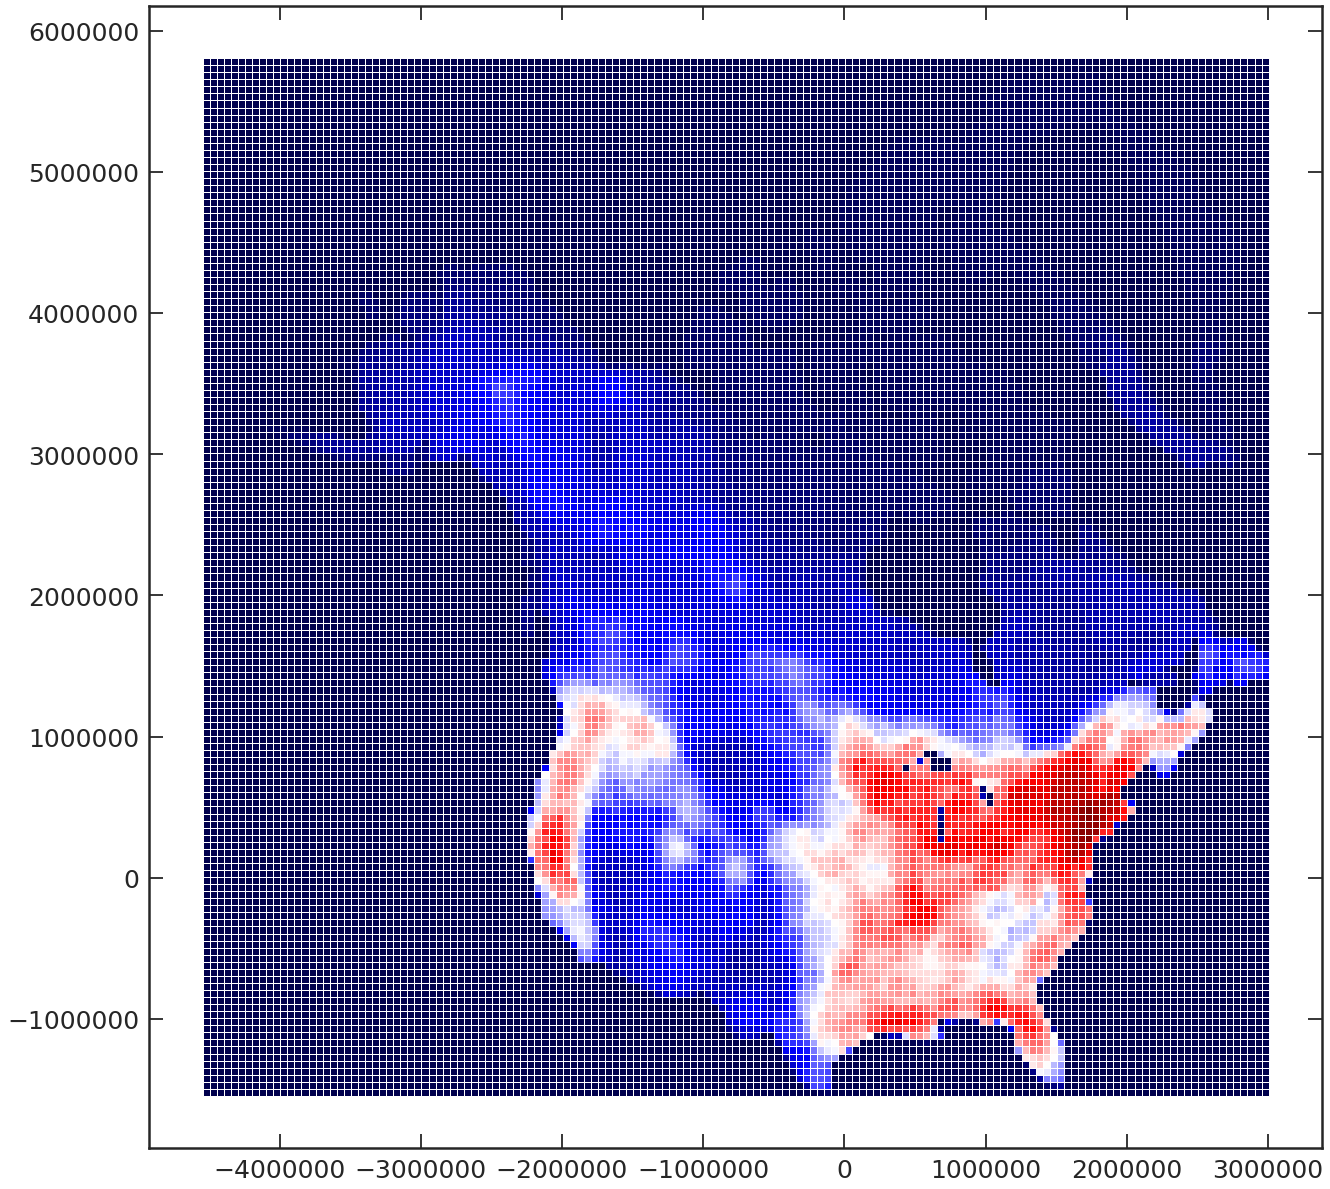

In [885]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [888]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_north_america[intersection_grids_species_gpd_north_america['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(north_america_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [889]:
df.head(3)

geometry  0_Alisma gramineum  \
0  POLYGON ((-4544766.341318235 5804657.842212005...                 0.0   
1  POLYGON ((-4544766.341318235 5754657.842212005...                 0.0   
2  POLYGON ((-4544766.341318235 5704657.842212005...                 0.0   

   1_Alisma lanceolatum  2_Alisma subcordatum  3_Alisma triviale  \
0                   0.0                   0.0                0.0   
1                   0.0                   0.0                0.0   
2                   0.0                   0.0                0.0   

   4_Azolla caroliniana  5_Azolla filiculoides  6_Azolla mexicana  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   
2                   0.0                    0.0                0.0   

   7_Blyxa aubertii  8_Brasenia schreberi             ...              \
0               0.0                   0.0             ...               
1               0.0                   0.0             ...               
2               0.0                   0.0             ...               

   206_Typha latifolia  207_Vallisneria americana  208_Wolffia borealis  \
0                  0.0                        0.0                   0.0   
1                  0.0                        0.0                   0.0   
2                  0.0                        0.0                   0.0   

   209_Wolffia brasiliensis  210_Wolffia columbiana  211_Wolffia globosa  \
0                       0.0                     0.0                  0.0   
1                       0.0                     0.0                  0.0   
2                       0.0                     0.0                  0.0   

   212_Wolffiella gladiata  213_Wolffiella lingulata  214_Wolffiella oblonga  \
0                      0.0                       0.0                     0.0   
1                      0.0                       0.0                     0.0   
2                      0.0                       0.0                     0.0   

   215_Zannichellia palustris  
0                         0.0  
1                         0.0  
2                         0.0  

[3 rows x 217 columns]

We add a column with the total species that occurred within that grid.

In [890]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [891]:
occurrences_within_5050_grid_north_america = gpd.GeoDataFrame(df, geometry='geometry')

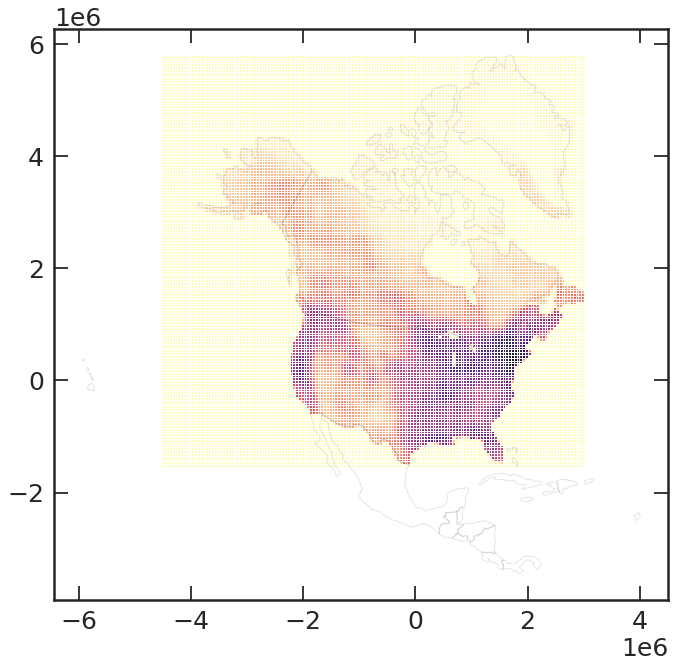

In [892]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_5050_grid_north_america[['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
north_america.to_crs(nad83_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [893]:
occurrences_within_5050_grid_north_america = occurrences_within_5050_grid_north_america[occurrences_within_5050_grid_north_america['Total'] != 0]

In [894]:
occurrences_within_5050_grid_north_america['grid_code'] = np.arange(occurrences_within_5050_grid_north_america.shape[0])

We are going to create a file with the code relative to the species so we can track it afterwards.

In [895]:
north_america_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_5050_grid_north_america.columns[1:-2]], columns=['codes', 'specie'])

In [896]:
north_america_code_sp

codes                  specie
0       0        Alisma gramineum
1       1      Alisma lanceolatum
2       2      Alisma subcordatum
3       3         Alisma triviale
4       4      Azolla caroliniana
..    ...                     ...
211   211         Wolffia globosa
212   212     Wolffiella gladiata
213   213    Wolffiella lingulata
214   214      Wolffiella oblonga
215   215  Zannichellia palustris

[216 rows x 2 columns]

In [897]:
occurrences_within_5050_grid_north_america.crs = nad83_proj_dict

In [898]:
# occurrences_within_5050_grid_north_america.to_crs(wgs84_proj_dict).to_file('../results/north_america/adj_matrix_5050/occurrences_within_5050_grid_north_america.shp')

In [899]:
# north_america_code_sp.to_csv('../results/north_america/adj_matrix_5050/north_america_code_sp.dat', sep='\t', index=False)

### $100km^2$
<a id="north-america-adj-100-km"></a>
<a href="#summary">Summary</a>

First we have to create the grids for North America.

In [57]:
north_america_df = gpd.read_file('../results/north_america/sp_polygon/sp_polygon_north_america.shp')

In [872]:
north_america_df = north_america_old_df

In [59]:
grids_north_america_100100 = fishnet(north_america_df, width=100000, height=100000)

In [60]:
north_america_sp_code_dict = {s:n for n, s in enumerate(north_america_df['specie'])}

In [61]:
polys1 = north_america_df[north_america_df.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_north_america_100100['geometry']

species = north_america_df[north_america_df.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in north_america_sp_code_dict.items()],
    'code': [n for sp, n in north_america_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [62]:
intersection_grids_species_gpd_north_america = gpd.overlay(df1, df2, how='intersection')

In [63]:
df1.head(2)

geometry  df1             species  \
0  (POLYGON ((1505233.658681765 504657.8422120046...    1    Alisma gramineum   
1  (POLYGON ((-1944766.341318235 654657.842212004...    2  Alisma lanceolatum   

   code  
0     0  
1     1

In [64]:
df2.head(2)

geometry  df2
0  POLYGON ((-4544766.341318235 5804657.842212005...    1
1  POLYGON ((-4544766.341318235 5704657.842212005...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [65]:
intersection_grids_species_gpd_north_america

df1                 species  code   df2  \
22        1        Alisma gramineum     0  2707   
1667      4         Alisma triviale     3  2707   
8263     12           Caltha natans    11  2707   
10135    15  Ceratophyllum demersum    14  2707   
20914    26    Equisetum fluviatile    25  2707   
...     ...                     ...   ...   ...   
128009  160  Ranunculus hyperboreus   159  4111   
128017  160  Ranunculus hyperboreus   159  4110   
128020  160  Ranunculus hyperboreus   159  4036   
128056  160  Ranunculus hyperboreus   159  3883   
128061  160  Ranunculus hyperboreus   159  4031   

                                                 geometry  
22      POLYGON ((-944766.3413182348 1554657.842212005...  
1667    POLYGON ((-944766.3413182348 1604657.842212005...  
8263    POLYGON ((-894766.3413182348 1604657.842212005...  
10135   POLYGON ((-944766.3413182348 1604657.842212005...  
20914   POLYGON ((-944766.3413182348 1604657.842212005...  
...                                                   ...  
128009  POLYGON ((1055233.658681765 1754657.842212005,...  
128017  POLYGON ((955233.6586817652 1854657.842212005,...  
128020  POLYGON ((905233.6586817652 1804657.842212005,...  
128056  POLYGON ((705233.6586817652 2404657.842212005,...  
128061  POLYGON ((955233.6586817652 2354657.842212005,...  

[59496 rows x 5 columns]

For instance, on the first five rows of the **intersection_grids_species_gpd_europe** displayed above, we have that the species on the labels 1, 3, 4, 9, and 10 intersect the grid of label 18182.

What we have to do now, is to group the labels of the grids and count how many species were found within them.

In [66]:
intersection_grids_species_gpd_north_america.groupby('df2').count()

df1  species  code  geometry
df2                               
22      1        1     1         1
23      1        1     1         1
96      1        1     1         1
97      1        1     1         1
98      1        1     1         1
...   ...      ...   ...       ...
5520   29       29    29        29
5521    1        1     1         1
5592    1        1     1         1
5593   25       25    25        25
5594   24       24    24        24

[2651 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 44 (first one on the pd.DataFrame) has 1 occurrence while the grid 22138 (last one on the pd.DataFrame) has 21 occurrences.

In [67]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_north_america.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

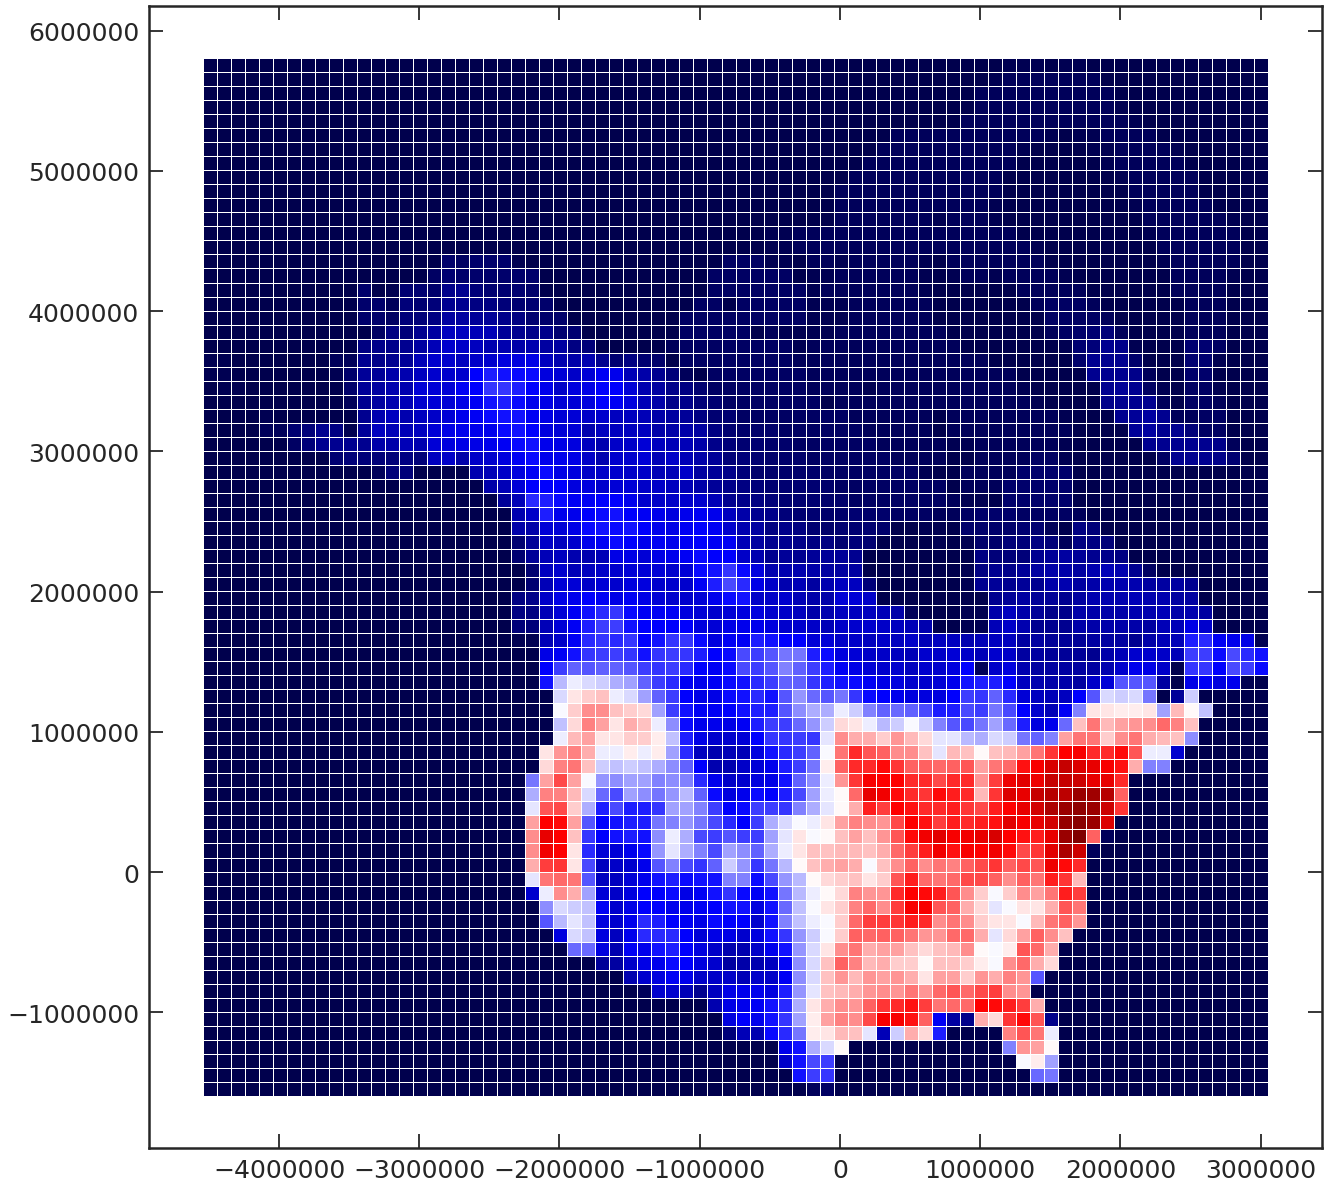

In [68]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [69]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_north_america[intersection_grids_species_gpd_north_america['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(north_america_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [70]:
df.head(3)

geometry  0_Alisma gramineum  \
0  POLYGON ((-4544766.341318235 5804657.842212005...                 0.0   
1  POLYGON ((-4544766.341318235 5704657.842212005...                 0.0   
2  POLYGON ((-4544766.341318235 5604657.842212005...                 0.0   

   1_Alisma lanceolatum  2_Alisma subcordatum  3_Alisma triviale  \
0                   0.0                   0.0                0.0   
1                   0.0                   0.0                0.0   
2                   0.0                   0.0                0.0   

   4_Azolla caroliniana  5_Azolla filiculoides  6_Azolla mexicana  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   
2                   0.0                    0.0                0.0   

   7_Blyxa aubertii  8_Brasenia schreberi             ...              \
0               0.0                   0.0             ...               
1               0.0                   0.0             ...               
2               0.0                   0.0             ...               

   206_Typha latifolia  207_Vallisneria americana  208_Wolffia borealis  \
0                  0.0                        0.0                   0.0   
1                  0.0                        0.0                   0.0   
2                  0.0                        0.0                   0.0   

   209_Wolffia brasiliensis  210_Wolffia columbiana  211_Wolffia globosa  \
0                       0.0                     0.0                  0.0   
1                       0.0                     0.0                  0.0   
2                       0.0                     0.0                  0.0   

   212_Wolffiella gladiata  213_Wolffiella lingulata  214_Wolffiella oblonga  \
0                      0.0                       0.0                     0.0   
1                      0.0                       0.0                     0.0   
2                      0.0                       0.0                     0.0   

   215_Zannichellia palustris  
0                         0.0  
1                         0.0  
2                         0.0  

[3 rows x 217 columns]

We add a column with the total species that occurred within that grid.

In [71]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [72]:
occurrences_within_100100_grid_north_america = gpd.GeoDataFrame(df, geometry='geometry')

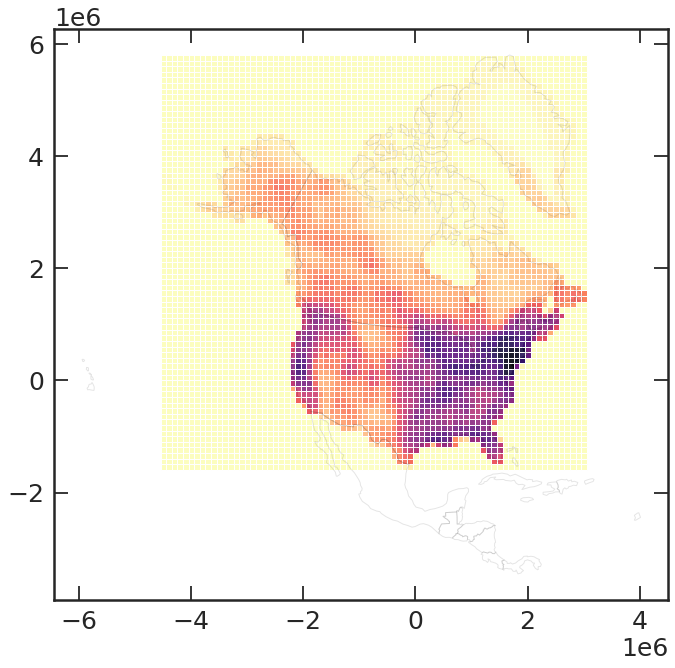

In [73]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_100100_grid_north_america[['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
north_america.to_crs(nad83_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [74]:
occurrences_within_100100_grid_north_america = occurrences_within_100100_grid_north_america[occurrences_within_100100_grid_north_america['Total'] != 0]

In [75]:
occurrences_within_100100_grid_north_america['grid_code'] = np.arange(occurrences_within_100100_grid_north_america.shape[0])

We are going to create a file with the code relative to the species so we can track it afterwards.

In [76]:
north_america_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_100100_grid_north_america.columns[1:-2]], columns=['codes', 'specie'])

In [77]:
north_america_code_sp

codes                  specie
0       0        Alisma gramineum
1       1      Alisma lanceolatum
2       2      Alisma subcordatum
3       3         Alisma triviale
4       4      Azolla caroliniana
..    ...                     ...
211   211         Wolffia globosa
212   212     Wolffiella gladiata
213   213    Wolffiella lingulata
214   214      Wolffiella oblonga
215   215  Zannichellia palustris

[216 rows x 2 columns]

In [78]:
occurrences_within_100100_grid_north_america.crs = nad83_proj_dict

In [79]:
# occurrences_within_100100_grid_north_america.to_crs(wgs84_proj_dict).to_file('../results/north_america/adj_matrix_100100/occurrences_within_100100_grid_north_america.shp')

In [80]:
# north_america_code_sp.to_csv('../results/north_america/adj_matrix_100100/north_america_code_sp.dat', sep='\t', index=False)

### $200km^2$
<a id="north-america-adj-200-km"></a>
<a href="#summary">Summary</a>

First we have to create the grids for North America.

In [872]:
north_america_df = north_america_old_df

In [341]:
grids_north_america_200200 = fishnet(north_america_df, width=200000, height=200000)

In [342]:
north_america_sp_code_dict = {s:n for n, s in enumerate(north_america_df['specie'])}

In [343]:
polys1 = north_america_df[north_america_df.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_north_america_200200['geometry']

species = north_america_df[north_america_df.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in north_america_sp_code_dict.items()],
    'code': [n for sp, n in north_america_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [344]:
intersection_grids_species_gpd_north_america = gpd.overlay(df1, df2, how='intersection')

In [345]:
df1.head(2)

geometry  df1             species  \
0  (POLYGON ((1505233.658681765 504657.8422120046...    1    Alisma gramineum   
1  (POLYGON ((-1944766.341318235 654657.842212004...    2  Alisma lanceolatum   

   code  
0     0  
1     1

In [346]:
df2.head(2)

geometry  df2
0  POLYGON ((-4544766.341318235 5804657.842212005...    1
1  POLYGON ((-4544766.341318235 5604657.842212005...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [347]:
intersection_grids_species_gpd_north_america

df1                 species  code   df2  \
13       1        Alisma gramineum     0  1137   
245      3      Alisma subcordatum     2  1137   
416      4         Alisma triviale     3  1137   
806      5      Azolla caroliniana     4  1137   
1394     9      Brasenia schreberi     8  1137   
...    ...                     ...   ...   ...   
33431  160  Ranunculus hyperboreus   159   980   
33459  160  Ranunculus hyperboreus   159   747   
34092  160  Ranunculus hyperboreus   159   160   
34098  160  Ranunculus hyperboreus   159   159   
34606  162     Ranunculus pallasii   161   159   

                                                geometry  
13     POLYGON ((1505233.658681765 504657.8422120046,...  
245    POLYGON ((1455233.658681765 604657.8422120046,...  
416    POLYGON ((1655233.658681765 504657.8422120046,...  
806    POLYGON ((1455233.658681765 554657.8422120046,...  
1394   POLYGON ((1455233.658681765 604657.8422120046,...  
...                                                  ...  
33431  POLYGON ((705233.6586817652 2404657.842212005,...  
33459  POLYGON ((-344766.3413182348 4454657.842212005...  
34092  POLYGON ((-3544766.341318235 3554657.842212005...  
34098  POLYGON ((-3594766.341318235 3604657.842212005...  
34606  POLYGON ((-3544766.341318235 3604657.842212005...  

[18628 rows x 5 columns]

For instance, on the first five rows of the **intersection_grids_species_gpd_europe** displayed above, we have that the species on the labels 1, 3, 4, 9, and 10 intersect the grid of label 18182.

What we have to do now, is to group the labels of the grids and count how many species were found within them.

In [348]:
intersection_grids_species_gpd_north_america.groupby('df2').count()

df1  species  code  geometry
df2                               
11      1        1     1         1
12      1        1     1         1
49      1        1     1         1
87      1        1     1         1
88      2        2     2         2
...   ...      ...   ...       ...
1354   33       33    33        33
1355   25       25    25        25
1390   20       20    20        20
1391   29       29    29        29
1392    1        1     1         1

[733 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 44 (first one on the pd.DataFrame) has 1 occurrence while the grid 22138 (last one on the pd.DataFrame) has 21 occurrences.

In [349]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_north_america.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

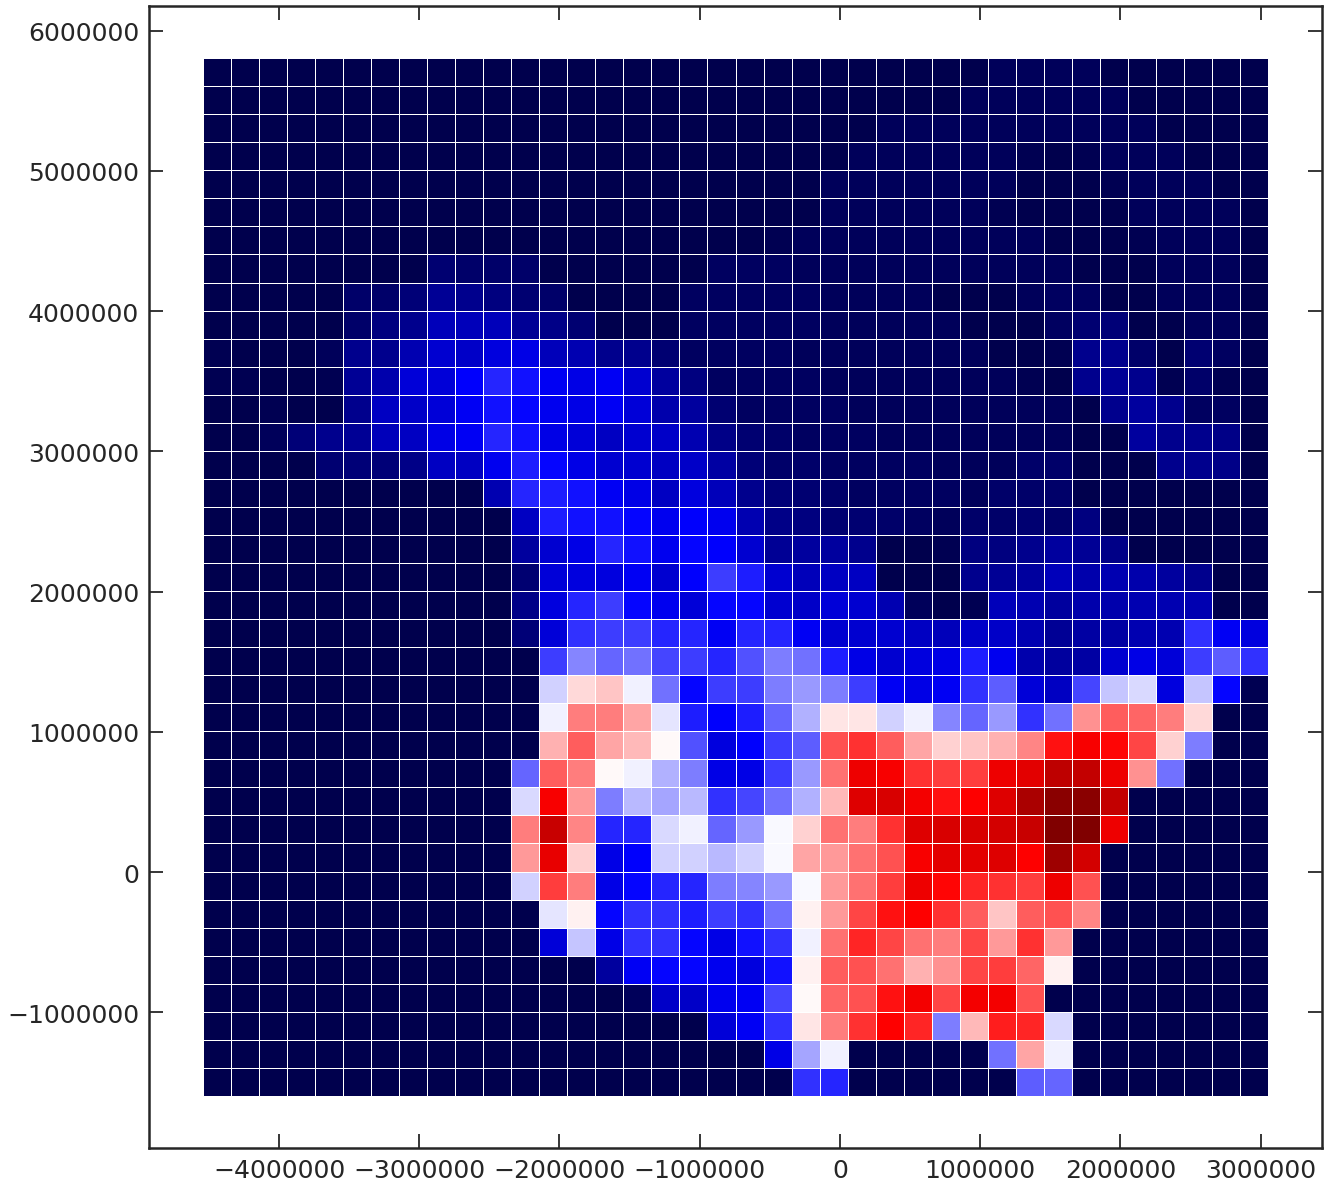

In [350]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [351]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_north_america[intersection_grids_species_gpd_north_america['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(north_america_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [352]:
df.head(3)

geometry  0_Alisma gramineum  \
0  POLYGON ((-4544766.341318235 5804657.842212005...                 0.0   
1  POLYGON ((-4544766.341318235 5604657.842212005...                 0.0   
2  POLYGON ((-4544766.341318235 5404657.842212005...                 0.0   

   1_Alisma lanceolatum  2_Alisma subcordatum  3_Alisma triviale  \
0                   0.0                   0.0                0.0   
1                   0.0                   0.0                0.0   
2                   0.0                   0.0                0.0   

   4_Azolla caroliniana  5_Azolla filiculoides  6_Azolla mexicana  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   
2                   0.0                    0.0                0.0   

   7_Blyxa aubertii  8_Brasenia schreberi             ...              \
0               0.0                   0.0             ...               
1               0.0                   0.0             ...               
2               0.0                   0.0             ...               

   206_Typha latifolia  207_Vallisneria americana  208_Wolffia borealis  \
0                  0.0                        0.0                   0.0   
1                  0.0                        0.0                   0.0   
2                  0.0                        0.0                   0.0   

   209_Wolffia brasiliensis  210_Wolffia columbiana  211_Wolffia globosa  \
0                       0.0                     0.0                  0.0   
1                       0.0                     0.0                  0.0   
2                       0.0                     0.0                  0.0   

   212_Wolffiella gladiata  213_Wolffiella lingulata  214_Wolffiella oblonga  \
0                      0.0                       0.0                     0.0   
1                      0.0                       0.0                     0.0   
2                      0.0                       0.0                     0.0   

   215_Zannichellia palustris  
0                         0.0  
1                         0.0  
2                         0.0  

[3 rows x 217 columns]

We add a column with the total species that occurred within that grid.

In [353]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [354]:
occurrences_within_200200_grid_north_america = gpd.GeoDataFrame(df, geometry='geometry')

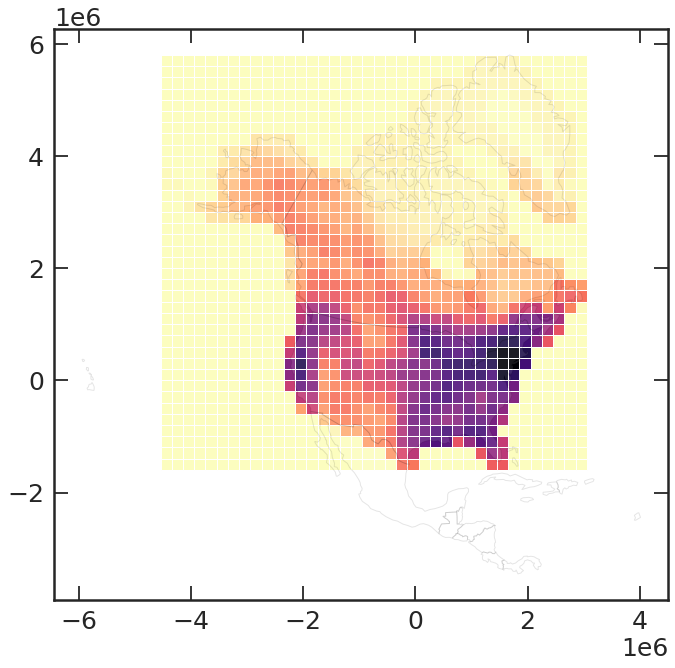

In [355]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_200200_grid_north_america[['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
north_america.to_crs(nad83_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [356]:
occurrences_within_200200_grid_north_america = occurrences_within_200200_grid_north_america[occurrences_within_200200_grid_north_america['Total'] != 0]

In [357]:
occurrences_within_200200_grid_north_america['grid_code'] = np.arange(occurrences_within_200200_grid_north_america.shape[0])

We are going to create a file with the code relative to the species so we can track it afterwards.

In [358]:
north_america_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_200200_grid_north_america.columns[1:-2]], columns=['codes', 'specie'])

In [359]:
north_america_code_sp

codes                  specie
0       0        Alisma gramineum
1       1      Alisma lanceolatum
2       2      Alisma subcordatum
3       3         Alisma triviale
4       4      Azolla caroliniana
..    ...                     ...
211   211         Wolffia globosa
212   212     Wolffiella gladiata
213   213    Wolffiella lingulata
214   214      Wolffiella oblonga
215   215  Zannichellia palustris

[216 rows x 2 columns]

In [360]:
occurrences_within_200200_grid_north_america.crs = nad83_proj_dict

In [361]:
# occurrences_within_200200_grid_north_america.to_crs(wgs84_proj_dict).to_file('../results/north_america/adj_matrix_200200/occurrences_within_200200_grid_north_america.shp')

In [362]:
# north_america_code_sp.to_csv('../results/north_america/adj_matrix_200200/north_america_code_sp.dat', sep='\t', index=False)

# Adjacency matrix for polygons cut within the continents
<a id="adj-matrix-for-polygons"></a>
<a href="#summary">Summary</a>

## Europe
<a id="europe-adj-cut"></a>
<a href="#summary">Summary</a>

### $50km^2$
<a id="europe-adj-50-cut"></a>
<a href="#summary">Summary</a>

First we have to create the grids for Europe.

In [352]:
europe_weck4 = europe.to_crs(weck4_proj_dict)

europe_df['continent'] = ['europe' for _ in range(europe_df.shape[0])]

europe_df_weck4 = europe_df.reset_index().to_crs(weck4_proj_dict)

grids_europe_5050 = fishnet(europe_weck4.dissolve(by='continent'), width=50000, height=50000)

grids_europe_5050.crs = weck4_proj_dict

europe_border_pts_weck4 = polygon_border_coords(europe_weck4.dissolve(by='continent')['geometry'].iloc[0])
europe_border_pts_weck4.crs = weck4_proj_dict

In [353]:
c = 0 # counter 
# loop through the lands with borders
grids_l = []
for land in europe_weck4.dissolve(by='continent')['geometry'].iloc[0]:
    # skip the first land: Guyana Francese
    if c == 0:
        pass
    else:    
        
        # select the part of land with the border points
        df_tmp = polygon_border_coords(land)

        # pick the longitute and latitude
        longitude_l = df_tmp['geometry'].apply(lambda p: p.xy[0][0])
        latitude_l  = df_tmp['geometry'].apply(lambda p: p.xy[1][0])

        # create the polygon
        polygon = Polygon(zip(longitude_l, latitude_l))

        # create the gpd.GeoDataFrame
        gdf = gpd.GeoDataFrame([polygon])
        gdf.columns = ['geometry']

        # overlay grids with the created polygon
        grids_l.append(gpd.overlay(grids_europe_5050, gdf, how='intersection'))
        
    c += 1

/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))


In [354]:
grids_overlay_europe_5050 = pd.concat(grids_l).reset_index(drop=True)

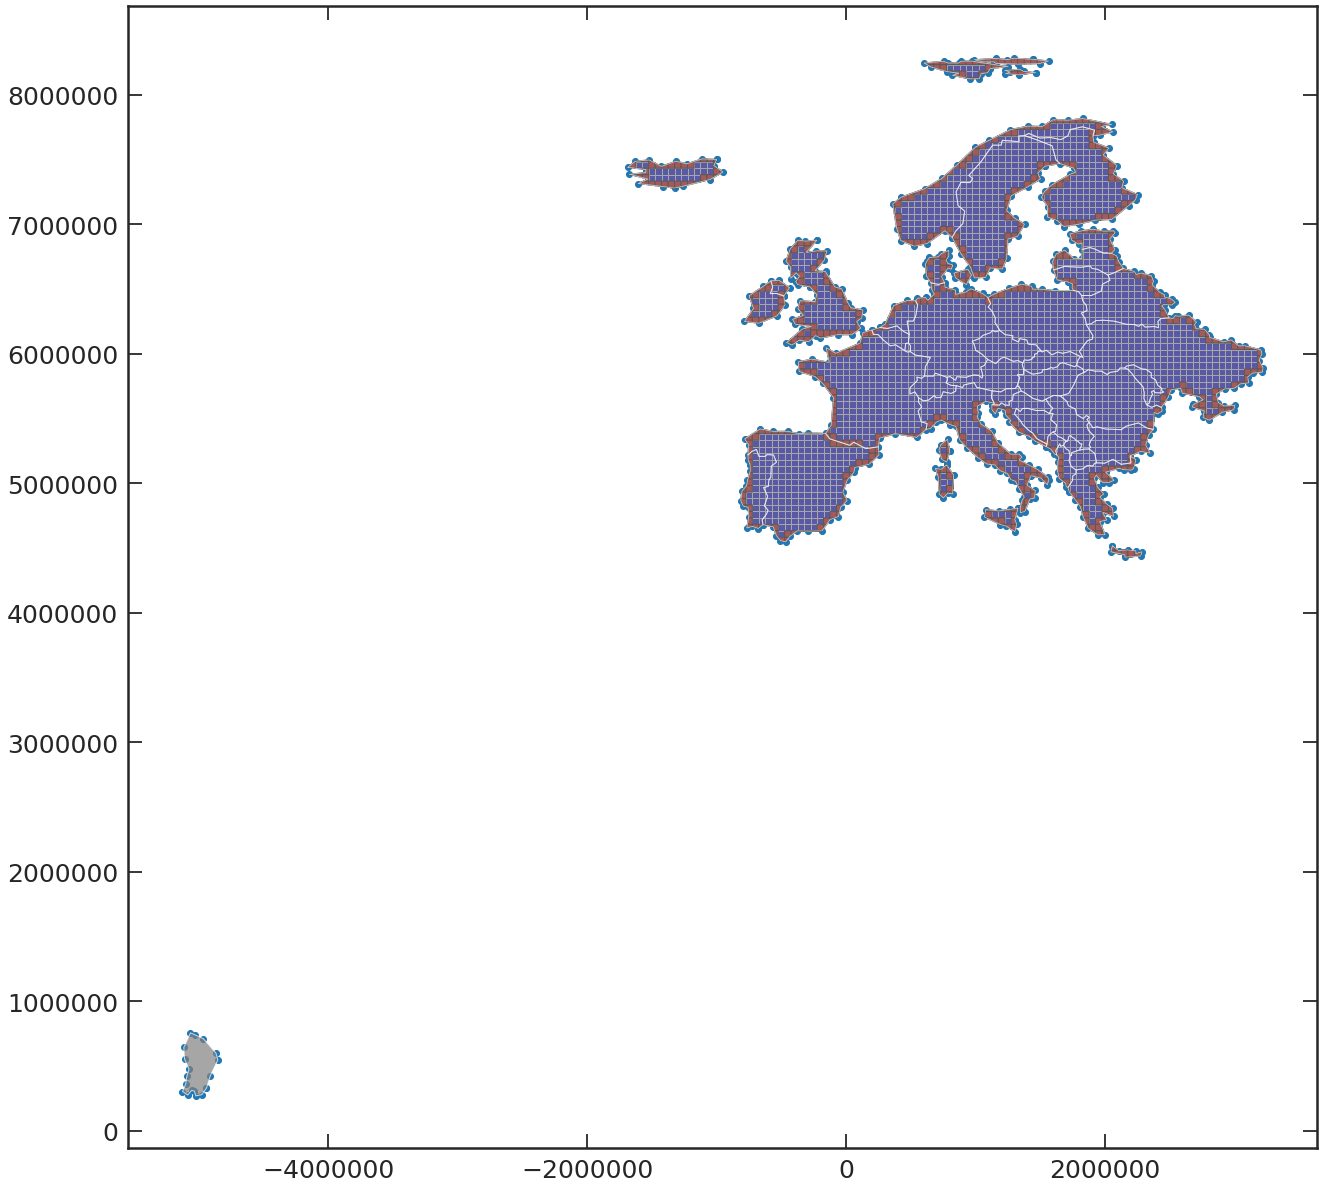

In [355]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=3))

# europe_border_pts_weck4.plot(ax=ax)
# i = 11
# grids_l[i][grids_l[i].area == 50000**2].plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 50000**2].plot(color='red', edgecolor='black', ax=ax)
# europe_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

europe_border_pts_weck4.plot(ax=ax)
# i = 10
# grids_l[i][grids_l[i].area == 50000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 50000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
# i=11
# grids_l[i][grids_l[i].area == 50000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 50000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
grids_overlay_europe_5050[grids_overlay_europe_5050.area == 50000**2].plot(color='blue', edgecolor='white', ax=ax)
grids_overlay_europe_5050[grids_overlay_europe_5050.area != 50000**2].plot(color='red', edgecolor='black', ax=ax)
europe_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

In [356]:
europe_sp_code_dict = {s:n for n, s in enumerate(europe_df['specie'])}

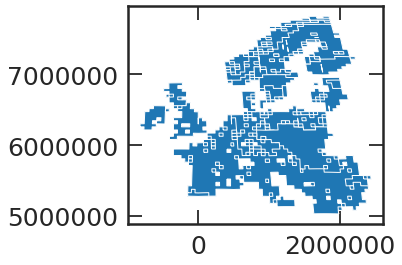

In [357]:
europe_df_weck4.plot()

In [358]:
polys1 = europe_df_weck4[europe_df_weck4.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_overlay_europe_5050['geometry']

species = europe_df_weck4[europe_df_weck4.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in europe_sp_code_dict.items()],
    'code': [n for sp, n in europe_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [359]:
intersection_grids_species_gpd_europe = gpd.overlay(df1, df2, how='intersection')

In [360]:
df1.head(2)

geometry  df1  \
0  (POLYGON ((-350122.4406514364 6514848.91265550...    1   
1  (POLYGON ((-147100.9642750344 5378350.59215927...    2   

                 species  code  
0         Acorus calamus     0  
1  Aldrovanda vesiculosa     1

In [361]:
df2.head(2)

geometry  df2
0  POLYGON ((2075971.274013413 4504878.327997872,...    1
1  POLYGON ((2046762.35003953 4484166.158095203, ...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [362]:
intersection_grids_species_gpd_europe

df1                   species  code   df2  \
4         1            Acorus calamus     0  2352   
3134      3          Alisma gramineum     2  2352   
4732      4        Alisma lanceolatum     3  2352   
6501      5  Alisma plantago-aquatica     4  2352   
12461    10             Berula erecta     9  2352   
...     ...                       ...   ...   ...   
227914  140         Sparganium natans   139   434   
233997  143        Subularia aquatica   142   434   
237380  145      Trichophorum alpinum   144   434   
247451  150         Utricularia minor   149   434   
249694  151      Utricularia vulgaris   150   434   

                                                 geometry  
4       POLYGON ((2084491.079228574 5806821.45129541, ...  
3134    POLYGON ((2084491.079228574 5806821.45129541, ...  
4732    POLYGON ((2075971.274013413 5806664.380656205,...  
6501    POLYGON ((2075971.274013413 5806664.380656205,...  
12461   POLYGON ((2075971.274013413 5806664.380656205,...  
...                                                   ...  
227914  POLYGON ((1090632.875313207 7634166.158095203,...  
233997  POLYGON ((1090632.875313207 7634166.158095203,...  
237380  POLYGON ((1090632.875313207 7634166.158095203,...  
247451  POLYGON ((1090632.875313207 7634166.158095203,...  
249694  POLYGON ((1125971.274013413 7644986.917109976,...  

[146228 rows x 5 columns]

In [363]:
intersection_grids_species_gpd_europe.groupby('df2').count()

df1  species  code  geometry
df2                               
68     69       69    69        69
69     80       80    80        80
70     86       86    86        86
71     85       85    85        85
72     85       85    85        85
...   ...      ...   ...       ...
2859   92       92    92        92
2860   97       97    97        97
2861   93       93    93        93
2862   83       83    83        83
2863   83       83    83        83

[1863 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 1 (first one on the pd.DataFrame) has 13 occurrences while the grid 3636 (last one on the pd.DataFrame) has 18 occurrences.

In [364]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_europe.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

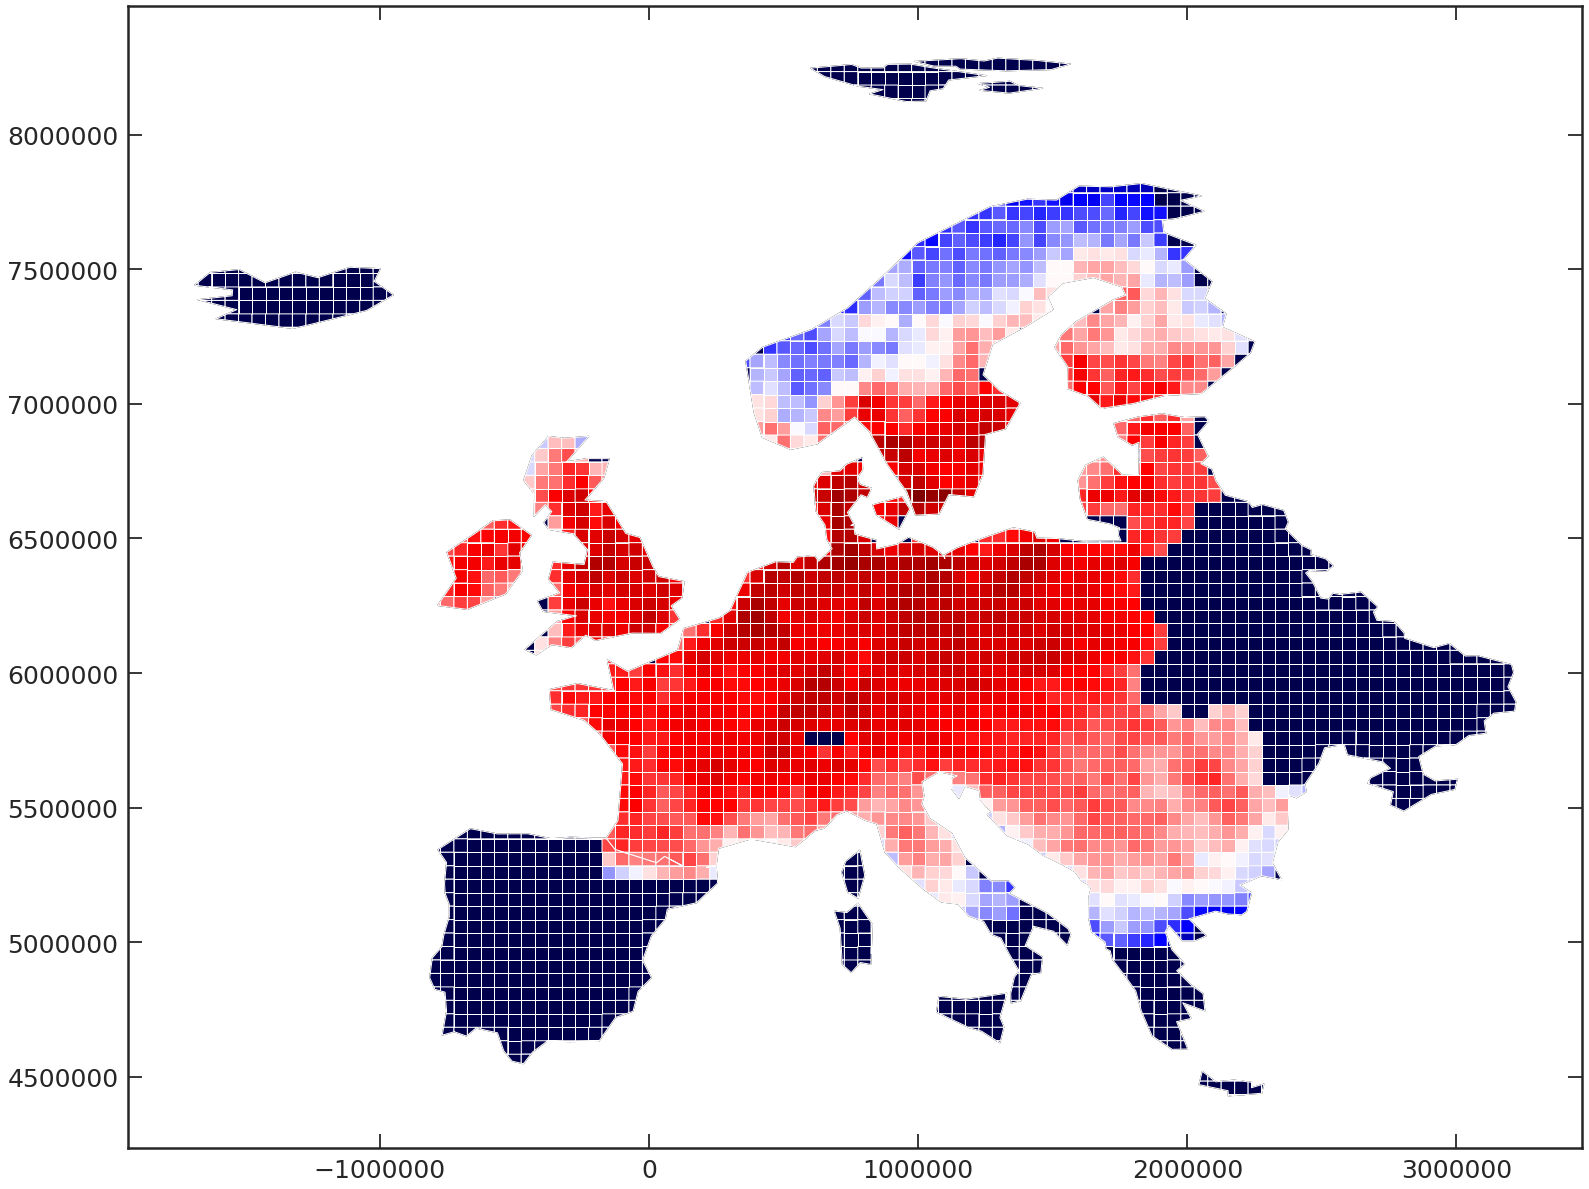

In [365]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

grids_overlay_europe_5050.plot(color='white', edgecolor='black', ax=ax)
# df2[df2.area == 200000**2].plot(column='num_species', cmap='seismic', ax=ax);
df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [366]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_europe[intersection_grids_species_gpd_europe['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(europe_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [367]:
df.head(3)

geometry  0_Acorus calamus  \
0  POLYGON ((2075971.274013413 4504878.327997872,...               0.0   
1  POLYGON ((2046762.35003953 4484166.158095203, ...               0.0   
2  POLYGON ((2102811.517998204 4484166.158095203,...               0.0   

   1_Aldrovanda vesiculosa  2_Alisma gramineum  3_Alisma lanceolatum  \
0                      0.0                 0.0                   0.0   
1                      0.0                 0.0                   0.0   
2                      0.0                 0.0                   0.0   

   4_Alisma plantago-aquatica  5_Alisma wahlenbergii  6_Apium inundatum  \
0                         0.0                    0.0                0.0   
1                         0.0                    0.0                0.0   
2                         0.0                    0.0                0.0   

   7_Azolla filiculoides  8_Baldellia ranunculoides          ...           \
0                    0.0                        0.0          ...            
1                    0.0                        0.0          ...            
2                    0.0                        0.0          ...            

   147_Utricularia australis  148_Utricularia intermedia  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   

   149_Utricularia minor  150_Utricularia vulgaris  \
0                    0.0                       0.0   
1                    0.0                       0.0   
2                    0.0                       0.0   

   151_Veronica anagallis-aquatica  152_Veronica beccabunga  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   

   153_Veronica catenata  154_Zannichellia palustris  155_Elatine alsinastrum  \
0                    0.0                         0.0                      0.0   
1                    0.0                         0.0                      0.0   
2                    0.0                         0.0                      0.0   

   156_Elatine triandra  
0                   0.0  
1                   0.0  
2                   0.0  

[3 rows x 158 columns]

We add a column with the total species that occurred within that grid.

In [368]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [369]:
occurrences_within_5050_grid_europe = gpd.GeoDataFrame(df, geometry='geometry')

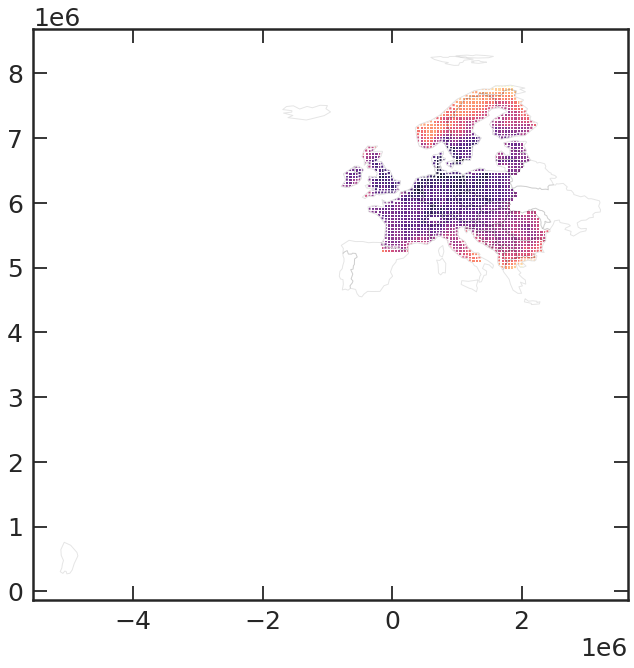

In [370]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_5050_grid_europe[occurrences_within_5050_grid_europe['Total'] != 0][['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
europe.to_crs(weck4_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [371]:
occurrences_within_5050_grid_europe = occurrences_within_5050_grid_europe[occurrences_within_5050_grid_europe['Total'] != 0]

In [372]:
occurrences_within_5050_grid_europe['grid_code'] = np.arange(occurrences_within_5050_grid_europe.shape[0])

We are going to create a file with the code relative to the species so we can track it afterwards.

In [373]:
europe_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_5050_grid_europe.columns[1:-2]], columns=['codes', 'specie'])

In [374]:
europe_code_sp

codes                    specie
0       0            Acorus calamus
1       1     Aldrovanda vesiculosa
2       2          Alisma gramineum
3       3        Alisma lanceolatum
4       4  Alisma plantago-aquatica
..    ...                       ...
152   152       Veronica beccabunga
153   153         Veronica catenata
154   154    Zannichellia palustris
155   155       Elatine alsinastrum
156   156          Elatine triandra

[157 rows x 2 columns]

In [375]:
occurrences_within_5050_grid_europe.crs

In [376]:
occurrences_within_5050_grid_europe.crs = weck4_proj_dict

In [377]:
# occurrences_within_5050_grid_europe.to_file('../results/europe/adj_matrix_5050_border_weck4/occurrences_within_5050_grid_europe_border_weck4.shp')

In [378]:
# europe_code_sp.to_csv('../results/europe/adj_matrix_5050_border_weck4/europe_code_sp.dat', sep='\t', index=False)

In [422]:
# occurrences_within_5050_grid_europe.to_crs(wgs84_proj_dict).to_file('../results/europe/adj_matrix_5050_border/occurrences_within_5050_grid_europe_border.shp')

In [423]:
# europe_code_sp.to_csv('../results/europe/adj_matrix_5050_border/europe_code_sp.dat', sep='\t', index=False)

### $100km^2$
<a id="europe-adj-100-cut"></a>
<a href="#summary">Summary</a>

First we have to create the grids for Europe.

In [406]:
europe_weck4 = europe.to_crs(weck4_proj_dict)

europe_df['continent'] = ['europe' for _ in range(europe_df.shape[0])]

europe_df_weck4 = europe_df.reset_index().to_crs(weck4_proj_dict)

grids_europe_100100 = fishnet(europe_weck4.dissolve(by='continent'), width=100000, height=100000)

grids_europe_100100.crs = weck4_proj_dict

europe_border_pts_weck4 = polygon_border_coords(europe_weck4.dissolve(by='continent')['geometry'].iloc[0])
europe_border_pts_weck4.crs = weck4_proj_dict

In [407]:
c = 0 # counter 
# loop through the lands with borders
grids_l = []
for land in europe_weck4.dissolve(by='continent')['geometry'].iloc[0]:
    # skip the first land: Guyana Francese
    if c == 0:
        pass
    else:    
        
        # select the part of land with the border points
        df_tmp = polygon_border_coords(land)

        # pick the longitute and latitude
        longitude_l = df_tmp['geometry'].apply(lambda p: p.xy[0][0])
        latitude_l  = df_tmp['geometry'].apply(lambda p: p.xy[1][0])

        # create the polygon
        polygon = Polygon(zip(longitude_l, latitude_l))

        # create the gpd.GeoDataFrame
        gdf = gpd.GeoDataFrame([polygon])
        gdf.columns = ['geometry']

        # overlay grids with the created polygon
        grids_l.append(gpd.overlay(grids_europe_100100, gdf, how='intersection'))
        
    c += 1

/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))


In [408]:
grids_overlay_europe_100100 = pd.concat(grids_l).reset_index(drop=True)

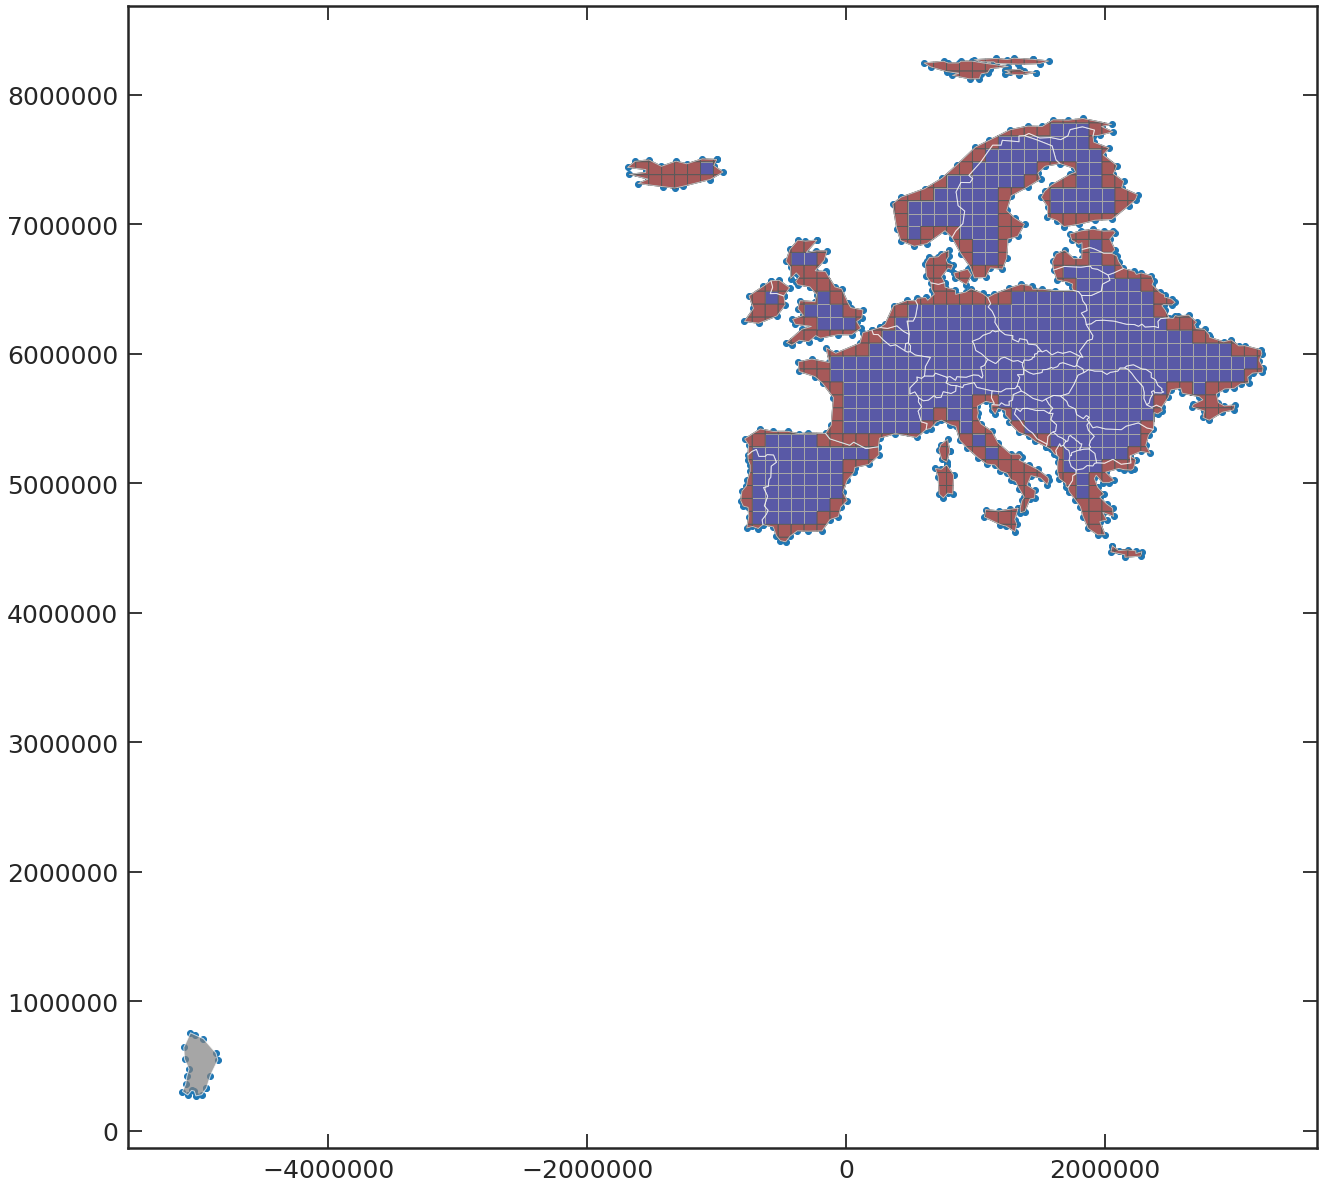

In [409]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=3))

# europe_border_pts_weck4.plot(ax=ax)
# i = 11
# grids_l[i][grids_l[i].area == 100000**2].plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 100000**2].plot(color='red', edgecolor='black', ax=ax)
# europe_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

europe_border_pts_weck4.plot(ax=ax)
# i = 10
# grids_l[i][grids_l[i].area == 100000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 100000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
# i=11
# grids_l[i][grids_l[i].area == 100000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 100000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
grids_overlay_europe_100100[grids_overlay_europe_100100.area == 100000**2].plot(color='blue', edgecolor='white', ax=ax)
grids_overlay_europe_100100[grids_overlay_europe_100100.area != 100000**2].plot(color='red', edgecolor='black', ax=ax)
europe_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

In [410]:
europe_sp_code_dict = {s:n for n, s in enumerate(europe_df['specie'])}

In [411]:
polys1 = europe_df_weck4[europe_df_weck4.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_overlay_europe_100100['geometry']

species = europe_df_weck4[europe_df_weck4.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in europe_sp_code_dict.items()],
    'code': [n for sp, n in europe_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [412]:
intersection_grids_species_gpd_europe = gpd.overlay(df1, df2, how='intersection')

In [413]:
df1.head(2)

geometry  df1  \
0  (POLYGON ((-350122.4406514364 6514848.91265550...    1   
1  (POLYGON ((-147100.9642750344 5378350.59215927...    2   

                 species  code  
0         Acorus calamus     0  
1  Aldrovanda vesiculosa     1

In [414]:
df2.head(2)

geometry  df2
0  POLYGON ((2075971.274013413 4504878.327997872,...    1
1  POLYGON ((2046762.35003953 4484166.158095203, ...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [415]:
intersection_grids_species_gpd_europe

df1                   species  code  df2  \
1        1            Acorus calamus     0  691   
523      2     Aldrovanda vesiculosa     1  691   
881      3          Alisma gramineum     2  691   
1328     4        Alisma lanceolatum     3  691   
1832     5  Alisma plantago-aquatica     4  691   
...    ...                       ...   ...  ...   
55165  117        Ranunculus reptans   116  188   
55944  120  Ranunculus trichophyllus   119  188   
62466  134  Sparganium angustifolium   133  188   
64481  139    Sparganium hyperboreum   138  188   
66660  143        Subularia aquatica   142  188   

                                                geometry  
1      POLYGON ((2170016.456831771 5584166.158095203,...  
523    POLYGON ((2075971.274013413 5665702.146414558,...  
881    POLYGON ((2175971.274013413 5666880.477420238,...  
1328   POLYGON ((2075971.274013413 5684166.158095203,...  
1832   POLYGON ((2075971.274013413 5684166.158095203,...  
...                                                  ...  
55165  (POLYGON ((1570049.727430578 7784166.158095203...  
55944  POLYGON ((1570049.727430578 7784166.158095203,...  
62466  (POLYGON ((1570049.727430578 7784166.158095203...  
64481  (POLYGON ((1570049.727430578 7784166.158095203...  
66660  (POLYGON ((1570049.727430578 7784166.158095203...  

[45225 rows x 5 columns]

In [416]:
intersection_grids_species_gpd_europe.groupby('df2').count()

df1  species  code  geometry
df2                              
30    86       86    86        86
31    86       86    86        86
32    77       77    77        77
33    87       87    87        87
34    96       96    96        96
..   ...      ...   ...       ...
831  107      107   107       107
832  101      101   101       101
833   97       97    97        97
834   95       95    95        95
835   83       83    83        83

[538 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 1 (first one on the pd.DataFrame) has 13 occurrences while the grid 3636 (last one on the pd.DataFrame) has 18 occurrences.

In [417]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_europe.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

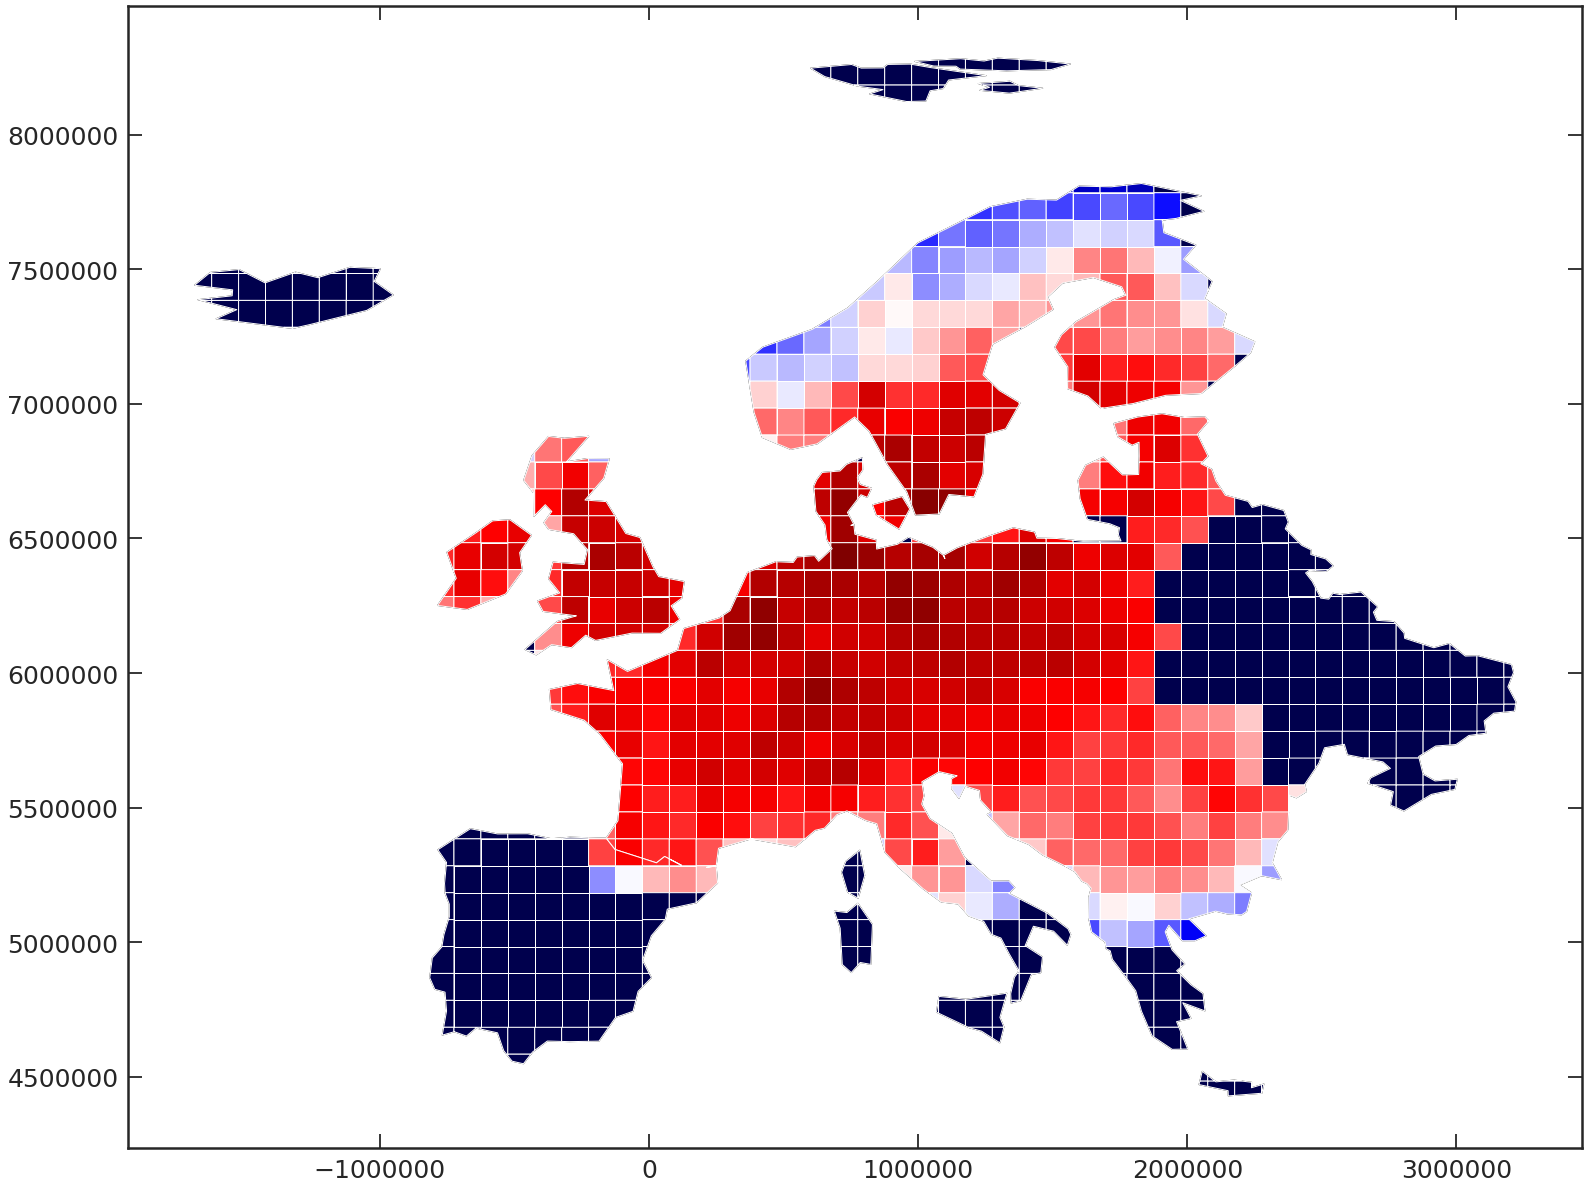

In [418]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

grids_overlay_europe_100100.plot(color='white', edgecolor='black', ax=ax)
# df2[df2.area == 200000**2].plot(column='num_species', cmap='seismic', ax=ax);
df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [419]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_europe[intersection_grids_species_gpd_europe['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(europe_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [420]:
df.head(3)

geometry  0_Acorus calamus  \
0  POLYGON ((2075971.274013413 4504878.327997872,...               0.0   
1  POLYGON ((2046762.35003953 4484166.158095203, ...               0.0   
2  (POLYGON ((2175971.274013413 4487741.569374374...               0.0   

   1_Aldrovanda vesiculosa  2_Alisma gramineum  3_Alisma lanceolatum  \
0                      0.0                 0.0                   0.0   
1                      0.0                 0.0                   0.0   
2                      0.0                 0.0                   0.0   

   4_Alisma plantago-aquatica  5_Alisma wahlenbergii  6_Apium inundatum  \
0                         0.0                    0.0                0.0   
1                         0.0                    0.0                0.0   
2                         0.0                    0.0                0.0   

   7_Azolla filiculoides  8_Baldellia ranunculoides          ...           \
0                    0.0                        0.0          ...            
1                    0.0                        0.0          ...            
2                    0.0                        0.0          ...            

   147_Utricularia australis  148_Utricularia intermedia  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   

   149_Utricularia minor  150_Utricularia vulgaris  \
0                    0.0                       0.0   
1                    0.0                       0.0   
2                    0.0                       0.0   

   151_Veronica anagallis-aquatica  152_Veronica beccabunga  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   

   153_Veronica catenata  154_Zannichellia palustris  155_Elatine alsinastrum  \
0                    0.0                         0.0                      0.0   
1                    0.0                         0.0                      0.0   
2                    0.0                         0.0                      0.0   

   156_Elatine triandra  
0                   0.0  
1                   0.0  
2                   0.0  

[3 rows x 158 columns]

We add a column with the total species that occurred within that grid.

In [421]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [422]:
occurrences_within_100100_grid_europe = gpd.GeoDataFrame(df, geometry='geometry')

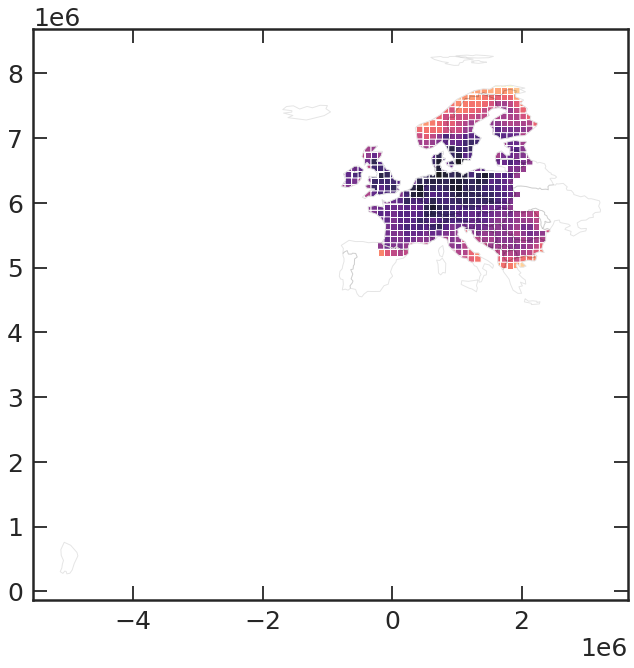

In [423]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_100100_grid_europe[occurrences_within_100100_grid_europe['Total'] != 0][['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
europe.to_crs(weck4_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [424]:
occurrences_within_100100_grid_europe = occurrences_within_100100_grid_europe[occurrences_within_100100_grid_europe['Total'] != 0]

In [425]:
occurrences_within_100100_grid_europe['grid_code'] = np.arange(occurrences_within_100100_grid_europe.shape[0])

We are going to create a file with the code relative to the species so we can track it afterwards.

In [426]:
europe_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_100100_grid_europe.columns[1:-2]], columns=['codes', 'specie'])

In [427]:
europe_code_sp

codes                    specie
0       0            Acorus calamus
1       1     Aldrovanda vesiculosa
2       2          Alisma gramineum
3       3        Alisma lanceolatum
4       4  Alisma plantago-aquatica
..    ...                       ...
152   152       Veronica beccabunga
153   153         Veronica catenata
154   154    Zannichellia palustris
155   155       Elatine alsinastrum
156   156          Elatine triandra

[157 rows x 2 columns]

In [428]:
occurrences_within_100100_grid_europe.crs

In [429]:
occurrences_within_100100_grid_europe.crs = weck4_proj_dict

In [430]:
# occurrences_within_100100_grid_europe.to_file('../results/europe/adj_matrix_100100_border_weck4/occurrences_within_100100_grid_europe_border_weck4.shp')

In [431]:
# europe_code_sp.to_csv('../results/europe/adj_matrix_100100_border_weck4/europe_code_sp.dat', sep='\t', index=False)

In [432]:
# occurrences_within_100100_grid_europe.to_crs(wgs84_proj_dict).to_file('../results/europe/adj_matrix_100100_border/occurrences_within_100100_grid_europe_border.shp')

In [433]:
# europe_code_sp.to_csv('../results/europe/adj_matrix_100100_border/europe_code_sp.dat', sep='\t', index=False)

### $200km^2$
<a id="europe-adj-200-cut"></a>
<a href="#summary">Summary</a>

First we have to create the grids for Europe.

In [461]:
europe_weck4 = europe.to_crs(weck4_proj_dict)

In [462]:
europe_df['continent'] = ['europe' for _ in range(europe_df.shape[0])]

europe_df_weck4 = europe_df.reset_index().to_crs(weck4_proj_dict)

In [463]:
grids_europe_200200 = fishnet(europe_weck4.dissolve(by='continent'), width=200000, height=200000)

In [464]:
grids_europe_200200.crs = weck4_proj_dict

In [465]:
europe_border_pts_weck4 = polygon_border_coords(europe_weck4.dissolve(by='continent')['geometry'].iloc[0])
europe_border_pts_weck4.crs = weck4_proj_dict

In [466]:
c = 0 # counter 
# loop through the lands with borders
grids_l = []
for land in europe_weck4.dissolve(by='continent')['geometry'].iloc[0]:
    # skip the first land: Guyana Francese
    if c == 0:
        pass
    else:    
        
        # select the part of land with the border points
        df_tmp = polygon_border_coords(land)

        # pick the longitute and latitude
        longitude_l = df_tmp['geometry'].apply(lambda p: p.xy[0][0])
        latitude_l  = df_tmp['geometry'].apply(lambda p: p.xy[1][0])

        # create the polygon
        polygon = Polygon(zip(longitude_l, latitude_l))

        # create the gpd.GeoDataFrame
        gdf = gpd.GeoDataFrame([polygon])
        gdf.columns = ['geometry']

        # overlay grids with the created polygon
        grids_l.append(gpd.overlay(grids_europe_200200, gdf, how='intersection'))
        
    c += 1

/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))


In [467]:
grids_overlay_europe_200200 = pd.concat(grids_l).reset_index(drop=True)

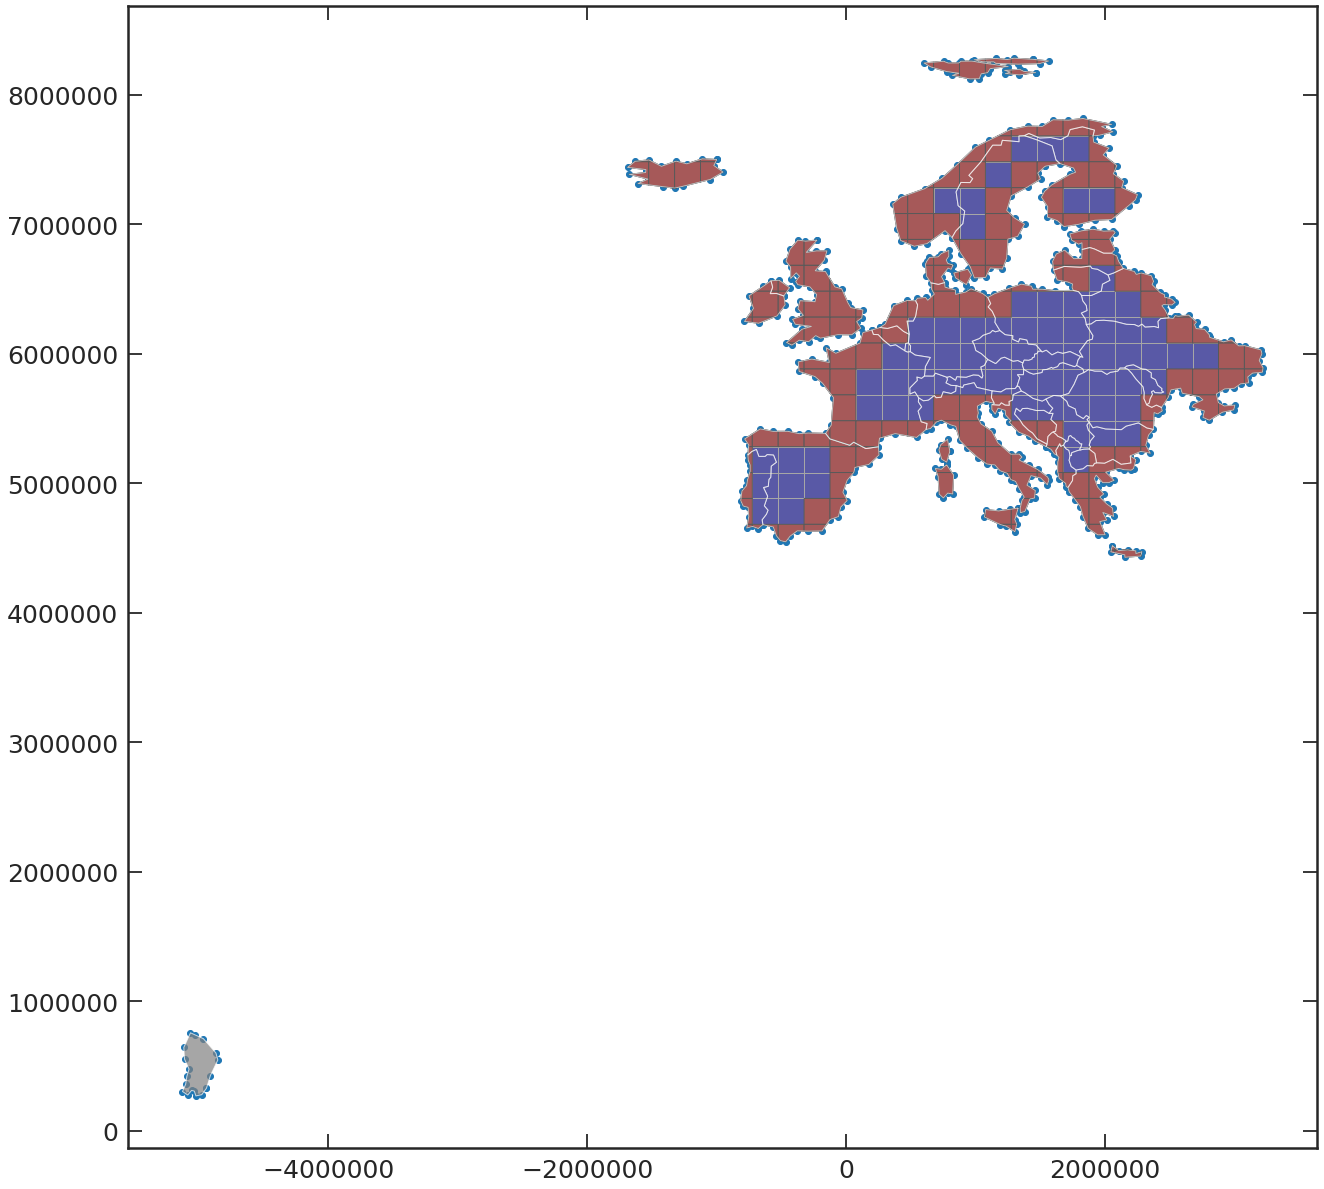

In [468]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=3))

# europe_border_pts_weck4.plot(ax=ax)
# i = 11
# grids_l[i][grids_l[i].area == 200000**2].plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 200000**2].plot(color='red', edgecolor='black', ax=ax)
# europe_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

europe_border_pts_weck4.plot(ax=ax)
# i = 10
# grids_l[i][grids_l[i].area == 200000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 200000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
# i=11
# grids_l[i][grids_l[i].area == 200000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 200000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
grids_overlay_europe_200200[grids_overlay_europe_200200.area == 200000**2].plot(color='blue', edgecolor='white', ax=ax)
grids_overlay_europe_200200[grids_overlay_europe_200200.area != 200000**2].plot(color='red', edgecolor='black', ax=ax)
europe_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

In [469]:
europe_sp_code_dict = {s:n for n, s in enumerate(europe_df['specie'])}

In [470]:
polys1 = europe_df_weck4[europe_df_weck4.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_overlay_europe_200200['geometry']

species = europe_df_weck4[europe_df_weck4.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in europe_sp_code_dict.items()],
    'code': [n for sp, n in europe_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [471]:
intersection_grids_species_gpd_europe = gpd.overlay(df1, df2, how='intersection')

In [472]:
df1.head(2)

geometry  df1  \
0  (POLYGON ((-350122.4406514364 6514848.91265550...    1   
1  (POLYGON ((-147100.9642750344 5378350.59215927...    2   

                 species  code  
0         Acorus calamus     0  
1  Aldrovanda vesiculosa     1

In [473]:
df2.head(2)

geometry  df2
0  POLYGON ((2075971.274013413 4504878.327997872,...    1
1  POLYGON ((2046762.35003953 4484166.158095203, ...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [474]:
intersection_grids_species_gpd_europe

df1                   species  code  df2  \
1        1            Acorus calamus     0  196   
266      3          Alisma gramineum     2  196   
395      4        Alisma lanceolatum     3  196   
550      5  Alisma plantago-aquatica     4  196   
1070    10             Berula erecta     9  196   
...    ...                       ...   ...  ...   
19763  139    Sparganium hyperboreum   138   83   
20410  143        Subularia aquatica   142   83   
20699  145      Trichophorum alpinum   144   83   
21394  149    Utricularia intermedia   148   83   
21765  151      Utricularia vulgaris   150   83   

                                                geometry  
1      POLYGON ((1859793.363991329 5284166.158095203,...  
266    POLYGON ((1875971.274013413 5230994.171119415,...  
395    POLYGON ((1875971.274013413 5131892.677858696,...  
550    POLYGON ((1675986.796498506 5084166.158095203,...  
1070   POLYGON ((1875971.274013413 5131892.677858696,...  
...                                                  ...  
19763  POLYGON ((1875971.274013413 7711764.069925465,...  
20410  POLYGON ((1875971.274013413 7711764.069925465,...  
20699  POLYGON ((1875971.274013413 7711764.069925465,...  
21394  POLYGON ((1875971.274013413 7711764.069925465,...  
21765  POLYGON ((1875971.274013413 7705143.434504839,...  

[15746 rows x 5 columns]

In [475]:
intersection_grids_species_gpd_europe.groupby('df2').count()

df1  species  code  geometry
df2                              
15    92       92    92        92
16    77       77    77        77
17    91       91    91        91
18   107      107   107       107
19    85       85    85        85
..   ...      ...   ...       ...
255  100      100   100       100
256  111      111   111       111
257  109      109   109       109
258   97       97    97        97
259   95       95    95        95

[172 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 1 (first one on the pd.DataFrame) has 13 occurrences while the grid 3636 (last one on the pd.DataFrame) has 18 occurrences.

In [476]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_europe.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

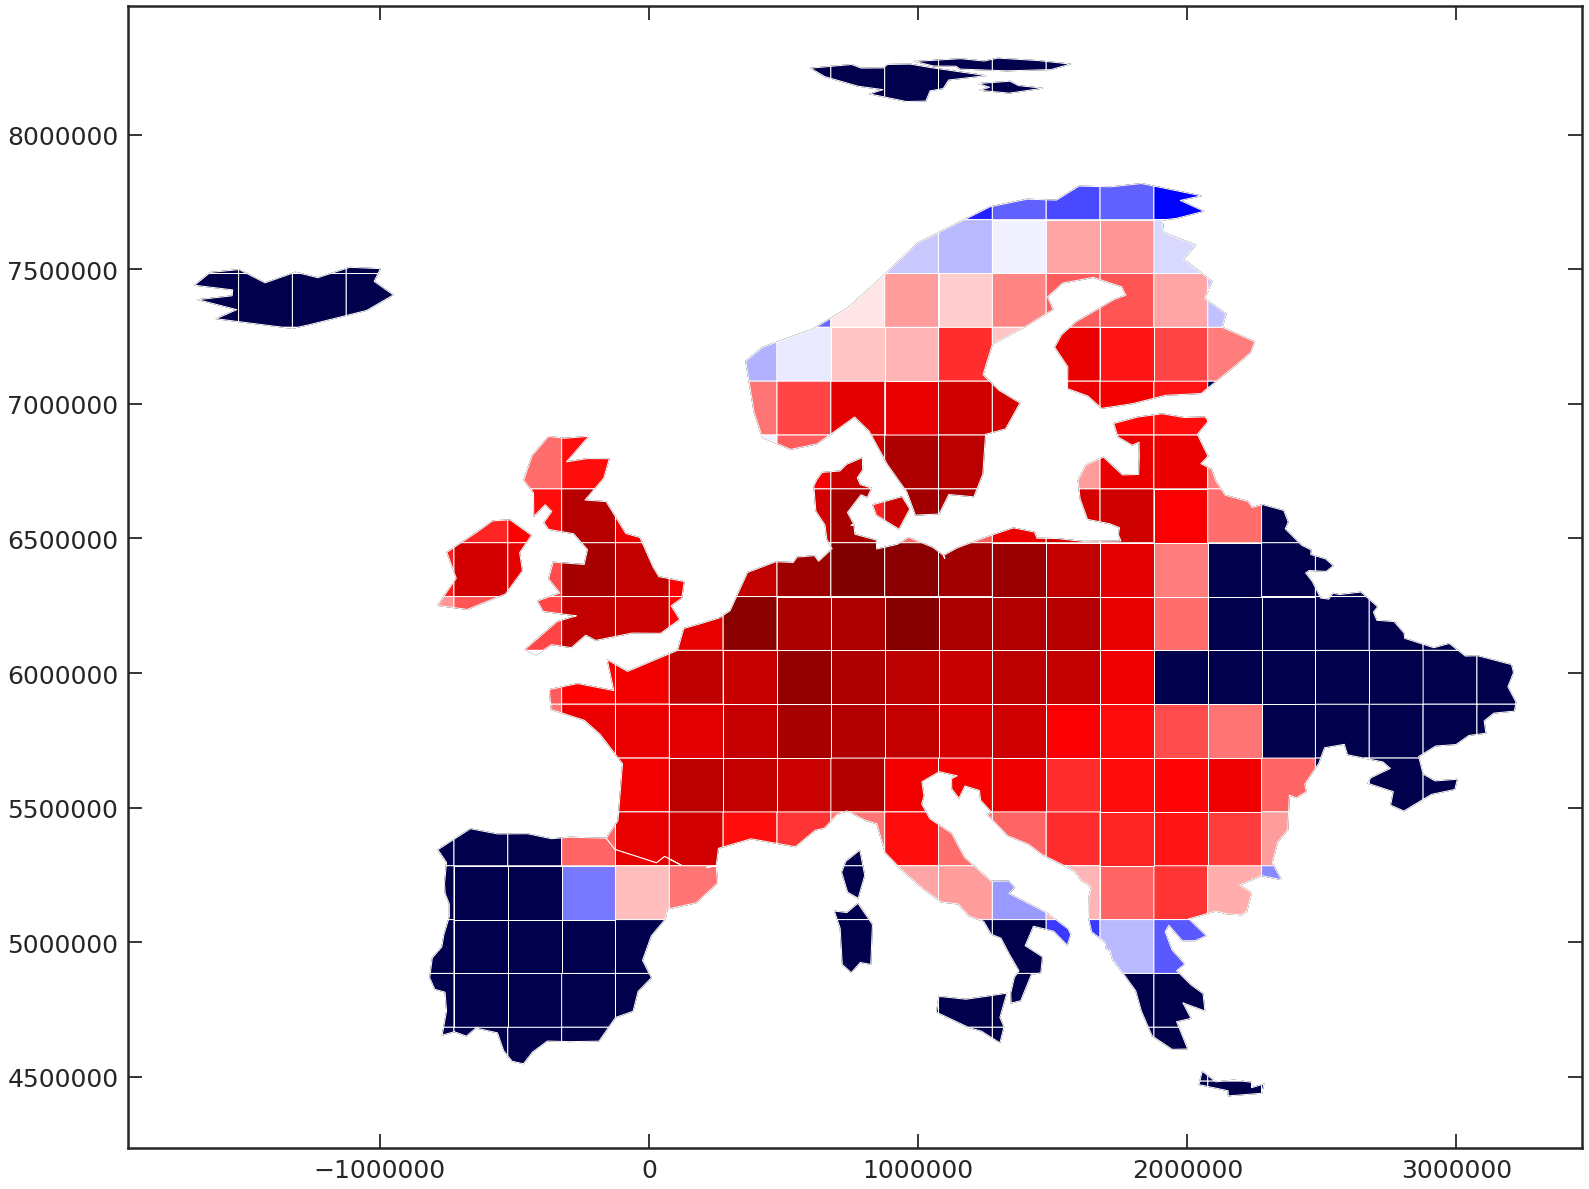

In [477]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

grids_overlay_europe_200200.plot(color='white', edgecolor='black', ax=ax)
# df2[df2.area == 200000**2].plot(column='num_species', cmap='seismic', ax=ax);
df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [478]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_europe[intersection_grids_species_gpd_europe['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(europe_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [479]:
df.head(3)

geometry  0_Acorus calamus  \
0  POLYGON ((2075971.274013413 4504878.327997872,...               0.0   
1  POLYGON ((2046762.35003953 4484166.158095203, ...               0.0   
2  (POLYGON ((2204284.860571817 4484166.158095203...               0.0   

   1_Aldrovanda vesiculosa  2_Alisma gramineum  3_Alisma lanceolatum  \
0                      0.0                 0.0                   0.0   
1                      0.0                 0.0                   0.0   
2                      0.0                 0.0                   0.0   

   4_Alisma plantago-aquatica  5_Alisma wahlenbergii  6_Apium inundatum  \
0                         0.0                    0.0                0.0   
1                         0.0                    0.0                0.0   
2                         0.0                    0.0                0.0   

   7_Azolla filiculoides  8_Baldellia ranunculoides          ...           \
0                    0.0                        0.0          ...            
1                    0.0                        0.0          ...            
2                    0.0                        0.0          ...            

   147_Utricularia australis  148_Utricularia intermedia  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   

   149_Utricularia minor  150_Utricularia vulgaris  \
0                    0.0                       0.0   
1                    0.0                       0.0   
2                    0.0                       0.0   

   151_Veronica anagallis-aquatica  152_Veronica beccabunga  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   

   153_Veronica catenata  154_Zannichellia palustris  155_Elatine alsinastrum  \
0                    0.0                         0.0                      0.0   
1                    0.0                         0.0                      0.0   
2                    0.0                         0.0                      0.0   

   156_Elatine triandra  
0                   0.0  
1                   0.0  
2                   0.0  

[3 rows x 158 columns]

We add a column with the total species that occurred within that grid.

In [480]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [481]:
occurrences_within_200200_grid_europe = gpd.GeoDataFrame(df, geometry='geometry')

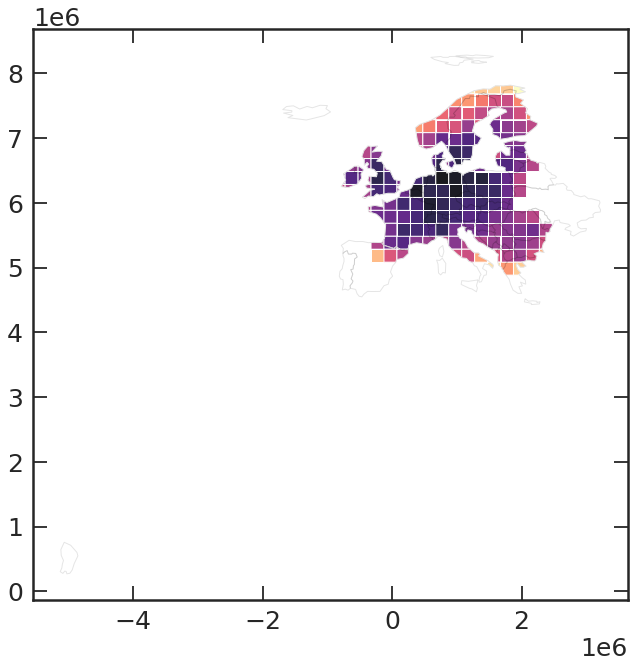

In [482]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_200200_grid_europe[occurrences_within_200200_grid_europe['Total'] != 0][['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
europe.to_crs(weck4_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [483]:
occurrences_within_200200_grid_europe = occurrences_within_200200_grid_europe[occurrences_within_200200_grid_europe['Total'] != 0]

In [484]:
occurrences_within_200200_grid_europe['grid_code'] = np.arange(occurrences_within_200200_grid_europe.shape[0])

We are going to create a file with the code relative to the species so we can track it afterwards.

In [485]:
europe_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_200200_grid_europe.columns[1:-2]], columns=['codes', 'specie'])

In [486]:
europe_code_sp

codes                    specie
0       0            Acorus calamus
1       1     Aldrovanda vesiculosa
2       2          Alisma gramineum
3       3        Alisma lanceolatum
4       4  Alisma plantago-aquatica
..    ...                       ...
152   152       Veronica beccabunga
153   153         Veronica catenata
154   154    Zannichellia palustris
155   155       Elatine alsinastrum
156   156          Elatine triandra

[157 rows x 2 columns]

In [487]:
occurrences_within_200200_grid_europe.crs

In [488]:
occurrences_within_200200_grid_europe.crs = weck4_proj_dict

In [489]:
# occurrences_within_200200_grid_europe.to_file('../results/europe/adj_matrix_200200_border_weck4/occurrences_within_200200_grid_europe_border_weck4.shp')

In [490]:
# europe_code_sp.to_csv('../results/europe/adj_matrix_200200_border_weck4/europe_code_sp.dat', sep='\t', index=False)

In [190]:
# occurrences_within_200200_grid_europe.to_crs(wgs84_proj_dict).to_file('../results/europe/adj_matrix_200200_border/occurrences_within_200200_grid_europe_border.shp')

In [191]:
# europe_code_sp.to_csv('../results/europe/adj_matrix_200200_border/europe_code_sp.dat', sep='\t', index=False)

## North America
<a id="north-america-adj-cut"></a>
<a href="#summary">Summary</a>

### $50km^2$
<a id="north-america-adj-50-cut"></a>
<a href="#summary">Summary</a>

First we have to create the grids for Europe.

In [379]:
north_america_df = north_america_sp_full[north_america_sp_full['has'] == 'y'].reset_index(drop=True)[['specie', 'geometry']]

In [380]:
north_america_weck4 = north_america.to_crs(weck4_proj_dict)

north_america_df['continent'] = ['north_america' for _ in range(north_america_df.shape[0])]

north_america_df_weck4 = north_america_df.reset_index().to_crs(weck4_proj_dict)

grids_north_america_5050 = fishnet(north_america_weck4.dissolve(by='continent'), width=50000, height=50000)

grids_north_america_5050.crs = weck4_proj_dict

north_america_border_pts_weck4 = polygon_border_coords(north_america_weck4.dissolve(by='continent')['geometry'].iloc[0])

north_america_border_pts_weck4.crs = weck4_proj_dict

In [381]:
# loop through the lands with borders
grids_l = []
for land in north_america_weck4.dissolve(by='continent')['geometry'].iloc[0]:
        
    # select the part of land with the border points
    df_tmp = polygon_border_coords(land)

    # pick the longitute and latitude
    longitude_l = df_tmp['geometry'].apply(lambda p: p.xy[0][0])
    latitude_l  = df_tmp['geometry'].apply(lambda p: p.xy[1][0])

    # create the polygon
    polygon = Polygon(zip(longitude_l, latitude_l))

    # create the gpd.GeoDataFrame
    gdf = gpd.GeoDataFrame([polygon])
    gdf.columns = ['geometry']

    # overlay grids with the created polygon
    grids_l.append(gpd.overlay(grids_north_america_5050, gdf, how='intersection'))

/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))


/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))


In [382]:
grids_overlay_north_america_5050 = pd.concat(grids_l).reset_index(drop=True)

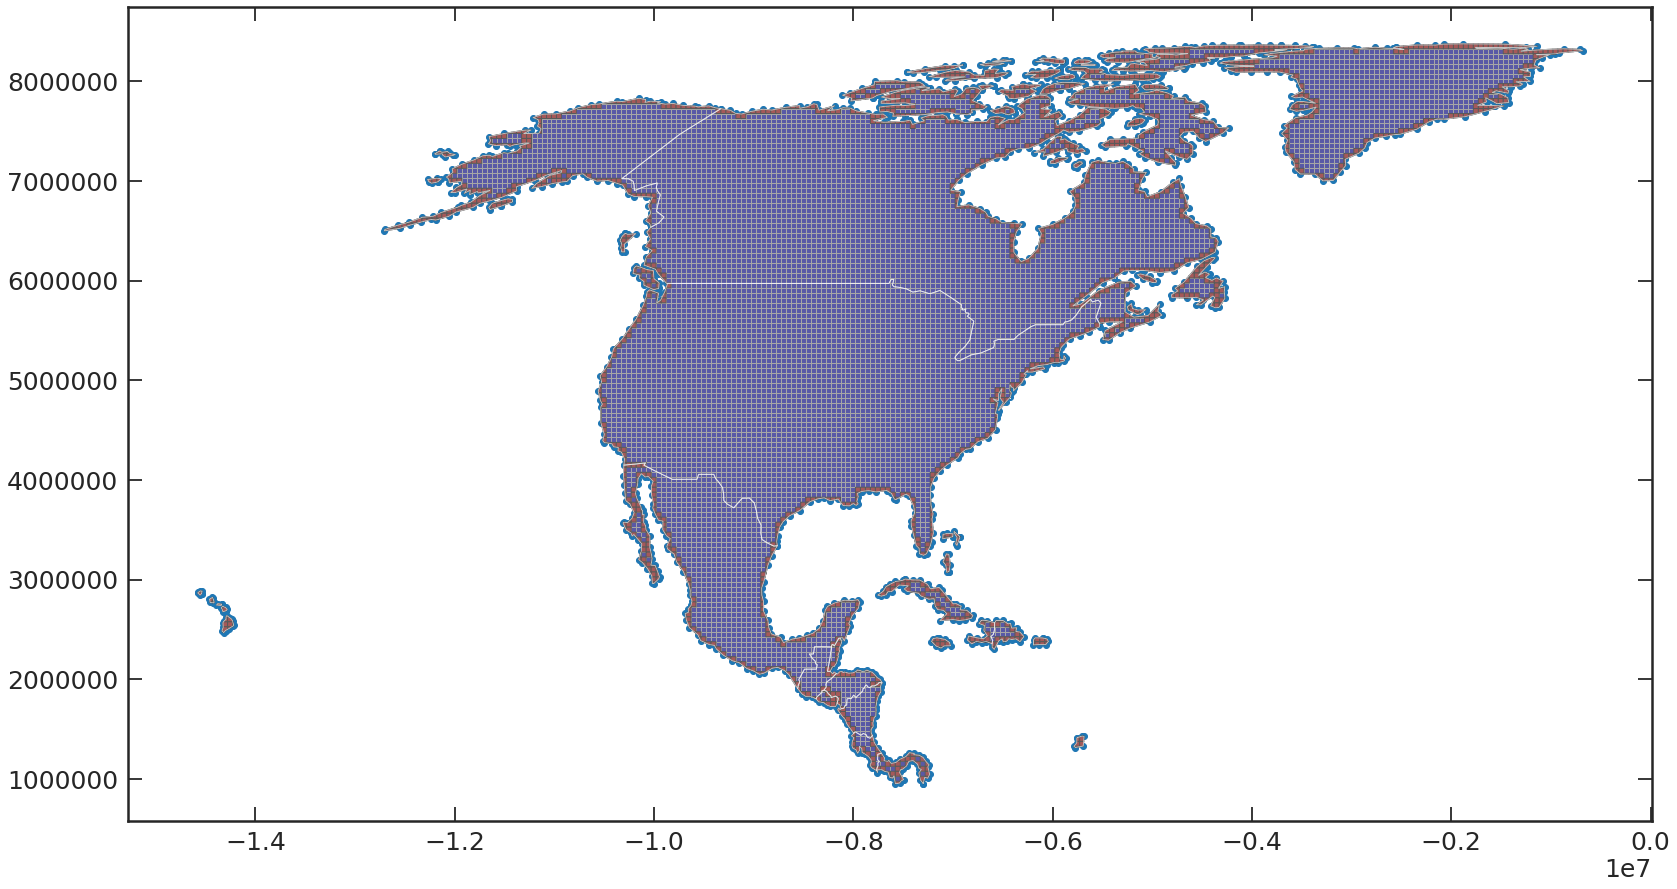

In [383]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=3))

# north_america_border_pts_weck4.plot(ax=ax)
# i = 11
# grids_l[i][grids_l[i].area == 50000**2].plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 50000**2].plot(color='red', edgecolor='black', ax=ax)
# north_america_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

north_america_border_pts_weck4.plot(ax=ax)
# i = 10
# grids_l[i][grids_l[i].area == 50000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 50000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
# i=11
# grids_l[i][grids_l[i].area == 50000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 50000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
grids_overlay_north_america_5050[grids_overlay_north_america_5050.area == 50000**2].plot(color='blue', edgecolor='white', ax=ax)
grids_overlay_north_america_5050[grids_overlay_north_america_5050.area != 50000**2].plot(color='red', edgecolor='black', ax=ax)
north_america_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

In [384]:
north_america_sp_code_dict = {s:n for n, s in enumerate(north_america_df['specie'])}

In [385]:
polys1 = north_america_df_weck4[north_america_df_weck4.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_overlay_north_america_5050['geometry']

species = north_america_df_weck4[north_america_df_weck4.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in north_america_sp_code_dict.items()],
    'code': [n for sp, n in north_america_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [386]:
intersection_grids_species_gpd_north_america = gpd.overlay(df1, df2, how='intersection')

In [387]:
df1.head(2)

geometry  df1             species  \
0  (POLYGON ((-6655061.545087925 5383422.31501802...    1    Alisma gramineum   
1  (POLYGON ((-10461059.08793221 4955071.31070782...    2  Alisma lanceolatum   

   code  
0     0  
1     1

In [388]:
df2.head(2)

geometry  df2
0  POLYGON ((-5778502.303257555 1337330.522289579...    1
1  POLYGON ((-5787524.699857878 1325779.372762301...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [389]:
intersection_grids_species_gpd_north_america

df1                   species  code    df2  \
27        1          Alisma gramineum     0   3948   
6205      4           Alisma triviale     3   3948   
26453    12             Caltha natans    11   3948   
54797    25      Equisetum fluviatile    24   3948   
81533    50       Isoetes echinospora    49   3948   
...     ...                       ...   ...    ...   
353768  163    Ranunculus hyperboreus   162   9490   
360713  165       Ranunculus pallasii   164   9490   
382531  176       Sagittaria graminea   175   7883   
406772  191  Sparganium angustifolium   190  10096   
415355  192        Sparganium emersum   191    754   

                                                 geometry  
27      POLYGON ((-8931165.485638609 6375779.372762301...  
6205    POLYGON ((-8978502.303257555 6425779.372762301...  
26453   POLYGON ((-8978502.303257555 6425779.372762301...  
54797   POLYGON ((-8978502.303257555 6425779.372762301...  
81533   POLYGON ((-8978502.303257555 6425779.372762301...  
...                                                   ...  
353768  POLYGON ((-12269146.53368121 7008312.667367538...  
360713  POLYGON ((-12269799.6263259 7009445.157435406,...  
382531  POLYGON ((-6779226.183205254 5475779.372762301...  
406772  POLYGON ((-3328502.303257555 7240968.498360868...  
415355  POLYGON ((-12078502.30325755 7034685.80816938,...  

[222142 rows x 5 columns]

In [390]:
intersection_grids_species_gpd_north_america.groupby('df2').count()

df1  species  code  geometry
df2                                
38       6        6     6         6
39       5        5     5         5
40       1        1     1         1
41       7        7     7         7
42       7        7     7         7
...    ...      ...   ...       ...
11050    3        3     3         3
11051    3        3     3         3
11052    3        3     3         3
11053    3        3     3         3
11054    3        3     3         3

[9339 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 1 (first one on the pd.DataFrame) has 13 occurrences while the grid 3636 (last one on the pd.DataFrame) has 18 occurrences.

In [391]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_north_america.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

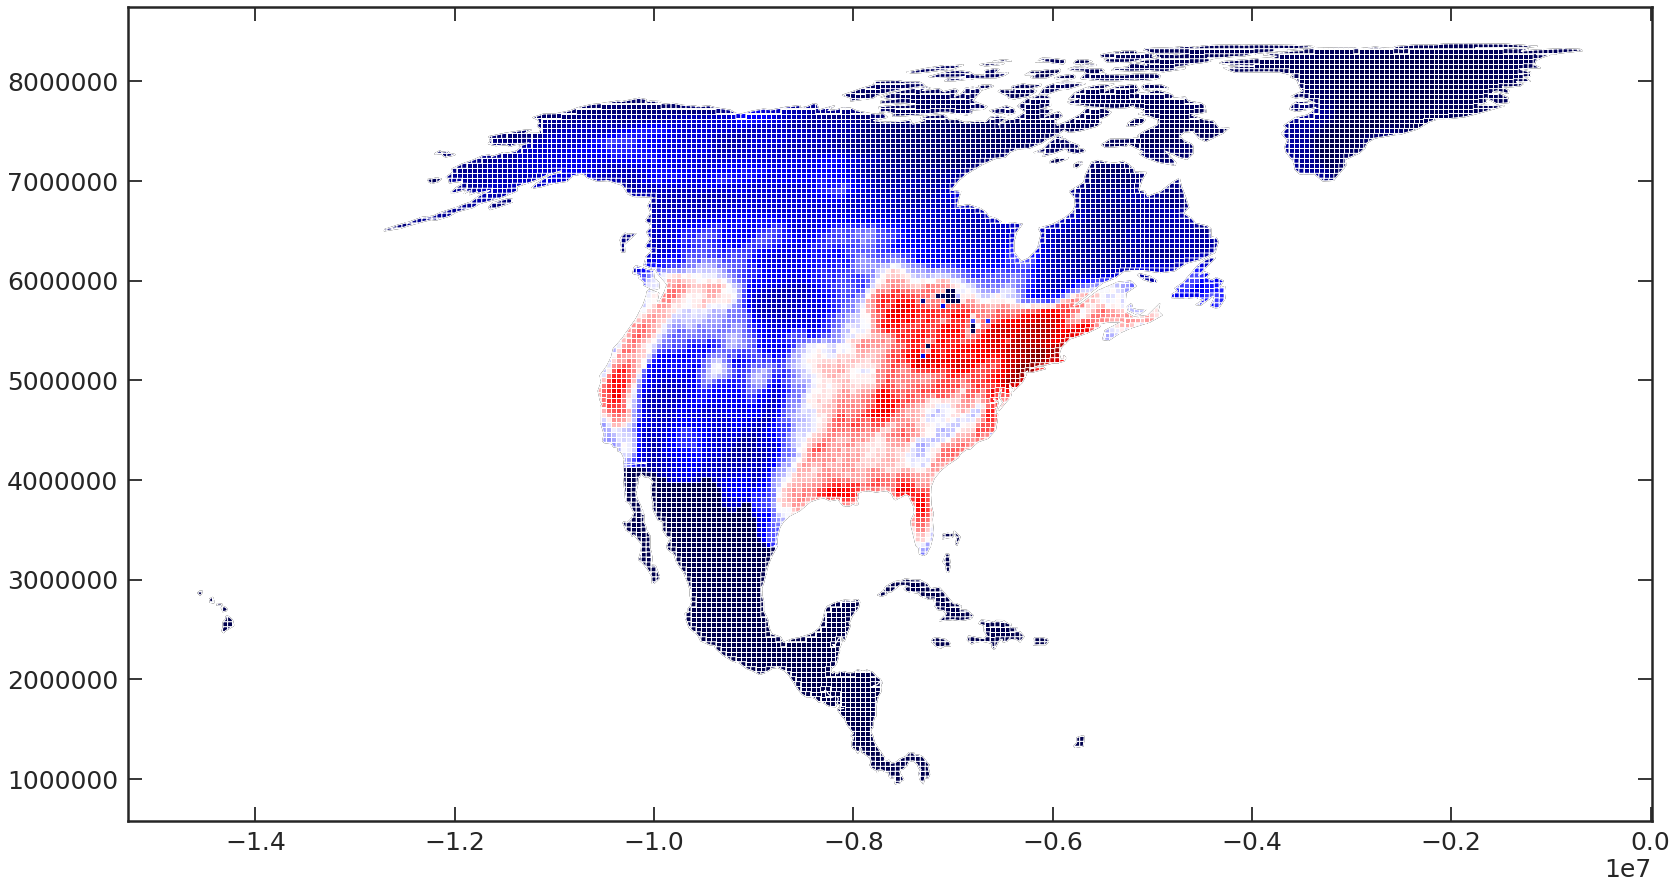

In [392]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=3))

grids_overlay_north_america_5050.plot(color='white', edgecolor='black', ax=ax)
df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [393]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_north_america[intersection_grids_species_gpd_north_america['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(north_america_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [394]:
df.head(3)

geometry  0_Alisma gramineum  \
0  POLYGON ((-5778502.303257555 1337330.522289579...                 0.0   
1  POLYGON ((-5787524.699857878 1325779.372762301...                 0.0   
2  POLYGON ((-5728502.303257555 1422392.157264411...                 0.0   

   1_Alisma lanceolatum  2_Alisma subcordatum  3_Alisma triviale  \
0                   0.0                   0.0                0.0   
1                   0.0                   0.0                0.0   
2                   0.0                   0.0                0.0   

   4_Azolla caroliniana  5_Azolla filiculoides  6_Azolla mexicana  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   
2                   0.0                    0.0                0.0   

   7_Blyxa aubertii  8_Brasenia schreberi             ...              \
0               0.0                   0.0             ...               
1               0.0                   0.0             ...               
2               0.0                   0.0             ...               

   206_Typha latifolia  207_Vallisneria americana  208_Wolffia borealis  \
0                  0.0                        0.0                   0.0   
1                  0.0                        0.0                   0.0   
2                  0.0                        0.0                   0.0   

   209_Wolffia brasiliensis  210_Wolffia columbiana  211_Wolffiella gladiata  \
0                       0.0                     0.0                      0.0   
1                       0.0                     0.0                      0.0   
2                       0.0                     0.0                      0.0   

   212_Wolffiella lingulata  213_Wolffiella oblonga  214_Wolffia globosa  \
0                       0.0                     0.0                  0.0   
1                       0.0                     0.0                  0.0   
2                       0.0                     0.0                  0.0   

   215_Zannichellia palustris  
0                         0.0  
1                         0.0  
2                         0.0  

[3 rows x 217 columns]

We add a column with the total species that occurred within that grid.

In [395]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [396]:
occurrences_within_5050_grid_north_america = gpd.GeoDataFrame(df, geometry='geometry')

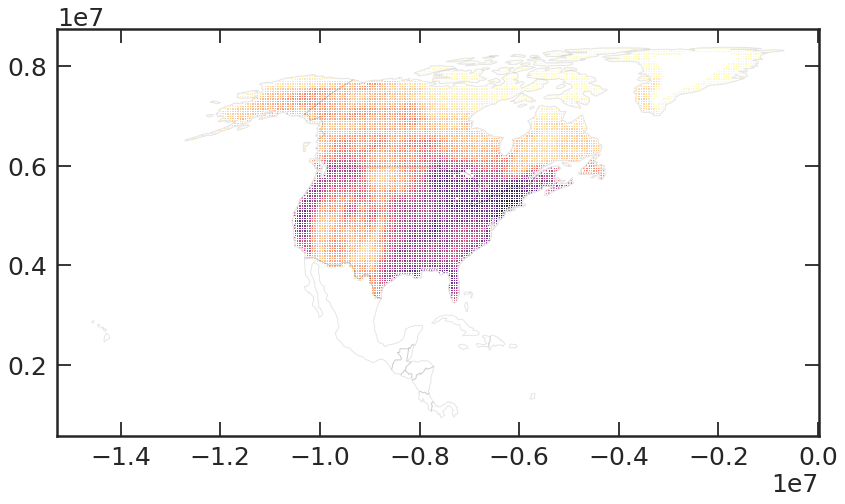

In [397]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_5050_grid_north_america[occurrences_within_5050_grid_north_america['Total'] != 0][['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
north_america.to_crs(weck4_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [398]:
occurrences_within_5050_grid_north_america = occurrences_within_5050_grid_north_america[occurrences_within_5050_grid_north_america['Total'] != 0]

In [399]:
occurrences_within_5050_grid_north_america['grid_code'] = np.arange(occurrences_within_5050_grid_north_america.shape[0])

We are going to create a file with the code relative to the species so we can track it afterwards.

In [400]:
north_america_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_5050_grid_north_america.columns[1:-2]], columns=['codes', 'specie'])

In [401]:
north_america_code_sp

codes                  specie
0       0        Alisma gramineum
1       1      Alisma lanceolatum
2       2      Alisma subcordatum
3       3         Alisma triviale
4       4      Azolla caroliniana
..    ...                     ...
211   211     Wolffiella gladiata
212   212    Wolffiella lingulata
213   213      Wolffiella oblonga
214   214         Wolffia globosa
215   215  Zannichellia palustris

[216 rows x 2 columns]

In [402]:
occurrences_within_5050_grid_north_america.crs

In [403]:
occurrences_within_5050_grid_north_america.crs = weck4_proj_dict

In [404]:
# occurrences_within_5050_grid_north_america.to_file('../results/north_america/adj_matrix_5050_border_weck4/occurrences_within_5050_grid_north_america_border_weck4.shp')

In [405]:
# north_america_code_sp.to_csv('../results/north_america/adj_matrix_5050_border_weck4/north_america_code_sp.dat', sep='\t', index=False)

In [577]:
# occurrences_within_5050_grid_north_america.to_crs(wgs84_proj_dict).to_file('../results/north_america/adj_matrix_5050_border/occurrences_within_5050_grid_north_america_border.shp')

In [578]:
# north_america_code_sp.to_csv('../results/north_america/adj_matrix_5050_border/north_america_code_sp.dat', sep='\t', index=False)

### $100km^2$
<a id="north-america-adj-100-cut"></a>
<a href="#summary">Summary</a>

First we have to create the grids for Europe.

In [434]:
north_america_df = north_america_sp_full[north_america_sp_full['has'] == 'y'].reset_index(drop=True)[['specie', 'geometry']]

In [435]:
north_america_weck4 = north_america.to_crs(weck4_proj_dict)

north_america_df['continent'] = ['north_america' for _ in range(north_america_df.shape[0])]

north_america_df_weck4 = north_america_df.reset_index().to_crs(weck4_proj_dict)

grids_north_america_100100 = fishnet(north_america_weck4.dissolve(by='continent'), width=100000, height=100000)

grids_north_america_100100.crs = weck4_proj_dict

north_america_border_pts_weck4 = polygon_border_coords(north_america_weck4.dissolve(by='continent')['geometry'].iloc[0])

north_america_border_pts_weck4.crs = weck4_proj_dict

In [436]:
# loop through the lands with borders
grids_l = []
for land in north_america_weck4.dissolve(by='continent')['geometry'].iloc[0]:
        
    # select the part of land with the border points
    df_tmp = polygon_border_coords(land)

    # pick the longitute and latitude
    longitude_l = df_tmp['geometry'].apply(lambda p: p.xy[0][0])
    latitude_l  = df_tmp['geometry'].apply(lambda p: p.xy[1][0])

    # create the polygon
    polygon = Polygon(zip(longitude_l, latitude_l))

    # create the gpd.GeoDataFrame
    gdf = gpd.GeoDataFrame([polygon])
    gdf.columns = ['geometry']

    # overlay grids with the created polygon
    grids_l.append(gpd.overlay(grids_north_america_100100, gdf, how='intersection'))

/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))


/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))


In [437]:
grids_overlay_north_america_100100 = pd.concat(grids_l).reset_index(drop=True)

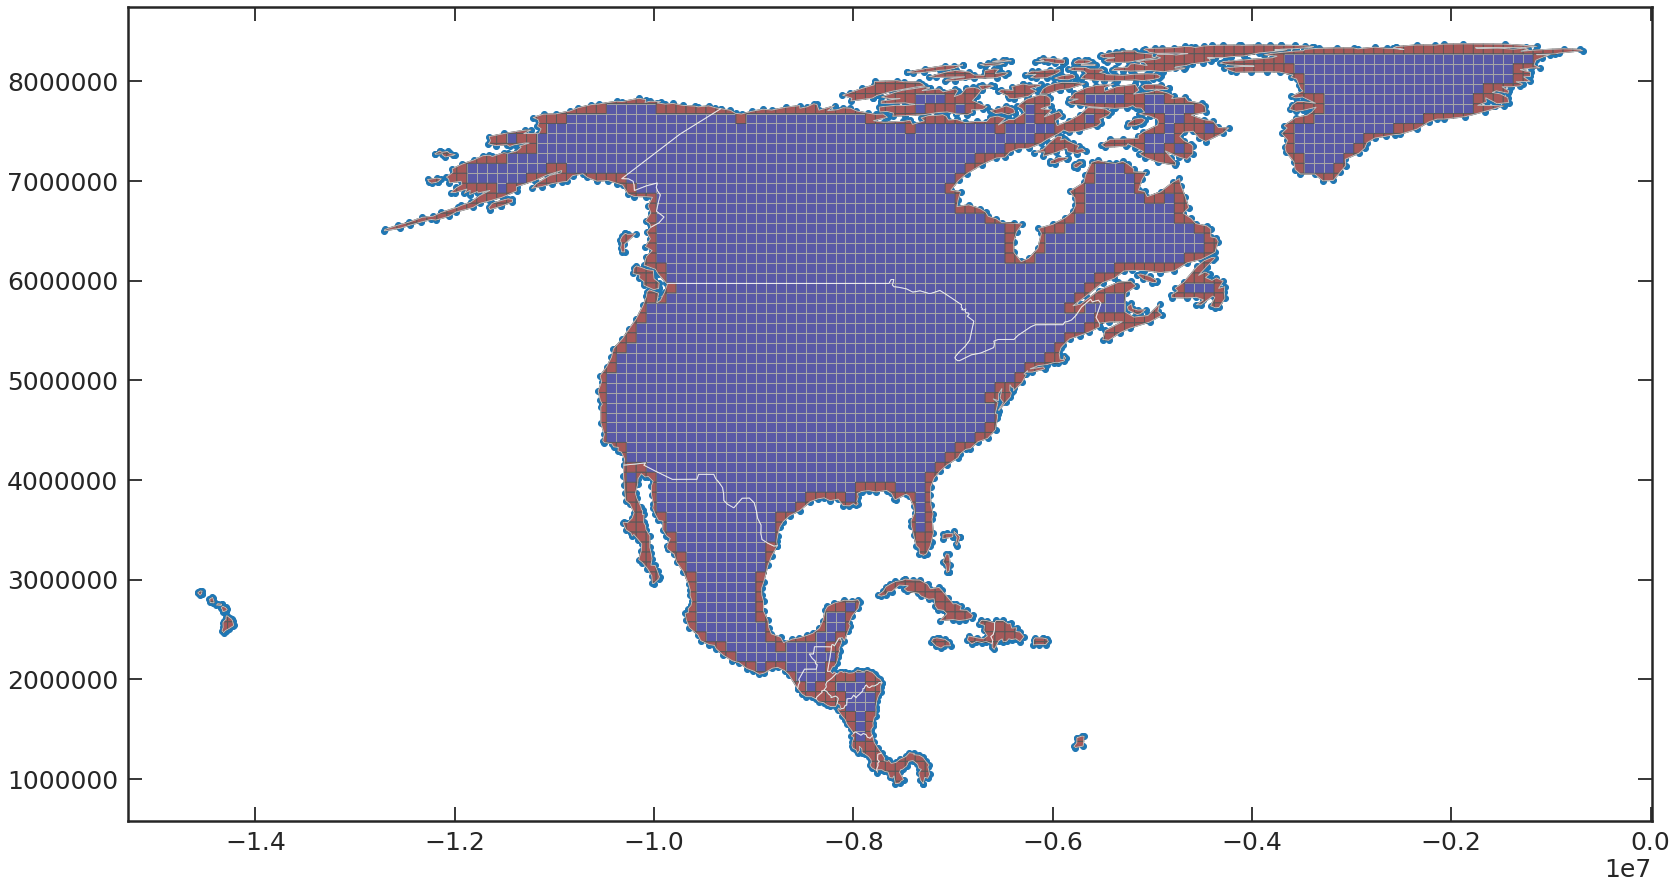

In [438]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=3))

# north_america_border_pts_weck4.plot(ax=ax)
# i = 11
# grids_l[i][grids_l[i].area == 100000**2].plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 100000**2].plot(color='red', edgecolor='black', ax=ax)
# north_america_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

north_america_border_pts_weck4.plot(ax=ax)
# i = 10
# grids_l[i][grids_l[i].area == 100000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 100000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
# i=11
# grids_l[i][grids_l[i].area == 100000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 100000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
grids_overlay_north_america_100100[grids_overlay_north_america_100100.area == 100000**2].plot(color='blue', edgecolor='white', ax=ax)
grids_overlay_north_america_100100[grids_overlay_north_america_100100.area != 100000**2].plot(color='red', edgecolor='black', ax=ax)
north_america_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

In [439]:
north_america_sp_code_dict = {s:n for n, s in enumerate(north_america_df['specie'])}

In [440]:
polys1 = north_america_df_weck4[north_america_df_weck4.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_overlay_north_america_100100['geometry']

species = north_america_df_weck4[north_america_df_weck4.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in north_america_sp_code_dict.items()],
    'code': [n for sp, n in north_america_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [441]:
intersection_grids_species_gpd_north_america = gpd.overlay(df1, df2, how='intersection')

In [442]:
df1.head(2)

geometry  df1             species  \
0  (POLYGON ((-6655061.545087925 5383422.31501802...    1    Alisma gramineum   
1  (POLYGON ((-10461059.08793221 4955071.31070782...    2  Alisma lanceolatum   

   code  
0     0  
1     1

In [443]:
df2.head(2)

geometry  df2
0  POLYGON ((-5778502.303257555 1337330.522289579...    1
1  POLYGON ((-5688313.341664319 1375779.372762301...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [444]:
intersection_grids_species_gpd_north_america

df1                  species  code   df2  \
62        1         Alisma gramineum     0  2380   
861       3       Alisma subcordatum     2  2380   
1623      4          Alisma triviale     3  2380   
4676      9       Brasenia schreberi     8  2380   
7597     15  Ceratophyllum echinatum    14  2380   
...     ...                      ...   ...   ...   
96033   163   Ranunculus hyperboreus   162  2605   
97212   165      Ranunculus pallasii   164  2605   
96034   163   Ranunculus hyperboreus   162  2607   
97213   165      Ranunculus pallasii   164  2607   
112719  192       Sparganium emersum   191   291   

                                                 geometry  
62      POLYGON ((-5899996.17723578 5575779.372762301,...  
861     POLYGON ((-5942397.468466987 5575779.372762301...  
1623    POLYGON ((-5978502.303257555 5575779.372762301...  
4676    POLYGON ((-5978502.303257555 5575779.372762301...  
7597    POLYGON ((-5978502.303257555 5575779.372762301...  
...                                                   ...  
96033   POLYGON ((-12269146.53368121 7008312.667367538...  
97212   POLYGON ((-12178502.30325755 6987116.984348407...  
96034   POLYGON ((-12133911.08826741 7021016.914424176...  
97213   POLYGON ((-12177250.35689863 6987723.294921245...  
112719  POLYGON ((-12078502.30325755 7034685.80816938,...  

[64182 rows x 5 columns]

In [445]:
intersection_grids_species_gpd_north_america.groupby('df2').count()

df1  species  code  geometry
df2                               
19      7        7     7         7
20      7        7     7         7
21      7        7     7         7
22     38       38    38        38
23     22       22    22        22
...   ...      ...   ...       ...
3072    3        3     3         3
3073    3        3     3         3
3074    3        3     3         3
3075    3        3     3         3
3076    3        3     3         3

[2589 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 1 (first one on the pd.DataFrame) has 13 occurrences while the grid 3636 (last one on the pd.DataFrame) has 18 occurrences.

In [446]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_north_america.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

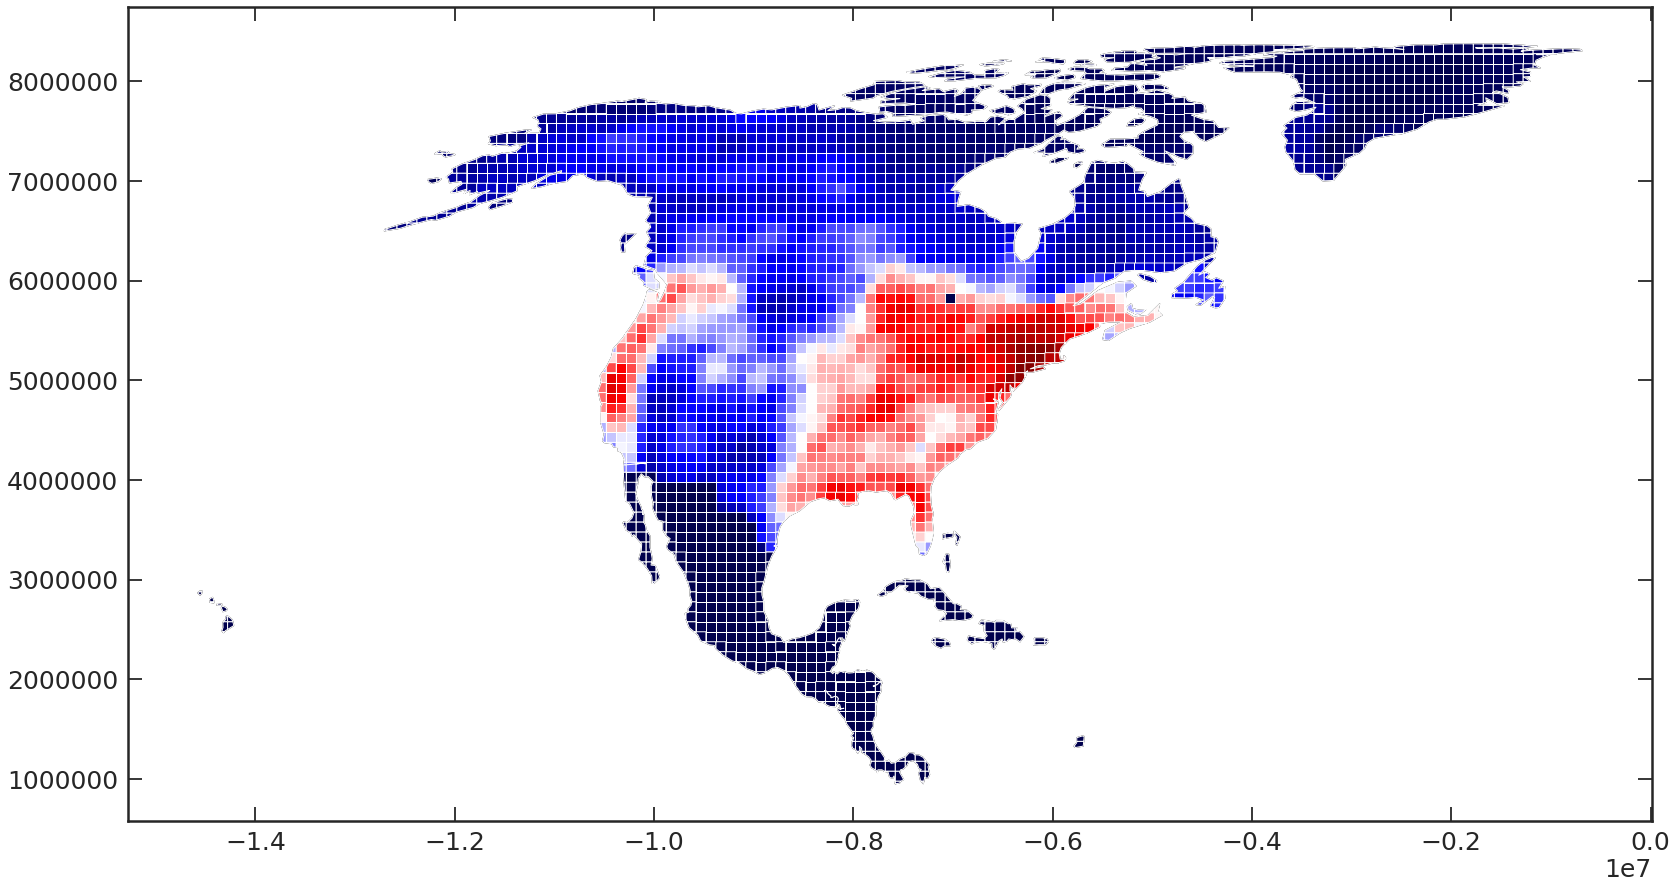

In [447]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=3))

grids_overlay_north_america_100100.plot(color='white', edgecolor='black', ax=ax)
df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [448]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_north_america[intersection_grids_species_gpd_north_america['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(north_america_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [449]:
df.head(3)

geometry  0_Alisma gramineum  \
0  POLYGON ((-5778502.303257555 1337330.522289579...                 0.0   
1  POLYGON ((-5688313.341664319 1375779.372762301...                 0.0   
2  POLYGON ((-5758371.996477874 1375779.372762301...                 0.0   

   1_Alisma lanceolatum  2_Alisma subcordatum  3_Alisma triviale  \
0                   0.0                   0.0                0.0   
1                   0.0                   0.0                0.0   
2                   0.0                   0.0                0.0   

   4_Azolla caroliniana  5_Azolla filiculoides  6_Azolla mexicana  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   
2                   0.0                    0.0                0.0   

   7_Blyxa aubertii  8_Brasenia schreberi             ...              \
0               0.0                   0.0             ...               
1               0.0                   0.0             ...               
2               0.0                   0.0             ...               

   206_Typha latifolia  207_Vallisneria americana  208_Wolffia borealis  \
0                  0.0                        0.0                   0.0   
1                  0.0                        0.0                   0.0   
2                  0.0                        0.0                   0.0   

   209_Wolffia brasiliensis  210_Wolffia columbiana  211_Wolffiella gladiata  \
0                       0.0                     0.0                      0.0   
1                       0.0                     0.0                      0.0   
2                       0.0                     0.0                      0.0   

   212_Wolffiella lingulata  213_Wolffiella oblonga  214_Wolffia globosa  \
0                       0.0                     0.0                  0.0   
1                       0.0                     0.0                  0.0   
2                       0.0                     0.0                  0.0   

   215_Zannichellia palustris  
0                         0.0  
1                         0.0  
2                         0.0  

[3 rows x 217 columns]

We add a column with the total species that occurred within that grid.

In [450]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [451]:
occurrences_within_100100_grid_north_america = gpd.GeoDataFrame(df, geometry='geometry')

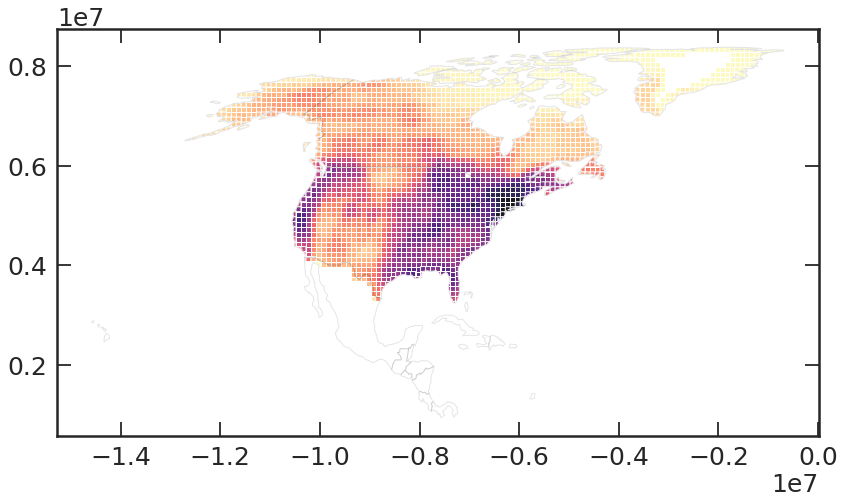

In [452]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_100100_grid_north_america[occurrences_within_100100_grid_north_america['Total'] != 0][['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
north_america.to_crs(weck4_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [453]:
occurrences_within_100100_grid_north_america = occurrences_within_100100_grid_north_america[occurrences_within_100100_grid_north_america['Total'] != 0]

In [454]:
occurrences_within_100100_grid_north_america['grid_code'] = np.arange(occurrences_within_100100_grid_north_america.shape[0])

We are going to create a file with the code relative to the species so we can track it afterwards.

In [455]:
north_america_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_100100_grid_north_america.columns[1:-2]], columns=['codes', 'specie'])

In [456]:
north_america_code_sp

codes                  specie
0       0        Alisma gramineum
1       1      Alisma lanceolatum
2       2      Alisma subcordatum
3       3         Alisma triviale
4       4      Azolla caroliniana
..    ...                     ...
211   211     Wolffiella gladiata
212   212    Wolffiella lingulata
213   213      Wolffiella oblonga
214   214         Wolffia globosa
215   215  Zannichellia palustris

[216 rows x 2 columns]

In [457]:
occurrences_within_100100_grid_north_america.crs

In [458]:
occurrences_within_100100_grid_north_america.crs = weck4_proj_dict

In [459]:
# occurrences_within_100100_grid_north_america.to_file('../results/north_america/adj_matrix_100100_border_weck4/occurrences_within_100100_grid_north_america_border_weck4.shp')

In [460]:
# north_america_code_sp.to_csv('../results/north_america/adj_matrix_100100_border_weck4/north_america_code_sp.dat', sep='\t', index=False)

In [550]:
# occurrences_within_100100_grid_north_america.to_crs(wgs84_proj_dict).to_file('../results/north_america/adj_matrix_100100_border/occurrences_within_100100_grid_north_america_border.shp')

In [551]:
# north_america_code_sp.to_csv('../results/north_america/adj_matrix_100100_border/north_america_code_sp.dat', sep='\t', index=False)

### $200km^2$
<a id="north-america-adj-200-cut"></a>
<a href="#summary">Summary</a>

First we have to create the grids for Europe.

In [258]:
north_america_sp_full = gpd.read_file('../results/north_america/complete_data/complete_sp_data_abbrev_name_north_america.shp')

In [260]:
north_america_df = north_america_sp_full[north_america_sp_full['has'] == 'y'].reset_index(drop=True)[['specie', 'geometry']]

In [261]:
north_america_weck4 = north_america.to_crs(weck4_proj_dict)

north_america_df['continent'] = ['north_america' for _ in range(north_america_df.shape[0])]

north_america_df_weck4 = north_america_df.reset_index().to_crs(weck4_proj_dict)

grids_north_america_200200 = fishnet(north_america_weck4.dissolve(by='continent'), width=200000, height=200000)

grids_north_america_200200.crs = weck4_proj_dict

north_america_border_pts_weck4 = polygon_border_coords(north_america_weck4.dissolve(by='continent')['geometry'].iloc[0])

north_america_border_pts_weck4.crs = weck4_proj_dict

In [262]:
# loop through the lands with borders
grids_l = []
for land in north_america_weck4.dissolve(by='continent')['geometry'].iloc[0]:
        
    # select the part of land with the border points
    df_tmp = polygon_border_coords(land)

    # pick the longitute and latitude
    longitude_l = df_tmp['geometry'].apply(lambda p: p.xy[0][0])
    latitude_l  = df_tmp['geometry'].apply(lambda p: p.xy[1][0])

    # create the polygon
    polygon = Polygon(zip(longitude_l, latitude_l))

    # create the gpd.GeoDataFrame
    gdf = gpd.GeoDataFrame([polygon])
    gdf.columns = ['geometry']

    # overlay grids with the created polygon
    grids_l.append(gpd.overlay(grids_north_america_200200, gdf, how='intersection'))

/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))


/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs and None
  other.crs))


In [263]:
grids_overlay_north_america_200200 = pd.concat(grids_l).reset_index(drop=True)

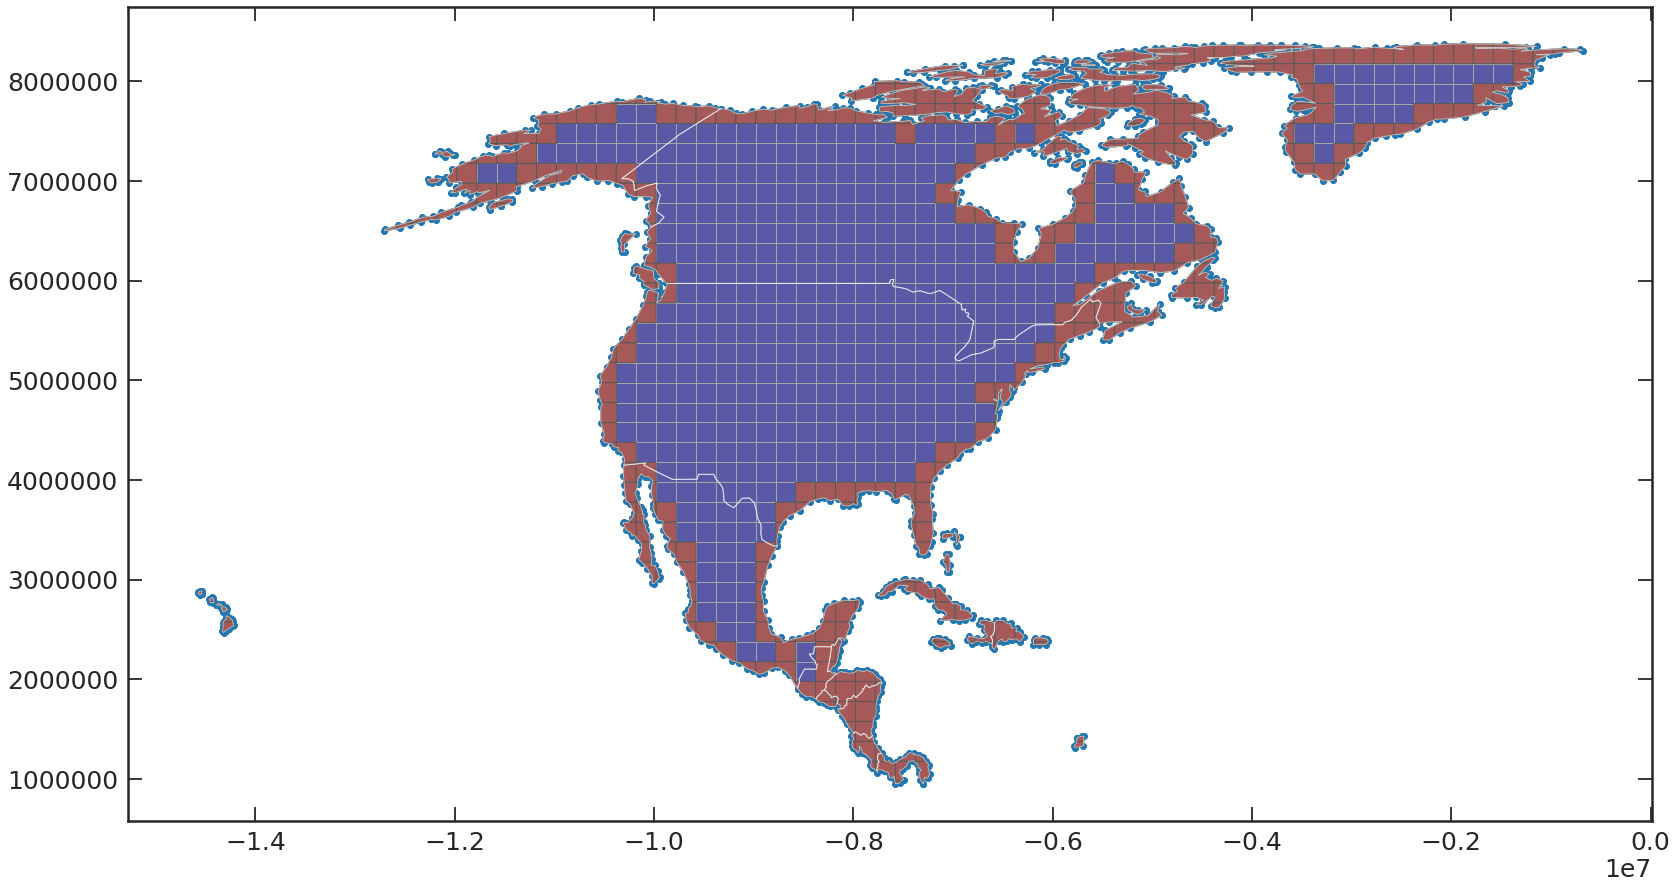

In [264]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=3))

# north_america_border_pts_weck4.plot(ax=ax)
# i = 11
# grids_l[i][grids_l[i].area == 200000**2].plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 200000**2].plot(color='red', edgecolor='black', ax=ax)
# north_america_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

north_america_border_pts_weck4.plot(ax=ax)
# i = 10
# grids_l[i][grids_l[i].area == 200000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 200000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
# i=11
# grids_l[i][grids_l[i].area == 200000**2].to_crs(wgs84_proj_dict).plot(color='blue', edgecolor='white', ax=ax)
# grids_l[i][grids_l[i].area != 200000**2].to_crs(wgs84_proj_dict).plot(color='red', edgecolor='black', ax=ax)
grids_overlay_north_america_200200[grids_overlay_north_america_200200.area == 200000**2].plot(color='blue', edgecolor='white', ax=ax)
grids_overlay_north_america_200200[grids_overlay_north_america_200200.area != 200000**2].plot(color='red', edgecolor='black', ax=ax)
north_america_weck4.plot(color='grey', edgecolor='white', alpha=0.7, ax=ax)

In [265]:
north_america_sp_code_dict = {s:n for n, s in enumerate(north_america_df['specie'])}

In [266]:
polys1 = north_america_df_weck4[north_america_df_weck4.area != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_overlay_north_america_200200['geometry']

species = north_america_df_weck4[north_america_df_weck4.area != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in north_america_sp_code_dict.items()],
    'code': [n for sp, n in north_america_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

In [267]:
intersection_grids_species_gpd_north_america = gpd.overlay(df1, df2, how='intersection')

In [268]:
df1.head(2)

geometry  df1             species  \
0  (POLYGON ((-6655061.545087925 5383422.31501802...    1    Alisma gramineum   
1  (POLYGON ((-10461059.08793221 4955071.31070782...    2  Alisma lanceolatum   

   code  
0     0  
1     1

In [269]:
df2.head(2)

geometry  df2
0  POLYGON ((-5778502.303257555 1337330.522289579...    1
1  POLYGON ((-5688313.341664319 1375779.372762301...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [270]:
intersection_grids_species_gpd_north_america

df1                 species  code  df2  \
35       1        Alisma gramineum     0  674   
259      3      Alisma subcordatum     2  674   
467      4         Alisma triviale     3  674   
785      5      Azolla caroliniana     4  674   
1302     9      Brasenia schreberi     8  674   
...    ...                     ...   ...  ...   
27599  165     Ranunculus pallasii   164  778   
27224  163  Ranunculus hyperboreus   162  777   
27600  165     Ranunculus pallasii   164  777   
27225  163  Ranunculus hyperboreus   162  779   
27601  165     Ranunculus pallasii   164  779   

                                                geometry  
35     POLYGON ((-6378502.303257555 5368239.895345373...  
259    POLYGON ((-6578502.303257555 5375779.372762301...  
467    POLYGON ((-6378502.303257555 5271409.054746284...  
785    POLYGON ((-6578502.303257555 5339985.348716469...  
1302   POLYGON ((-6578502.303257555 5363451.482519393...  
...                                                  ...  
27599  POLYGON ((-12233175.24578838 6975779.372762301...  
27224  POLYGON ((-12269146.53368121 7008312.667367538...  
27600  POLYGON ((-12178502.30325755 6987116.984348407...  
27225  POLYGON ((-12133911.08826741 7021016.914424176...  
27601  POLYGON ((-12177250.35689863 6987723.294921245...  

[20199 rows x 5 columns]

In [271]:
intersection_grids_species_gpd_north_america.groupby('df2').count()

df1  species  code  geometry
df2                              
13     7        7     7         7
14     7        7     7         7
15    38       38    38        38
16    39       39    39        39
17    20       20    20        20
..   ...      ...   ...       ...
929    3        3     3         3
930    3        3     3         3
931    3        3     3         3
932    3        3     3         3
933    3        3     3         3

[773 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 1 (first one on the pd.DataFrame) has 13 occurrences while the grid 3636 (last one on the pd.DataFrame) has 18 occurrences.

In [272]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_north_america.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

In [279]:
df2.crs = weck4_proj_dict

In [284]:
df2.to_crs(wgs84_proj_dict).to_crs(weck4_proj_dict)[df2.to_crs(wgs84_proj_dict).to_crs(weck4_proj_dict).area == 200000**2]

geometry  df2  num_species
175  POLYGON ((-10578502.30325756 7575779.372762298...  176         28.0
193  POLYGON ((-10378502.30325755 5175779.372762301...  194         76.0
218  POLYGON ((-10178502.30325755 4775779.3727623, ...  219         33.0
231  POLYGON ((-9978502.303257553 7375779.3727623, ...  232         24.0
232  POLYGON ((-9978502.303257557 7175779.3727623, ...  233         26.0
..                                                 ...  ...          ...
642  POLYGON ((-6978502.303257555 4975779.3727623, ...  643         71.0
643  POLYGON ((-6978502.303257555 4775779.3727623, ...  644         68.0
658  POLYGON ((-6778502.303257553 5175779.372762301...  659         77.0
660  POLYGON ((-6778502.303257555 4775779.3727623, ...  661         71.0
760  POLYGON ((-4978502.303257554 6775779.372762302...  761         14.0

[50 rows x 3 columns]

In [287]:
occurrences_200200_north_america_wgs84.to_crs(weck4_proj_dict)[occurrences_200200_north_america_wgs84.to_crs(weck4_proj_dict).area == 200000**2]

0_Alisma gramineum  1_Alisma lanceolatum  2_Alisma subcordatum  \
128                 0.0                   0.0                   0.0   
146                 1.0                   1.0                   0.0   
168                 0.0                   0.0                   0.0   
175                 0.0                   0.0                   0.0   
176                 0.0                   0.0                   0.0   
..                  ...                   ...                   ...   
499                 0.0                   0.0                   1.0   
500                 0.0                   0.0                   1.0   
515                 0.0                   0.0                   1.0   
517                 0.0                   0.0                   1.0   
617                 0.0                   0.0                   0.0   

     3_Alisma triviale  4_Azolla caroliniana  5_Azolla filiculoides  \
128                0.0                   0.0                    0.0   
146                1.0                   0.0                    1.0   
168                0.0                   0.0                    1.0   
175                0.0                   0.0                    0.0   
176                0.0                   0.0                    0.0   
..                 ...                   ...                    ...   
499                1.0                   1.0                    0.0   
500                0.0                   1.0                    0.0   
515                1.0                   1.0                    0.0   
517                0.0                   1.0                    0.0   
617                0.0                   0.0                    0.0   

     6_Azolla mexicana  7_Blyxa aubertii  8_Brasenia schreberi  \
128                0.0               0.0                   0.0   
146                1.0               0.0                   1.0   
168                1.0               0.0                   0.0   
175                0.0               0.0                   0.0   
176                0.0               0.0                   0.0   
..                 ...               ...                   ...   
499                0.0               0.0                   1.0   
500                0.0               0.0                   1.0   
515                0.0               0.0                   1.0   
517                0.0               0.0                   1.0   
617                0.0               0.0                   0.0   

     9_Butomus umbellatus                        ...                          \
128                   0.0                        ...                           
146                   0.0                        ...                           
168                   0.0                        ...                           
175                   0.0                        ...                           
176                   0.0                        ...                           
..                    ...                        ...                           
499                   0.0                        ...                           
500                   0.0                        ...                           
515                   0.0                        ...                           
517                   0.0                        ...                           
617                   0.0                        ...                           

     209_Wolffia brasiliensis  210_Wolffia columbiana  \
128                       0.0                     0.0   
146                       0.0                     0.0   
168                       0.0                     0.0   
175                       0.0                     0.0   
176                       0.0                     0.0   
..                        ...                     ...   
499                       1.0                     1.0   
500                       1.0                     1.0   
515                       1.0   

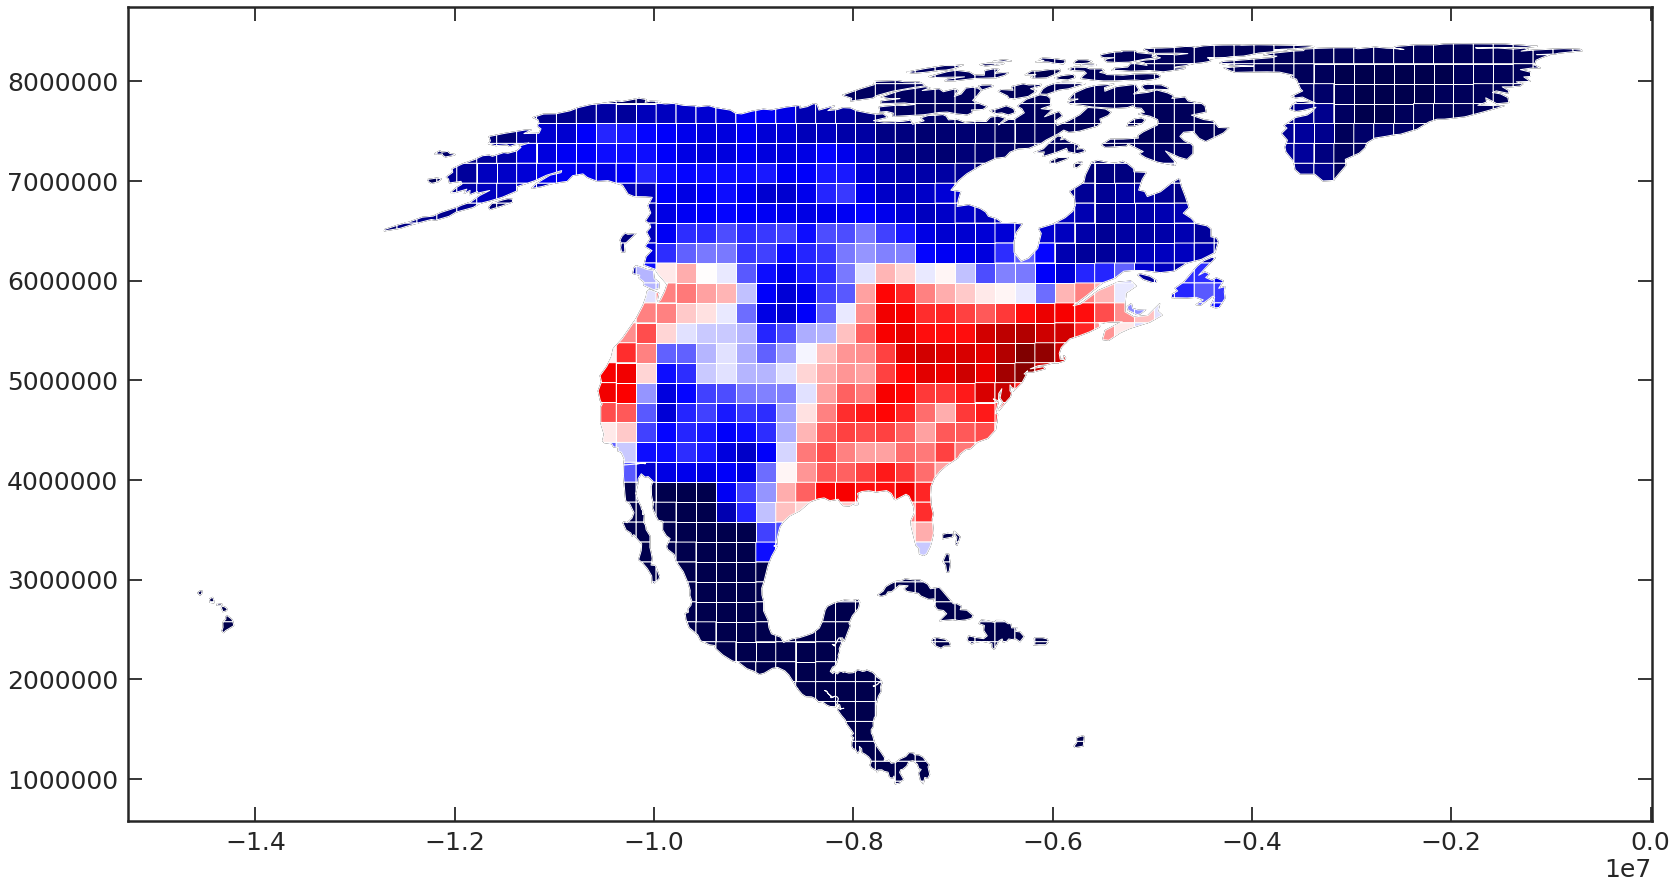

In [290]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=3))

grids_overlay_north_america_200200.plot(color='white', edgecolor='black', ax=ax)
df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [291]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_north_america[intersection_grids_species_gpd_north_america['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(north_america_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [292]:
df.head(3)

geometry  0_Alisma gramineum  \
0  POLYGON ((-5778502.303257555 1337330.522289579...                 0.0   
1  POLYGON ((-5688313.341664319 1375779.372762301...                 0.0   
2  POLYGON ((-5758371.996477874 1375779.372762301...                 0.0   

   1_Alisma lanceolatum  2_Alisma subcordatum  3_Alisma triviale  \
0                   0.0                   0.0                0.0   
1                   0.0                   0.0                0.0   
2                   0.0                   0.0                0.0   

   4_Azolla caroliniana  5_Azolla filiculoides  6_Azolla mexicana  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   
2                   0.0                    0.0                0.0   

   7_Blyxa aubertii  8_Brasenia schreberi             ...              \
0               0.0                   0.0             ...               
1               0.0                   0.0             ...               
2               0.0                   0.0             ...               

   206_Typha latifolia  207_Vallisneria americana  208_Wolffia borealis  \
0                  0.0                        0.0                   0.0   
1                  0.0                        0.0                   0.0   
2                  0.0                        0.0                   0.0   

   209_Wolffia brasiliensis  210_Wolffia columbiana  211_Wolffiella gladiata  \
0                       0.0                     0.0                      0.0   
1                       0.0                     0.0                      0.0   
2                       0.0                     0.0                      0.0   

   212_Wolffiella lingulata  213_Wolffiella oblonga  214_Wolffia globosa  \
0                       0.0                     0.0                  0.0   
1                       0.0                     0.0                  0.0   
2                       0.0                     0.0                  0.0   

   215_Zannichellia palustris  
0                         0.0  
1                         0.0  
2                         0.0  

[3 rows x 217 columns]

We add a column with the total species that occurred within that grid.

In [293]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [294]:
occurrences_within_200200_grid_north_america = gpd.GeoDataFrame(df, geometry='geometry')

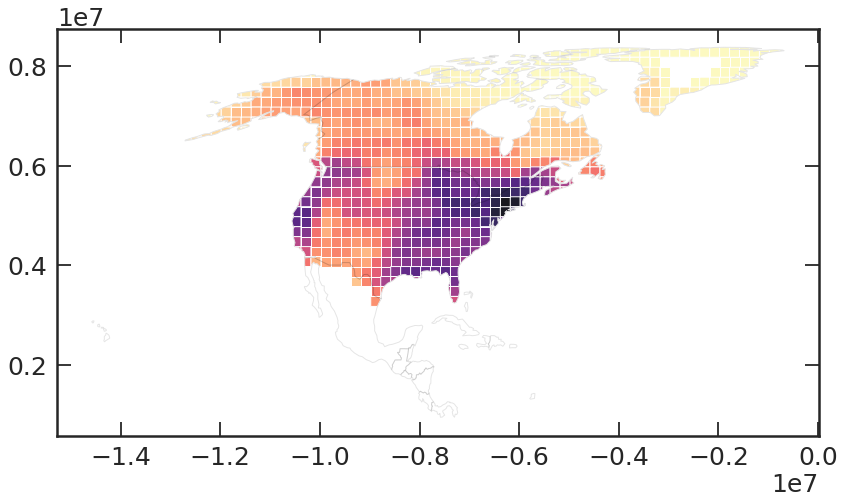

In [295]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_200200_grid_north_america[occurrences_within_200200_grid_north_america['Total'] != 0][['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
north_america.to_crs(weck4_proj_dict).plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [296]:
occurrences_within_200200_grid_north_america = occurrences_within_200200_grid_north_america[occurrences_within_200200_grid_north_america['Total'] != 0]

In [297]:
occurrences_within_200200_grid_north_america['grid_code'] = np.arange(occurrences_within_200200_grid_north_america.shape[0])

We are going to create a file with the code relative to the species so we can track it afterwards.

In [298]:
north_america_code_sp = pd.DataFrame([[item.split('_')[0], item.split('_')[1]] for item in occurrences_within_200200_grid_north_america.columns[1:-2]], columns=['codes', 'specie'])

In [299]:
north_america_code_sp

codes                  specie
0       0        Alisma gramineum
1       1      Alisma lanceolatum
2       2      Alisma subcordatum
3       3         Alisma triviale
4       4      Azolla caroliniana
..    ...                     ...
211   211     Wolffiella gladiata
212   212    Wolffiella lingulata
213   213      Wolffiella oblonga
214   214         Wolffia globosa
215   215  Zannichellia palustris

[216 rows x 2 columns]

In [300]:
occurrences_within_200200_grid_north_america.crs

In [301]:
occurrences_within_200200_grid_north_america.crs = weck4_proj_dict

In [302]:
# occurrences_within_200200_grid_north_america.to_file('../results/north_america/adj_matrix_200200_border_weck4/occurrences_within_200200_grid_north_america_border_weck4.shp')

In [303]:
# north_america_code_sp.to_csv('../results/north_america/adj_matrix_200200_border_weck4/north_america_code_sp.dat', sep='\t', index=False)

In [523]:
# occurrences_within_200200_grid_north_america.to_crs(wgs84_proj_dict).to_file('../results/north_america/adj_matrix_200200_border/occurrences_within_200200_grid_north_america_border.shp')

In [524]:
# north_america_code_sp.to_csv('../results/north_america/adj_matrix_200200_border/north_america_code_sp.dat', sep='\t', index=False)

# Adjacency matrix common species
<a id="adjacency-matrix-common-species"></a>
<a href="#summary">Summary</a>

In [387]:
occurrences_5050_europe_wgs84   = gpd.read_file('results/europe/adj_matrix_5050/occurrences_within_5050_grid_europe.shp')
occurrences_100100_europe_wgs84 = gpd.read_file('results/europe/adj_matrix_100100/occurrences_within_100100_grid_europe.shp')
occurrences_200200_europe_wgs84 = gpd.read_file('results/europe/adj_matrix_200200/occurrences_within_200200_grid_europe.shp')

occurrences_5050_north_america_wgs84   = gpd.read_file('results/north_america/adj_matrix_5050/occurrences_within_5050_grid_north_america.shp')
occurrences_100100_north_america_wgs84 = gpd.read_file('results/north_america/adj_matrix_100100/occurrences_within_100100_grid_north_america.shp')
occurrences_200200_north_america_wgs84 = gpd.read_file('results/north_america/adj_matrix_200200/occurrences_within_200200_grid_north_america.shp')

In [399]:
occurrences_5050_europe_wgs84.columns   = list(pd.read_table('results/tmp_eu.dat')['specie']) + ['Total', 'grid_code', 'geometry']
occurrences_100100_europe_wgs84.columns = list(pd.read_table('results/tmp_eu.dat')['specie']) + ['Total', 'grid_code', 'geometry']
occurrences_200200_europe_wgs84.columns = list(pd.read_table('results/tmp_eu.dat')['specie']) + ['Total', 'grid_code', 'geometry']

In [226]:
sp_abbrev_north_america = pd.read_table('results/sp_abbrev_north_america_old.dat')
sp_abbrev_north_america.head()

name abbreviation has
0    Alisma gramineum     AlisGram   y
1  Alisma lanceolatum     AlisLanc   y
2  Alisma subcordatum     AlisSubc   y
3     Alisma triviale     AlisTriv   y
4  Azolla caroliniana   AzolCaro_g   y

In [408]:
occurrences_5050_north_america_wgs84.columns   = list(sp_abbrev_north_america[sp_abbrev_north_america['has'] == 'y']['name']) + ['Total', 'grid_code', 'geometry']
occurrences_100100_north_america_wgs84.columns = list(sp_abbrev_north_america[sp_abbrev_north_america['has'] == 'y']['name']) + ['Total', 'grid_code', 'geometry']
occurrences_200200_north_america_wgs84.columns = list(sp_abbrev_north_america[sp_abbrev_north_america['has'] == 'y']['name']) + ['Total', 'grid_code', 'geometry']

Now we are going to compare the distribution of richness for the species that are common between Europe and North America.

In [433]:
occurrences_5050_europe_wgs84_common = occurrences_5050_europe_wgs84[occurrences_5050_europe_wgs84.columns[occurrences_5050_europe_wgs84.columns.isin(list(common_species) + ['geometry'])]]
occurrences_5050_europe_wgs84_common['Total'] = occurrences_5050_europe_wgs84_common[occurrences_5050_europe_wgs84_common.columns[:-1]].sum(axis=1)
occurrences_5050_europe_wgs84_common = occurrences_5050_europe_wgs84_common[occurrences_5050_europe_wgs84_common['Total'] > 0]
occurrences_5050_europe_wgs84_common['grid_code'] = np.arange(occurrences_5050_europe_wgs84_common.shape[0])

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [434]:
occurrences_100100_europe_wgs84_common = occurrences_100100_europe_wgs84[occurrences_100100_europe_wgs84.columns[occurrences_100100_europe_wgs84.columns.isin(list(common_species) + ['geometry'])]]
occurrences_100100_europe_wgs84_common['Total'] = occurrences_100100_europe_wgs84_common[occurrences_100100_europe_wgs84_common.columns[:-1]].sum(axis=1)
occurrences_100100_europe_wgs84_common = occurrences_100100_europe_wgs84_common[occurrences_100100_europe_wgs84_common['Total'] > 0]
occurrences_100100_europe_wgs84_common['grid_code'] = np.arange(occurrences_100100_europe_wgs84_common.shape[0])

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [435]:
occurrences_200200_europe_wgs84_common = occurrences_200200_europe_wgs84[occurrences_200200_europe_wgs84.columns[occurrences_200200_europe_wgs84.columns.isin(list(common_species) + ['geometry'])]]
occurrences_200200_europe_wgs84_common['Total'] = occurrences_200200_europe_wgs84_common[occurrences_200200_europe_wgs84_common.columns[:-1]].sum(axis=1)
occurrences_200200_europe_wgs84_common = occurrences_200200_europe_wgs84_common[occurrences_200200_europe_wgs84_common['Total'] > 0]
occurrences_200200_europe_wgs84_common['grid_code'] = np.arange(occurrences_200200_europe_wgs84_common.shape[0])

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [436]:
occurrences_5050_north_america_wgs84_common = occurrences_5050_north_america_wgs84[occurrences_5050_north_america_wgs84.columns[occurrences_5050_north_america_wgs84.columns.isin(list(common_species) + ['geometry'])]]
occurrences_5050_north_america_wgs84_common['Total'] = occurrences_5050_north_america_wgs84_common[occurrences_5050_north_america_wgs84_common.columns[:-1]].sum(axis=1)
occurrences_5050_north_america_wgs84_common = occurrences_5050_north_america_wgs84_common[occurrences_5050_north_america_wgs84_common['Total'] > 0]
occurrences_5050_north_america_wgs84_common['grid_code'] = np.arange(occurrences_5050_north_america_wgs84_common.shape[0])

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [437]:
occurrences_100100_north_america_wgs84_common = occurrences_100100_north_america_wgs84[occurrences_100100_north_america_wgs84.columns[occurrences_100100_north_america_wgs84.columns.isin(list(common_species) + ['geometry'])]]
occurrences_100100_north_america_wgs84_common['Total'] = occurrences_100100_north_america_wgs84_common[occurrences_100100_north_america_wgs84_common.columns[:-1]].sum(axis=1)
occurrences_100100_north_america_wgs84_common = occurrences_100100_north_america_wgs84_common[occurrences_100100_north_america_wgs84_common['Total'] > 0]
occurrences_100100_north_america_wgs84_common['grid_code'] = np.arange(occurrences_100100_north_america_wgs84_common.shape[0])

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [439]:
occurrences_200200_north_america_wgs84_common = occurrences_200200_north_america_wgs84[occurrences_200200_north_america_wgs84.columns[occurrences_200200_north_america_wgs84.columns.isin(list(common_species) + ['geometry'])]]
occurrences_200200_north_america_wgs84_common['Total'] = occurrences_200200_north_america_wgs84_common[occurrences_200200_north_america_wgs84_common.columns[:-1]].sum(axis=1)
occurrences_200200_north_america_wgs84_common = occurrences_200200_north_america_wgs84_common[occurrences_200200_north_america_wgs84_common['Total'] > 0]
occurrences_200200_north_america_wgs84_common['grid_code'] = np.arange(occurrences_200200_north_america_wgs84_common.shape[0])

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [444]:
pd.read_table('../results/north_america/adj_matrix_5050/north_america_code_sp.dat')

codes                  specie
0        0        Alisma gramineum
1        1      Alisma lanceolatum
2        2      Alisma subcordatum
3        3         Alisma triviale
4        4      Azolla caroliniana
..     ...                     ...
211    211         Wolffia globosa
212    212     Wolffiella gladiata
213    213    Wolffiella lingulata
214    214      Wolffiella oblonga
215    215  Zannichellia palustris

[216 rows x 2 columns]

In [447]:
common_species_code = pd.DataFrame([[n, s] for n, s in enumerate(common_species)], columns=['codes', 'specie'])

In [442]:
# occurrences_5050_europe_wgs84_common.to_file('../results/europe/adj_matrix_5050_common/occurrences_within_5050_grid_europe_common.shp')
# occurrences_100100_europe_wgs84_common.to_file('../results/europe/adj_matrix_100100_common/occurrences_within_100100_grid_europe_common.shp')
# occurrences_200200_europe_wgs84_common.to_file('../results/europe/adj_matrix_200200_common/occurrences_within_200200_grid_europe_common.shp')

# occurrences_5050_north_america_wgs84_common.to_file('../results/north_america/adj_matrix_5050_common/occurrences_within_5050_grid_north_america_common.shp')
# occurrences_100100_north_america_wgs84_common.to_file('../results/north_america/adj_matrix_100100_common/occurrences_within_100100_grid_north_america_common.shp')
# occurrences_200200_north_america_wgs84_common.to_file('../results/north_america/adj_matrix_200200_common/occurrences_within_200200_grid_north_america_common.shp')